<h1>IAU projekt 1. fáza</h1>
<h3>Autori: Jakub Grúber(50%), Maria Fedosenya(50%)</h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing
from datetime import datetime, date
import numpy as np

from geopy.geocoders import Nominatim 
from decimal import Decimal 
from unidecode import unidecode

pd.set_option('display.max_columns', 25) #nastavené kvôli sessions.csv, ktoré má 25 stĺpcov, aby sa dali všetky prezrieť

<h1>Načítanie dát zo súborov</h1>

In [2]:
prod_filepath = "data/origin/product.csv"
products = pd.read_csv(prod_filepath, sep='\t')
products.head()

code           location store_name    product_ean
0   RU      Europe/Moscow    Kashira  8840337777778
1   SK  Europe/Bratislava    Skalica  9613080891331
2   PH        Asia/Manila   Antipolo  8545276183603
3   PK       Asia/Karachi    Larkana  9999281937499
4   CN      Asia/Shanghai   Hushitai  1423598805373

In [3]:
sess_filepath = "data/origin/session.csv"
sessions = pd.read_csv(sess_filepath, sep='\t')
sessions.head()

pct_scroll_move screen_width  ack  pct_mouse_move  \
0         44.92257         1366  1.0         8.79303   
1         53.93169         1280  0.0        10.69797   
2         41.66225        lower  1.0        11.45911   
3         37.59937        lower  1.0         9.78386   
4         62.70254       higher  0.0         7.39008   

   scroll_move_total_rel_distance  page_activity_duration  pct_doubleclick  \
0                        11.16238                 5.45167          9.31170   
1                        13.20789                 8.03161         11.33962   
2                         9.16087                 7.73080          9.19028   
3                         6.38416                 9.70961          7.42759   
4                         6.09215                11.10614         10.94899   

   pct_click  total_load_time  mouse_move_total_rel_distance    product_ean  \
0   10.35168          2.81337                        7.79215  4142933212429   
1    7.58887          0.11913                       13.78957  6554259262213   
2    8.11378          2.60292                        5.95620  3525947927861   
3    6.54811          6.55699                        6.36864  9631384503705   
4    8.45322          0.85335                        7.94163  2238487280389   

   pct_click_product_info browser_name screen_height  pct_wild_mouse  \
0                41.07557       chrome          1080        53.33923   
1                52.52006       chrome          1080        69.70571   
2                38.74596         edge           768        72.87642   
3                62.74747       safari           600        54.03365   
4                41.10241         edge           600        60.07533   

   pct_mouse_click  pct_input  session_duration  wild_mouse_duration  \
0         10.65208    0.00646         116.78143              5.44105   
1          8.32826    0.07267         134.68835              9.51278   
2         10.18567    0.02227         126.47138              8.10733   
3          7.75790    0.05988         263.06076              9.31265   
4          7.59956    1.45341         146.88323             12.60862   

         session_start  pct_scroll_move_duration  pct_scrandom  \
0  2021-05-11 10:16:37                  11.39851      60.96280   
1  2023-07-07 17:38:03                   9.48454      56.71155   
2  2019-07-24 12:15:27                   9.51528      58.17433   
3  2022-06-10 17:52:37                   4.91020      68.47422   
4  2020-09-07 15:03:13                  10.63283      28.45915   

   pct_rage_click  session_id  user_id  
0        42.77314     1126926     2369  
1        30.83474      103955     1186  
2        39.30398      731099     1265  
3        46.14026     1379903      467  
4        42.41093      691237      594

In [4]:
user_filepath = "data/origin/user.csv"
users = pd.read_csv(user_filepath, sep='\t')
users.head()

sex  user_id                                current_location  \
0    M     1270  (Decimal('43.6199585'), Decimal('-39.027502'))   
1    F      146  (Decimal('67.5016935'), Decimal('169.135745'))   
2  NaN     2178  (Decimal('-83.0843785'), Decimal('35.417096'))   
3  NaN     1211  (Decimal('85.896300'), Decimal('-141.411207'))   
4    F     1678   (Decimal('71.468916'), Decimal('-69.232181'))   

                                             address           job  \
0               Sámova 235\n750 67 Police nad Metují        Lawyer   
1                     Döringstr. 1/8\n09217 Staßfurt  Augenoptiker   
2  Stretto Surian, 1 Appartamento 5\n09071, Abbas...           NaN   
3                      岡山県我孫子市上広谷4丁目16番1号 上野桜木パーク629           NaN   
4                           USS Nelson\nFPO AE 34617           NaN   

                 name race                        mail        username  \
0  MUDr. Přemysl Říha  NaN  stastnyrostislav@seznam.cz          ales00   
1        Verena Zirme  NaN       marinaschueler@aol.de  schweitzertoni   
2  Sabatino Salvemini  NaN       alberto76@virgilio.it        rviviani   
3                青木 稔  NaN    nishimuraasuka@yahoo.com      fmatsumoto   
4         Vicki Lopez  NaN           ghowell@yahoo.com           nreed   

           registration   birthdate  
0  08/23/2023, 00:00:00  1981-08-08  
1            2022-07-02  2010-09-15  
2           26 Oct 2017  1957-07-10  
3           22 Feb 2020  1961-03-02  
4            2022/02/14         NaN

<h1>Analýza štruktúry dát</h1>

Na zistenie zakladných informácii o tabuľkách sme použili metódu `info()`, a keďže funkcia `describe()` počíta hodnoty na základe číselných údajov, využijeme ju len vtedy, ak to bude mať zmysel. <br>

Tabuľka **users** má 2588 záznamov, 11 stĺpcov s nasledujúcimi charakteristikami:
<ul>
<li>sex - pohlavie, F/M alebo NaN</li>
<li>user_id - identifikačné číslo používateľa, typu integer</li>
<li>current_location - je miesto, kde sa používateľ nachádza</li>
<li>address - adresa používateľa</li>
<li>job - zamestnanie používateľa<</li>
<li>name - meno používateľa</li>
<li>race - rasa používateľa</li>
<li>mail - email, ktorý  užívateľ používa</li>
<li>username - používateľské meno</li>
<li>registration - dátum registrície</li>
<li>birthdate - dátum narodenia</li>
</ul>

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588 entries, 0 to 2587
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   sex               1294 non-null   object
 1   user_id           2588 non-null   int64 
 2   current_location  2459 non-null   object
 3   address           2200 non-null   object
 4   job               1035 non-null   object
 5   name              2588 non-null   object
 6   race              776 non-null    object
 7   mail              2588 non-null   object
 8   username          2588 non-null   object
 9   registration      2588 non-null   object
 10  birthdate         1423 non-null   object
dtypes: int64(1), object(10)
memory usage: 222.5+ KB


Tabuľka **products** má 14912 záznamov a 4 atribúty:
<ul>
<li>code - kód štátu</li>
<li>location - miesto</li>
<li>store_name - názov obchodu</li>
<li>product_ean - EAN kód produktu, typ integer</li>
</ul>

In [6]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14912 entries, 0 to 14911
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code         14900 non-null  object
 1   location     14912 non-null  object
 2   store_name   14912 non-null  object
 3   product_ean  14912 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 466.1+ KB


Tabuľka **sessions** má 11043 záznamov, 25 stĺpcov. Pri tejto tabuľke uvádzame aj `describe()` pretože má veľa číselných údajov, ktorým má zmysel uvádzať štatistické údaje.

In [7]:
sessions.info()
sessions.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11043 entries, 0 to 11042
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move                 11032 non-null  float64
 1   screen_width                    11043 non-null  object 
 2   ack                             11043 non-null  float64
 3   pct_mouse_move                  11032 non-null  float64
 4   scroll_move_total_rel_distance  11032 non-null  float64
 5   page_activity_duration          11032 non-null  float64
 6   pct_doubleclick                 11032 non-null  float64
 7   pct_click                       11032 non-null  float64
 8   total_load_time                 11043 non-null  float64
 9   mouse_move_total_rel_distance   11031 non-null  float64
 10  product_ean                     11043 non-null  int64  
 11  pct_click_product_info          11032 non-null  float64
 12  browser_name                    

pct_scroll_move           ack  pct_mouse_move  \
count     11032.000000  11043.000000    11032.000000   
mean         51.598736      0.549217        9.956045   
std          12.603880      0.497594        1.996056   
min           0.000000      0.000000        2.165200   
25%          43.227652      0.000000        8.746925   
50%          51.492390      1.000000       10.229970   
75%          60.105700      1.000000       11.381840   
max         100.000000      1.000000       15.912470   

       scroll_move_total_rel_distance  page_activity_duration  \
count                    11032.000000            11032.000000   
mean                         9.433332                9.048019   
std                          3.370660                2.200975   
min                          0.000000                2.812950   
25%                          6.725008                7.308185   
50%                          9.014625                9.046810   
75%                         12.184798               10.750452   
max                         20.349730               16.572150   

       pct_doubleclick     pct_click  total_load_time  \
count     11032.000000  11032.000000     11043.000000   
mean          9.791655      9.009297         3.983034   
std           2.080895      1.001416         2.820560   
min           2.268070      5.214400         0.003570   
25%           8.397730      8.342118         1.908750   
50%          10.061465      9.013655         3.334810   
75%          11.278697      9.679718         5.354640   
max          16.180380     12.943650        23.487790   

       mouse_move_total_rel_distance   product_ean  pct_click_product_info  \
count                   11031.000000  1.104300e+04            11032.000000   
mean                        8.116635  4.976341e+12               51.367468   
std                         2.147599  2.898641e+12               12.732629   
min                         1.228680  1.234528e+09                0.000000   
25%                         6.593985  2.482877e+12               42.752547   
50%                         7.980590  4.969185e+12               51.327285   
75%                         9.649370  7.486987e+12               59.910635   
max                        15.791510  9.997623e+12              100.000000   

       pct_wild_mouse  pct_mouse_click     pct_input  session_duration  \
count    11032.000000     11032.000000  11032.000000      11043.000000   
mean        50.746666         9.037040      0.387147        150.120858   
std         12.964515         1.001694      1.987929         60.395237   
min          0.000000         5.272990      0.000000        -47.247120   
25%         42.035492         8.358828      0.014138        108.955965   
50%         50.541550         9.042620      0.051710        150.993030   
75%         59.323082         9.707045      0.249630        190.924920   
max        100.000000        12.965960    100.000000        366.445590   

       wild_mouse_duration  pct_scroll_move_duration  pct_scrandom  \
count         11032.000000              11032.000000  11032.000000   
mean              9.027668                  9.801604     48.827050   
std               2.341253                  1.961457     13.833425   
min               0.648860                  2.587140      0.000000   
25%               7.257557                  8.613705     39.479665   
50%               9.134175                 10.177305     48.826865   
75%              10.824945                 11.195578     57.866447   
max              16.845850                 15.529330    100.000000   

       pct_rage_click    session_id       user_id  
count    11032.000000  1.104300e+04  11043.000000  
mean        51.134057  7.476908e+05   1253.587612  
std         13.030987  4.321667e+05    722.973175  
min          0.000000  1.249000e+03      0.000000  
25%         42.549657  3.694335e+05    630.000000  
50%         51.024950  7.517470e+05   1255.000000  
75%         59.887293  1.121034e+06  

Záznamy zo súborov sa dajú kombinovať, lebo majú rovnaké atribúty(ean v sessions a products, user_id v sessions a users), bolo by potrebné ich kombinovať, keby sme chceli overiť vzťah medzi napr. ack a vekom používateľa, ale zatiaľ to nerobíme.

<h1>Identifikácia problémov v dátach s prvotným riešením </h1>
Pred ďalšou prácou s dátami, je vhodné si ich upraviť do vhodného formátu a zbaviť sa redundantných a duplicitných informácii. <br>

Najprv skontrolujeme, či máme nadbytočné záznamy, ktorých sa vieme zbaviť. Zistíme, či sú niektoré riadky duplicitné. 

In [8]:
users_duplicates = users[users.duplicated()]
len(users_duplicates)

0

In [9]:
products_duplicates = products[products.duplicated()]
len(products_duplicates)

0

In [10]:
sessions_duplicates = sessions[sessions.duplicated()]
len(sessions_duplicates)

131

Z výsledku vidíme, že datasety **users** a **products** nemajú duplicitné záznamy. V datasete **sessions** sa však nachádza 131 duplikátov, ktoré cheme odstrániť

In [11]:
sessions = sessions.drop_duplicates()
sessions_duplicates = sessions[sessions.duplicated()]
len(sessions_duplicates)

0

Ideme sa pozrieť, či v sessions sú chýbajúce hodnoty

In [12]:
sessions.isnull().sum()

pct_scroll_move                   11
screen_width                       0
ack                                0
pct_mouse_move                    11
scroll_move_total_rel_distance    11
page_activity_duration            11
pct_doubleclick                   11
pct_click                         11
total_load_time                    0
mouse_move_total_rel_distance     11
product_ean                        0
pct_click_product_info            11
browser_name                       0
screen_height                      0
pct_wild_mouse                    11
pct_mouse_click                   11
pct_input                         11
session_duration                   0
wild_mouse_duration               11
session_start                      0
pct_scroll_move_duration          11
pct_scrandom                      11
pct_rage_click                    11
session_id                         0
user_id                            0
dtype: int64

Ako vidíme, máme v dátach nejaké chýbajúce hodnoty, tak ich nahradíme priemerom

In [13]:
pct_scroll_move_mean = sessions.pct_scroll_move.mean()
sessions.pct_scroll_move = sessions.pct_scroll_move.fillna(pct_scroll_move_mean)

pct_mouse_move_mean = sessions.pct_mouse_move.mean()
sessions.pct_mouse_move = sessions.pct_mouse_move.fillna(pct_mouse_move_mean)

scroll_move_total_rel_distance_mean = sessions.scroll_move_total_rel_distance.mean()
sessions.scroll_move_total_rel_distance = sessions.scroll_move_total_rel_distance.fillna(scroll_move_total_rel_distance_mean)

page_activity_duration_mean = sessions.page_activity_duration.mean()
sessions.page_activity_duration = sessions.page_activity_duration.fillna(page_activity_duration_mean)

pct_doubleclick_mean = sessions.pct_doubleclick.mean()
sessions.pct_doubleclick  = sessions.pct_doubleclick.fillna(pct_doubleclick_mean)

pct_click_mean = sessions.pct_click .mean()
sessions.pct_click = sessions.pct_click.fillna(pct_click_mean)

mouse_move_total_rel_distance_mean = sessions.mouse_move_total_rel_distance .mean()
sessions.mouse_move_total_rel_distance = sessions.mouse_move_total_rel_distance.fillna(mouse_move_total_rel_distance_mean)

pct_click_product_info_mean = sessions.pct_click_product_info .mean()
sessions.pct_click_product_info = sessions.pct_click_product_info.fillna(pct_click_product_info_mean)

pct_wild_mouse_mean = sessions.pct_wild_mouse.mean()
sessions.pct_wild_mouse = sessions.pct_wild_mouse.fillna(pct_wild_mouse_mean)

pct_mouse_click_mean = sessions.pct_mouse_click.mean()
sessions.pct_mouse_click = sessions.pct_mouse_click.fillna(pct_mouse_click_mean)

pct_input_mean = sessions.pct_input.mean()
sessions.pct_input = sessions.pct_input.fillna(pct_input_mean)

wild_mouse_duration_mean = sessions.wild_mouse_duration.mean()
sessions.wild_mouse_duration= sessions.wild_mouse_duration.fillna(wild_mouse_duration_mean)

pct_scroll_move_duration_mean = sessions.pct_scroll_move_duration.mean()
sessions.pct_scroll_move_duration = sessions.pct_scroll_move_duration.fillna(pct_scroll_move_duration_mean)

pct_scrandom_mean = sessions.pct_scrandom.mean()
sessions.pct_scrandom = sessions.pct_scrandom.fillna(pct_scrandom_mean)

pct_rage_click_mean = sessions.pct_rage_click.mean()
sessions.pct_rage_click = sessions.pct_rage_click.fillna(pct_rage_click_mean)

In [14]:
sessions.isnull().sum()

pct_scroll_move                   0
screen_width                      0
ack                               0
pct_mouse_move                    0
scroll_move_total_rel_distance    0
page_activity_duration            0
pct_doubleclick                   0
pct_click                         0
total_load_time                   0
mouse_move_total_rel_distance     0
product_ean                       0
pct_click_product_info            0
browser_name                      0
screen_height                     0
pct_wild_mouse                    0
pct_mouse_click                   0
pct_input                         0
session_duration                  0
wild_mouse_duration               0
session_start                     0
pct_scroll_move_duration          0
pct_scrandom                      0
pct_rage_click                    0
session_id                        0
user_id                           0
dtype: int64

<h4>Úprava datasetu users</h4>
Dátumy v rámci atribútu registration nemajú jednotnú formu, preto si ich upravíme do jedného formátu. 

In [15]:
users["registration"] = pd.to_datetime(users.registration, format="mixed")
users["registration"].head(3)

0   2023-08-23
1   2022-07-02
2   2017-10-26
Name: registration, dtype: datetime64[ns]

Dátumy narodenia majú jednotný format, avšak užitočnejšou informáciou by bol vek používateľov, preto si vytvoríme nový stĺpec **age**.

In [16]:
def get_age(dob):
    try:
        dob = datetime.strptime(dob, "%Y-%m-%d").date() 
        today = date.today() 

        return today.year - dob.year - ((today.month,  today.day) < (dob.month, dob.day))
    except:
        return np.nan

users['age'] = users['birthdate'].apply(get_age)
users['age'].head(5)

0    42.0
1    13.0
2    66.0
3    62.0
4     NaN
Name: age, dtype: float64

In [17]:
users.age.unique()

array([ 42.,  13.,  66.,  62.,  nan,  68.,  11.,  49.,  18.,  73.,  28.,
         7., 101., 107., 100.,  95.,  39.,  59.,  31.,  71.,  98.,   9.,
         4., 109.,  84.,  86.,  46.,  47.,  56.,  33.,  64., 110.,  24.,
        19.,  40.,  58.,  78.,  87., 115.,  99.,  83.,   1.,  15.,  55.,
       106.,  14.,  45.,  12.,  97.,  10.,  17.,   6.,  34., 113.,  29.,
        85.,  90.,  65.,  32.,  96.,  20.,  60.,  61.,  79.,  54.,  93.,
       105.,  51.,  38.,  81.,  75., 114.,  26., 111.,  89.,  53.,  72.,
        22.,  16.,  67.,  69.,  43.,  76.,  35., 112.,   5.,  91.,  92.,
        27.,  57.,  44.,  48., 108.,  70.,  52.,  80., 102.,   8.,   0.,
        21.,  74., 104.,  88.,  77.,  41.,  63.,  30.,  25.,  82.,  37.,
        23., 103.,  36.,  94., 116.,   3.,   2.,  50.])

Vo veku používateľov máme aj zvláštne hodnoty ako napríklad 1 rok, 2 roky atď. Tieto hodnoty (menšie ako 6 rokov) zmeníme na NaN, nakoľko podľa nás vznikli, lebo užívatelia klamali pri registrácií

In [18]:
users[users.age < 6] = np.nan

In [19]:
users.age.min()

6.0

In [20]:
users['race'].unique()

array([nan, 'unspecified', 'white', 'indian', 'black', 'asian'],
      dtype=object)

Upravíme unspecified a nan na NaN.

In [21]:
users['race'] = users['race'].astype(str).replace("unspecified", np.nan)
users['race'] = users['race'].astype(str).replace("nan", np.nan)

Prepísanie stringov z users do znakov anglickej abecedy

In [22]:
#uprava adresy, prace a mena na anglicku abecedu
columns_to_translate = ["address", "job", "name"]

for column in columns_to_translate:
    for index, value in users.loc[:, column].items():
        if isinstance(value, str):
            updated_value = unidecode(value.replace("\n", " "))
            users.at[index, column] = updated_value

users.head()

sex  user_id                                current_location  \
0    M   1270.0  (Decimal('43.6199585'), Decimal('-39.027502'))   
1    F    146.0  (Decimal('67.5016935'), Decimal('169.135745'))   
2  NaN   2178.0  (Decimal('-83.0843785'), Decimal('35.417096'))   
3  NaN   1211.0  (Decimal('85.896300'), Decimal('-141.411207'))   
4    F   1678.0   (Decimal('71.468916'), Decimal('-69.232181'))   

                                             address           job  \
0                Samova 235 750 67 Police nad Metuji        Lawyer   
1                     Doringstr. 1/8 09217 Stassfurt  Augenoptiker   
2  Stretto Surian, 1 Appartamento 5 09071, Abbasa...           NaN   
3  Gang Shan Xian Wo Sun Zi Shi Shang Guang Gu 4D...           NaN   
4                            USS Nelson FPO AE 34617           NaN   

                 name race                        mail        username  \
0  MUDr. Premysl Riha  NaN  stastnyrostislav@seznam.cz          ales00   
1        Verena Zirme  NaN       marinaschueler@aol.de  schweitzertoni   
2  Sabatino Salvemini  NaN       alberto76@virgilio.it        rviviani   
3       Qing Mu  Ren   NaN    nishimuraasuka@yahoo.com      fmatsumoto   
4         Vicki Lopez  NaN           ghowell@yahoo.com           nreed   

  registration   birthdate   age  
0   2023-08-23  1981-08-08  42.0  
1   2022-07-02  2010-09-15  13.0  
2   2017-10-26  1957-07-10  66.0  
3   2020-02-22  1961-03-02  62.0  
4   2022-02-14         NaN   NaN

Pokus o interpretáciu lokácie z tabuľky users. Dáta o lokácií sa poväčšine nedajú interpretovať, tak ich z tabuľky vymažeme.

In [23]:
'''def str_to_float(string):  #Asi sa s tym nebudeme kaslat
    final_string = ''
    
    for c in string:
        if c=='-' or c=='.' or c.isdigit():
            final_string +=c
    
    return float(final_string)

geoLoc = Nominatim(user_agent="GetLoc")
user_locations = users.loc[:, "current_location"]

for item in user_locations.items():
    if type(item[1]) != float:
        latitude = str_to_float(item[1].split(',')[0])
        longitude = str_to_float(item[1].split(',')[1])
        
        locname = geoLoc.reverse((latitude, longitude))
        if locname is not None:
            print(locname.address)
        else:
            print("Location not found for coordinates:", latitude, longitude)'''

'def str_to_float(string):  #Asi sa s tym nebudeme kaslat\n    final_string = \'\'\n    \n    for c in string:\n        if c==\'-\' or c==\'.\' or c.isdigit():\n            final_string +=c\n    \n    return float(final_string)\n\ngeoLoc = Nominatim(user_agent="GetLoc")\nuser_locations = users.loc[:, "current_location"]\n\nfor item in user_locations.items():\n    if type(item[1]) != float:\n        latitude = str_to_float(item[1].split(\',\')[0])\n        longitude = str_to_float(item[1].split(\',\')[1])\n        \n        locname = geoLoc.reverse((latitude, longitude))\n        if locname is not None:\n            print(locname.address)\n        else:\n            print("Location not found for coordinates:", latitude, longitude)'

<h4>Úprava datasetu sessions</h4>

In [24]:
sessions['screen_width'].unique()

array(['1366', '1280', 'lower', 'higher', '800', '1024', '1920'],
      dtype=object)

In [25]:
sessions['screen_height'].unique()

array(['1080', '768', '600', 'lower', '800', '1024', 'higher'],
      dtype=object)

Vidíme, že s atribútom screen_width sú určité nezrovnalosti - niektoré hodnoty sú číselne, niektoré sú slovne. Upravíme ich do jednotného tvaru. Nech lower šírka je 800 a higher je 1920.

In [26]:
def set_screen_width(sw):
    if sw == "lower" :
        return 800
    elif sw == "higher":
        return 1920
    else:
        return sw
    
def set_screen_height(sh):
    if sh == "lower" :
        return 600
    elif sh == "higher":
        return 1080
    else:
        return sh

In [27]:
sessions['screen_width'] = sessions['screen_width'].apply(set_screen_width)
sessions['screen_height'] = sessions['screen_height'].apply(set_screen_height)

Informácia o prehliadači je nepodstatná, tak sa jej zbavíme.

In [28]:
sessions = sessions.drop(["browser_name"], axis=1)

In [29]:
sessions.session_duration.min()

-47.24712

Minimálna hodnota trvania sedenie je zvláštna, lebo je záporná. Zatiaľ však nevieme ako sa trvanie sedenia počíta, tak túto hodnotu nebudeme meniť/odstraňovať.

<h1>Analýza jednotlivých atribútov</h1>

V tejto časti sa pozrieme na zaujímavé atribúty z jednotlivých tabuliek.

<h4>Tabuľka users</h4>

V tabuľke users je zaujímavý atribút **age**:

In [30]:
users.age.describe()

count    1375.000000
mean       60.629091
std        32.462999
min         6.000000
25%        32.000000
50%        61.000000
75%        90.000000
max       116.000000
Name: age, dtype: float64

In [31]:
user_age_count = users.age.value_counts()
user_age_count

age
78.0     20
64.0     20
93.0     19
18.0     19
41.0     19
         ..
89.0      7
86.0      7
84.0      6
102.0     5
116.0     4
Name: count, Length: 111, dtype: int64

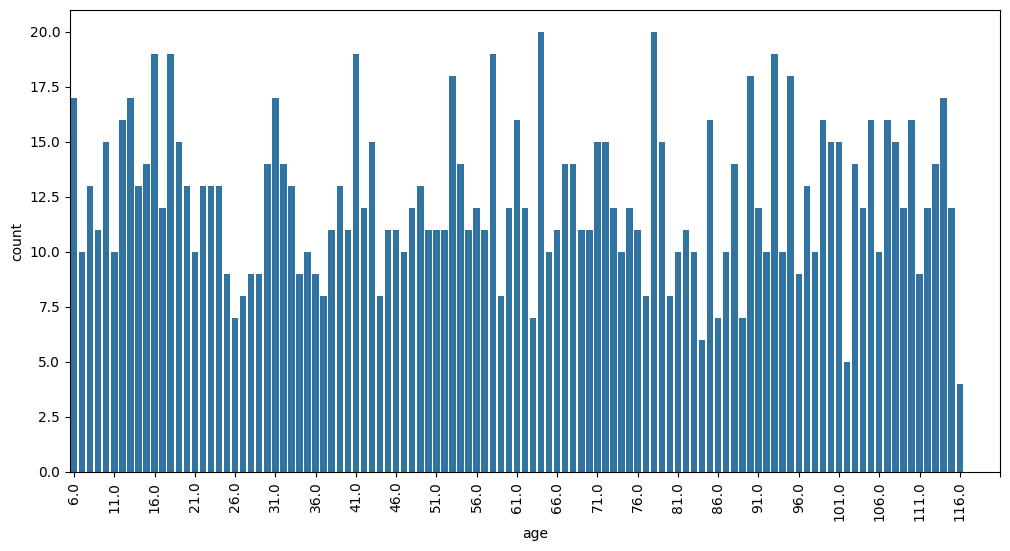

In [32]:
plt.figure(figsize=(12,6))
sns.countplot(x=users.age)
plt.xticks(range(0, 120, 5), rotation=90)
plt.show()

Z analýzy tohto údaju vieme, že vek ľudí sa pohybuje od 6 rokov do 116 rokov. Top 3 vekové skupiny sú 18, 64 a 78 rokov. Najmenšiu vekovú skupinu tvoria ľudia vo veku 116 rokov.

<AxesSubplot: ylabel='age'>

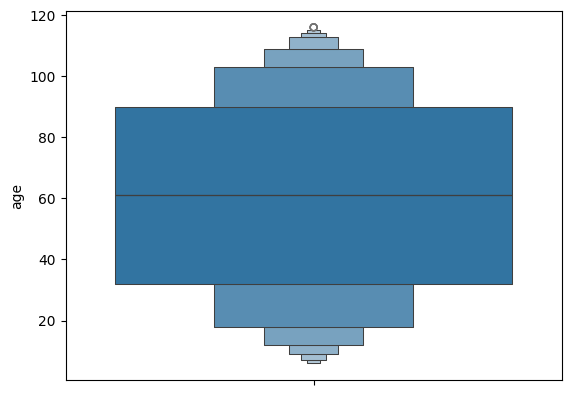

In [33]:
sns.boxenplot(y=users.age)

Z tohoto grafu napríklad vidíme, že väčšina ľudí, čo nakupovala online, je v rozmedzí približne 35 až 90 rokov

<AxesSubplot: xlabel='race'>

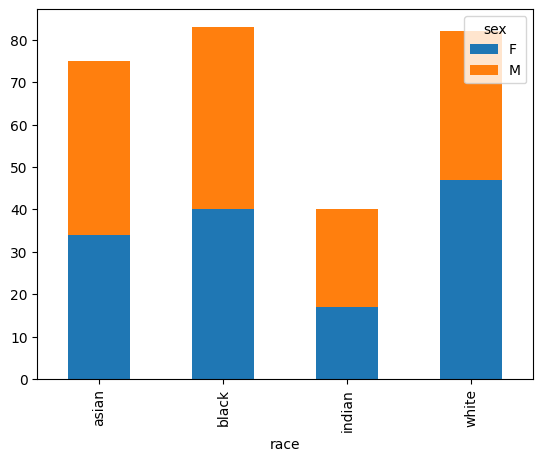

In [34]:
pd.crosstab(index=users["race"], columns=users["sex"]).plot.bar(stacked=True)

<h4>Tabuľka products</h4>

V tabuľke products sa pozrieme na atribút **location**:

In [35]:
products.location.describe()

count                14912
unique                 184
top       America/New_York
freq                  1093
Name: location, dtype: object

In [36]:
prod_loc_val_counts = products.location.value_counts(); prod_loc_val_counts

location
America/New_York    1093
Asia/Kolkata        1037
Europe/Berlin        707
America/Chicago      705
Europe/London        596
                    ... 
Africa/Bamako         10
Europe/Sarajevo       10
America/Halifax       10
Africa/Blantyre        7
Asia/Bishkek           6
Name: count, Length: 184, dtype: int64

Keďže miest, odkiaľ si ľudia objednávali produkty je veľa, uvedieme pre zaujímavosť len top 20 miest

In [37]:
top_cities = prod_loc_val_counts.nlargest(20)
top_cities

location
America/New_York       1093
Asia/Kolkata           1037
Europe/Berlin           707
America/Chicago         705
Europe/London           596
Asia/Shanghai           580
Europe/Paris            512
Europe/Moscow           498
Europe/Rome             459
America/Los_Angeles     428
Asia/Tokyo              405
America/Sao_Paulo       363
Europe/Madrid           341
Asia/Manila             304
Asia/Jakarta            287
Asia/Karachi            260
America/Mexico_City     212
Africa/Lagos            195
Europe/Amsterdam        187
Asia/Bangkok            178
Name: count, dtype: int64

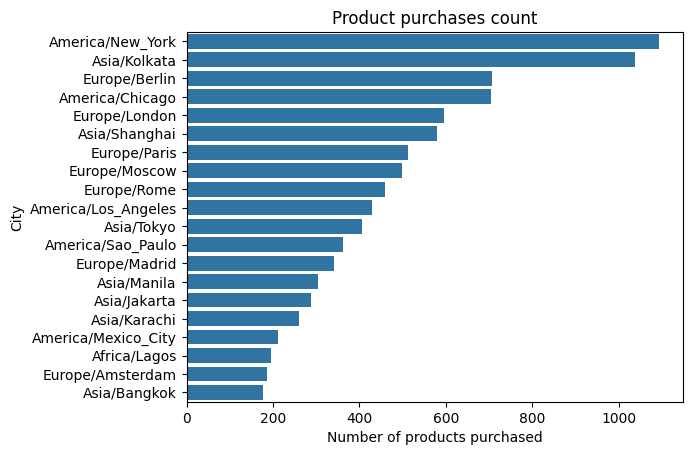

In [38]:
sns.barplot(x=top_cities.values, y=top_cities.index)

plt.title("Product purchases count")
plt.xlabel("Number of products purchased")
plt.ylabel("City")

plt.show()

Z predošlých dát vidíme, že najviac produktov si ľudia objednali z mesta New York v Amerike a najmenej z Bishkeku v Ázií.

<h4>Tabuľka sessions</h4>

Z tabuľky sessions sa pozrieme na viacero atribútov:
-ack
-total_load_time
-session_duration
-page_activity_duration
-scroll_move_total_rel_distance
-mouse_move_total_rel_distance
-pct_rage_click
-pct_click_product_info

In [39]:
sessions.head(10)

pct_scroll_move screen_width  ack  pct_mouse_move  \
0         44.92257         1366  1.0         8.79303   
1         53.93169         1280  0.0        10.69797   
2         41.66225          800  1.0        11.45911   
3         37.59937          800  1.0         9.78386   
4         62.70254         1920  0.0         7.39008   
5         61.97286         1280  1.0        10.35223   
6         37.95096         1280  0.0         7.44280   
7         55.21370          800  1.0         9.43712   
8         28.24404         1024  1.0         8.50688   
9         65.33764         1024  0.0         9.62676   

   scroll_move_total_rel_distance  page_activity_duration  pct_doubleclick  \
0                        11.16238                 5.45167          9.31170   
1                        13.20789                 8.03161         11.33962   
2                         9.16087                 7.73080          9.19028   
3                         6.38416                 9.70961          7.42759   
4                         6.09215                11.10614         10.94899   
5                         5.75549                11.34581          6.57972   
6                         8.10008                10.43996         10.59187   
7                        12.39561                 6.35263         13.35800   
8                        10.82101                 8.99179         11.15291   
9                        10.04908                 7.22268          9.88599   

   pct_click  total_load_time  mouse_move_total_rel_distance    product_ean  \
0   10.35168          2.81337                        7.79215  4142933212429   
1    7.58887          0.11913                       13.78957  6554259262213   
2    8.11378          2.60292                        5.95620  3525947927861   
3    6.54811          6.55699                        6.36864  9631384503705   
4    8.45322          0.85335                        7.94163  2238487280389   
5    8.46953          4.14889                        8.12832  1925267512228   
6    8.61040          8.01728                        8.13228  2703564692855   
7    8.59864          2.18870                        8.09075  7291805451972   
8    8.95374          3.24996                        8.77909  3735846340948   
9    9.36052          4.25322                       10.13167  6642253975717   

   pct_click_product_info screen_height  pct_wild_mouse  pct_mouse_click  \
0                41.07557          1080        53.33923         10.65208   
1                52.52006          1080        69.70571          8.32826   
2                38.74596           768        72.87642         10.18567   
3                62.74747           600        54.03365          7.75790   
4                41.10241           600        60.07533          7.59956   
5                32.17758          1080        53.84368          7.63618   
6                58.30562           600        55.99896          9.14538   
7                44.94427           600        54.95659         10.20664   
8                43.06530           600        12.09002         10.54170   
9                63.40218           800        64.24569          7.26089   

   pct_input  session_duration  wild_mouse_duration        session_start  \
0    0.00646         116.78143              5.44105  2021-05-11 10:16:37   
1    0.07267         134.68835              9.51278  2023-07-07 17:38:03   
2    0.02227         126.47138              8.10733  2019-07-24 12:15:27   
3    0.05988         263.06076              9.31265  2022-06-10 17:52:37   
4    1.45341         146.88323             12.60862  2020-09-07 15:03:13   
5    0.66407          36.55669             11.81931  2021-01-26 02:26:58   
6    0.13232          98.09171             10.14409  2022-08-07 04:30:11   
7    0.01555         215.02259              7.40475  2019-01-03 03:39:41   
8    0.02515         205.55848              8.14649  2022-10-05 13:22:24   
9    0.05369         138.49897              9.22675  2019-07

<h5>ACK</h5>

In [40]:
sessions.ack.describe()

count    10912.000000
mean         0.549487
std          0.497568
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: ack, dtype: float64

In [41]:
sessions.ack.value_counts()

ack
1.0    5996
0.0    4916
Name: count, dtype: int64

C:\Users\jakub\AppData\Local\Temp\ipykernel_19980\350989846.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=sessions.ack, palette="rocket")


<AxesSubplot: xlabel='ack', ylabel='count'>

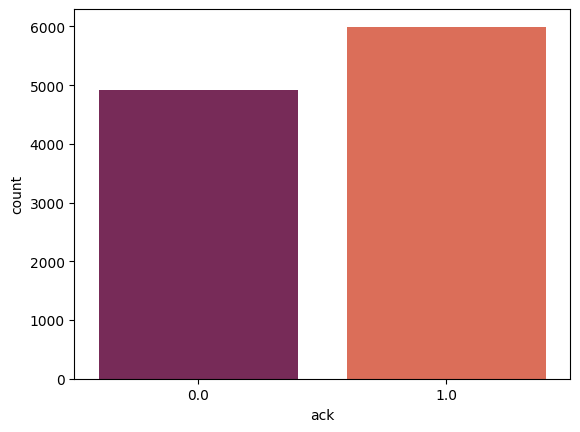

In [42]:
sns.countplot(x=sessions.ack, palette="rocket")

<h5>Total_load_time</h5>

In [43]:
sessions.total_load_time.describe()

count    10912.000000
mean         3.984017
std          2.817457
min          0.003570
25%          1.913255
50%          3.339890
75%          5.354380
max         23.487790
Name: total_load_time, dtype: float64

<AxesSubplot: ylabel='total_load_time'>

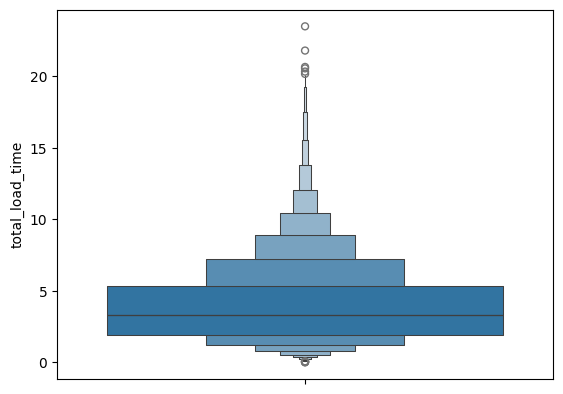

In [44]:
sns.boxenplot(y=sessions.total_load_time)

<AxesSubplot: xlabel='total_load_time', ylabel='Count'>

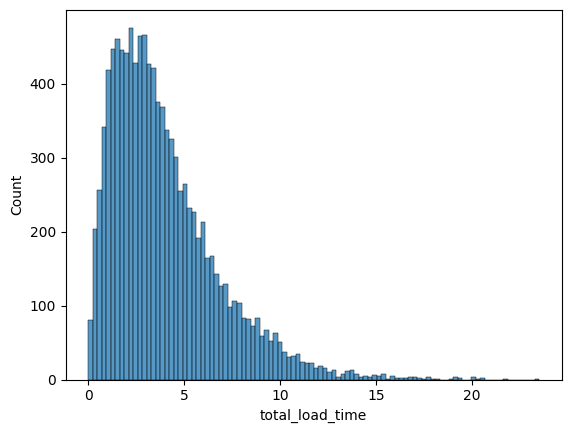

In [45]:
sns.histplot(sessions.total_load_time, bins=100)

<h5>Session duration</h5>

In [46]:
sessions.session_duration.describe()

count    10912.000000
mean       150.156130
std         60.380152
min        -47.247120
25%        109.037757
50%        151.104965
75%        190.967010
max        366.445590
Name: session_duration, dtype: float64

<AxesSubplot: ylabel='session_duration'>

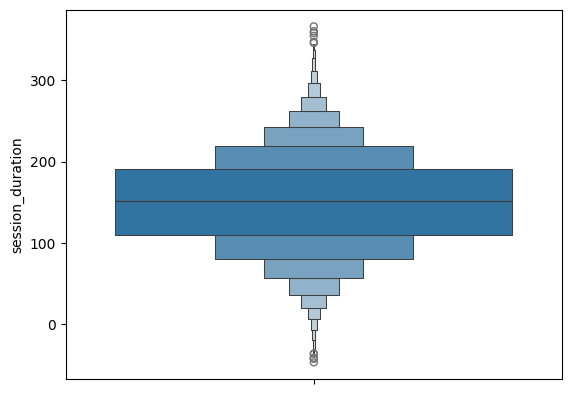

In [47]:
sns.boxenplot(y=sessions.session_duration)

<AxesSubplot: xlabel='session_duration', ylabel='Count'>

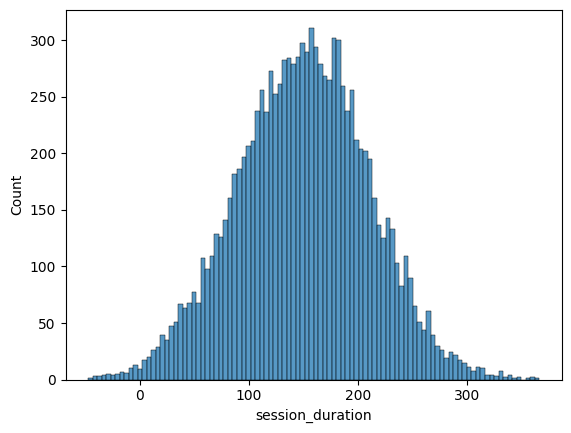

In [48]:
sns.histplot(sessions.session_duration, bins=100)

<h5>Page_Activity_duration</h5>

In [49]:
sessions.page_activity_duration.describe()

count    10912.000000
mean         9.045979
std          2.199447
min          2.812950
25%          7.306475
50%          9.046640
75%         10.748287
max         16.572150
Name: page_activity_duration, dtype: float64

<AxesSubplot: ylabel='page_activity_duration'>

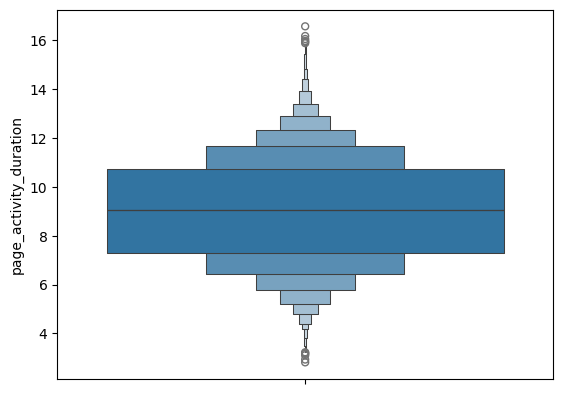

In [50]:
sns.boxenplot(y=sessions.page_activity_duration)

<AxesSubplot: xlabel='page_activity_duration', ylabel='Count'>

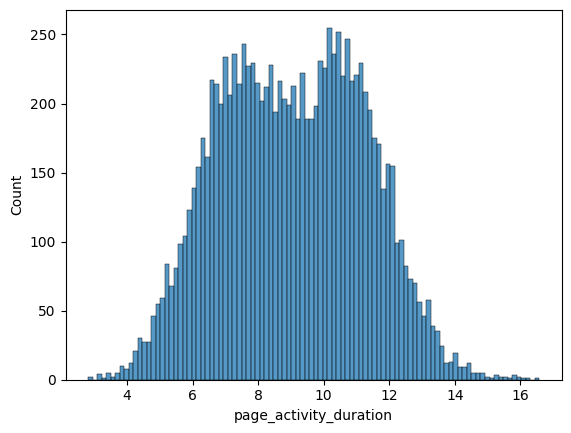

In [51]:
sns.histplot(sessions.page_activity_duration, bins=100)

<h5>Scroll_move_total_rel_distance</h5>

In [52]:
sessions.scroll_move_total_rel_distance.describe()

count    10912.000000
mean         9.436445
std          3.366636
min          0.000000
25%          6.727070
50%          9.023465
75%         12.183375
max         20.349730
Name: scroll_move_total_rel_distance, dtype: float64

<AxesSubplot: ylabel='scroll_move_total_rel_distance'>

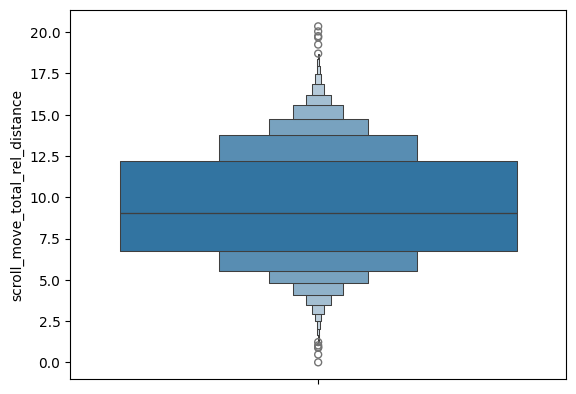

In [53]:
sns.boxenplot(y=sessions.scroll_move_total_rel_distance)

<AxesSubplot: xlabel='scroll_move_total_rel_distance', ylabel='Count'>

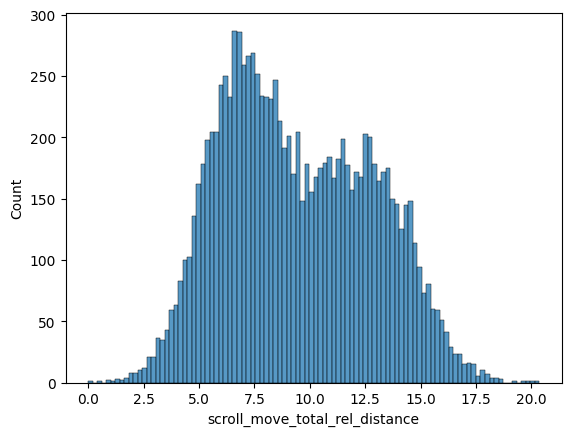

In [54]:
sns.histplot(sessions.scroll_move_total_rel_distance, bins=100)

<h5>Mouse_move_total_rel_distance</h5>

In [55]:
sessions.mouse_move_total_rel_distance.describe()

count    10912.000000
mean         8.116084
std          2.143902
min          1.228680
25%          6.595477
50%          7.982980
75%          9.645398
max         15.791510
Name: mouse_move_total_rel_distance, dtype: float64

<AxesSubplot: ylabel='mouse_move_total_rel_distance'>

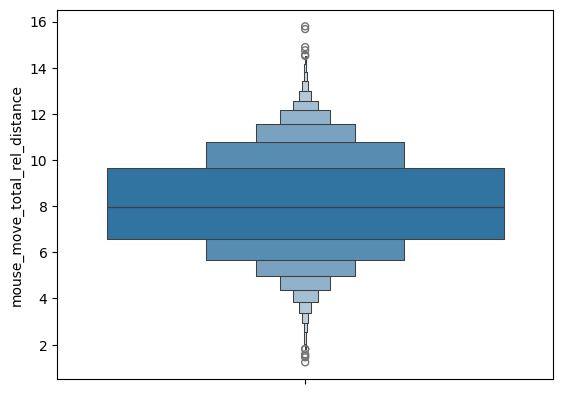

In [56]:
sns.boxenplot(y=sessions.mouse_move_total_rel_distance)

<AxesSubplot: xlabel='mouse_move_total_rel_distance', ylabel='Count'>

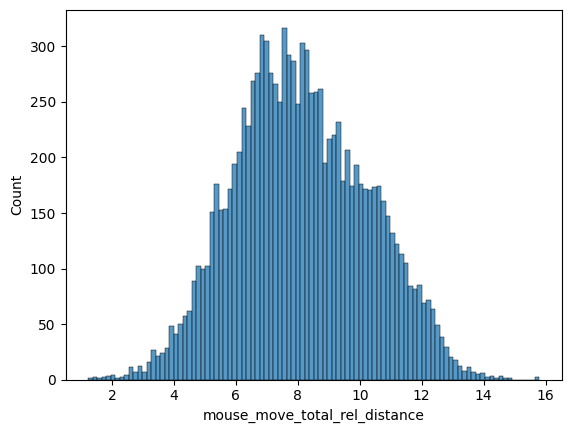

In [57]:
sns.histplot(sessions.mouse_move_total_rel_distance, bins=100)

<h5>Pct_rage_click</h5>

In [58]:
sessions.pct_rage_click.describe()

count    10912.000000
mean        51.156387
std         13.008655
min          0.000000
25%         42.562180
50%         51.067095
75%         59.887293
max        100.000000
Name: pct_rage_click, dtype: float64

<AxesSubplot: ylabel='pct_rage_click'>

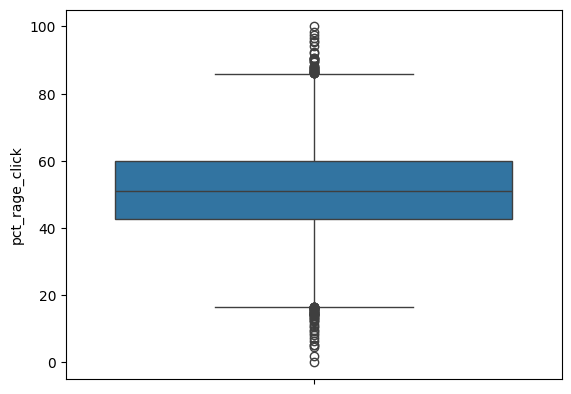

In [59]:
sns.boxplot(y=sessions.pct_rage_click)

<AxesSubplot: xlabel='pct_rage_click', ylabel='Count'>

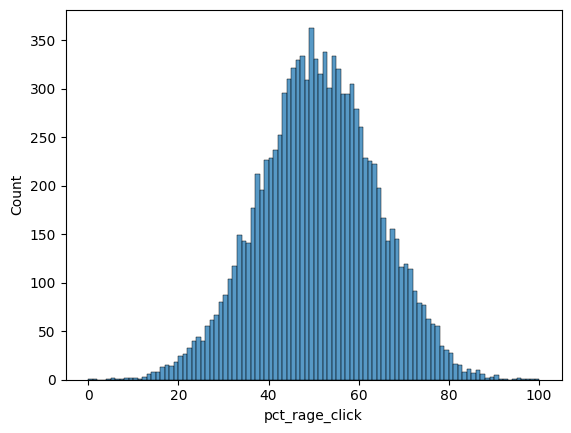

In [60]:
sns.histplot(sessions.pct_rage_click, bins=100)

<h5>Pct_click_product_info</h5>

In [61]:
sessions.pct_click_product_info.describe()

count    10912.000000
mean        51.341515
std         12.703651
min          0.000000
25%         42.755845
50%         51.322265
75%         59.871335
max        100.000000
Name: pct_click_product_info, dtype: float64

<AxesSubplot: ylabel='pct_click_product_info'>

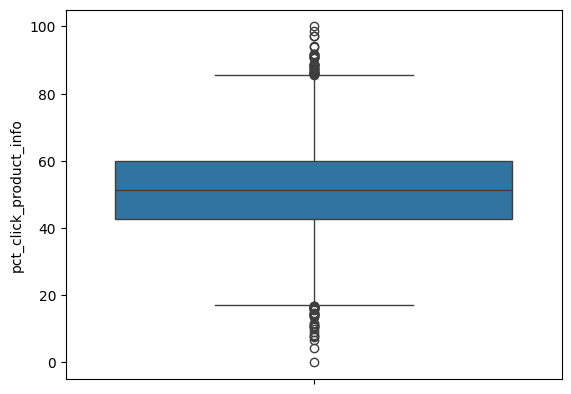

In [62]:
sns.boxplot(y=sessions.pct_click_product_info)

<AxesSubplot: xlabel='pct_click_product_info', ylabel='Count'>

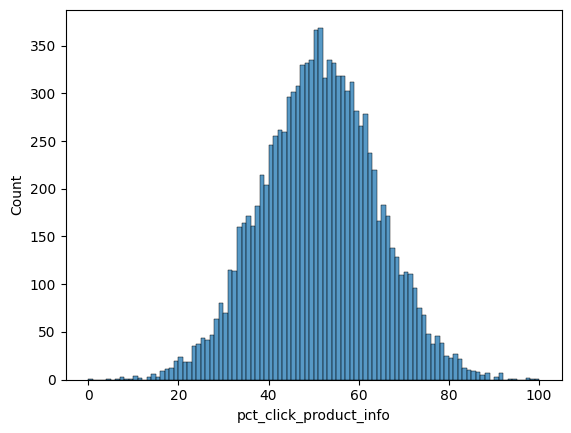

In [63]:
sns.histplot(sessions.pct_click_product_info, bins=100)

<h1>Párová analýza dát</h1>

In [64]:
clean_sessions = sessions.drop(["session_start", "session_id", "user_id"], axis=1)

Najprv si vykreslíme heat map na prezretie korelácií z tabuľky sessions:

<AxesSubplot: >

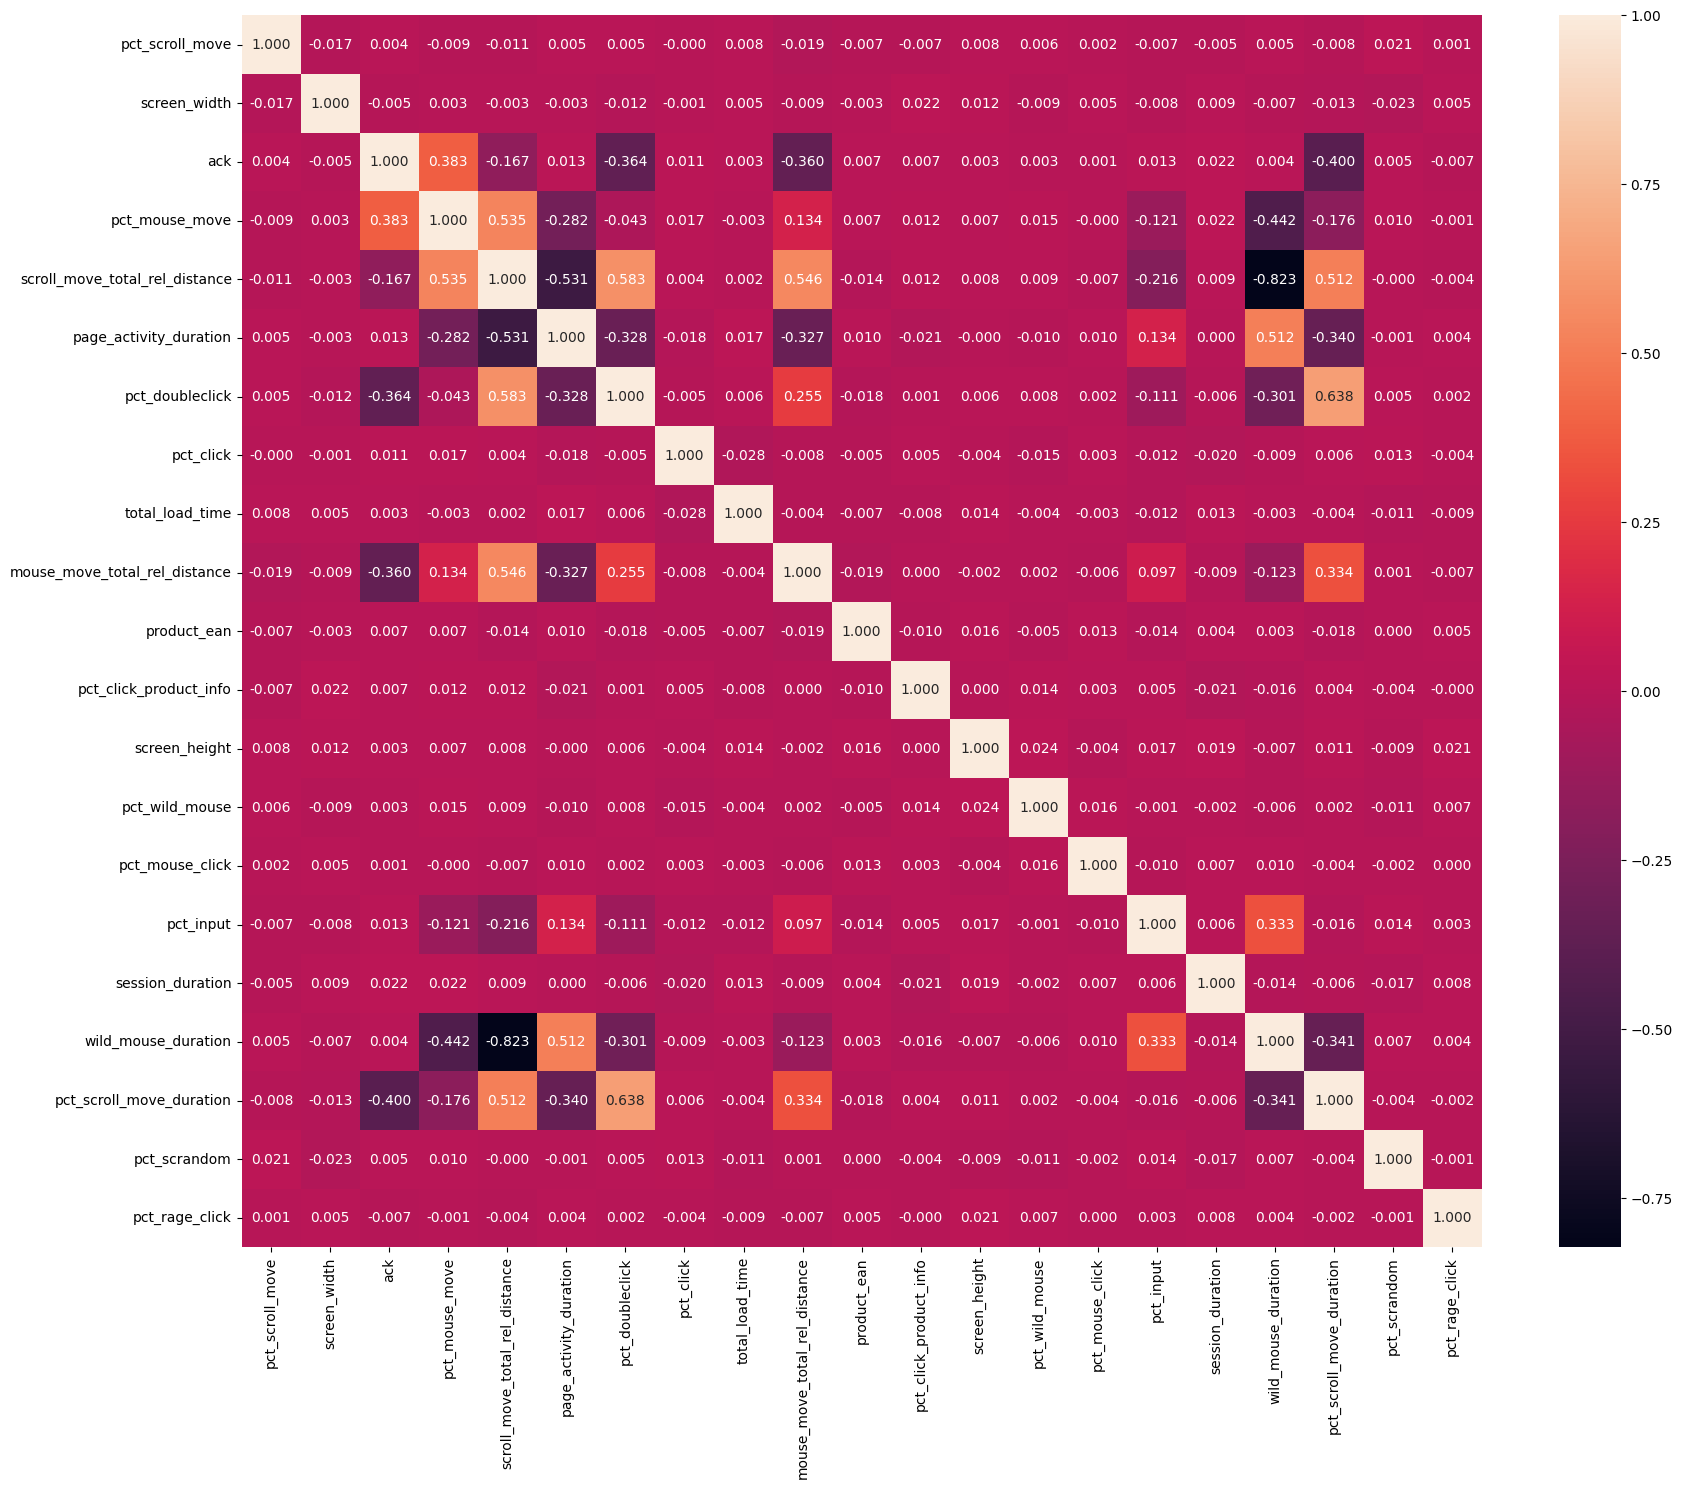

In [65]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(clean_sessions.corr(),ax=ax, annot =True, fmt = ".3f")

Z heat mapy vidíme, že nasledovné atribúty skoro vôbec nekorelujú s ostatnými atribútmi:
<ul>
<li>pct_scroll_move
<li>screen_width
<li>pct_click
<li>total_load_time
<li>product_ean
<li>pct_click_product_info
<li>screen_height
<li>pct_wild_mouse
<li>pct_mouse_click
<li>session_duration
<li>pct_random
<li>pct_rage_click
</ul>

Následne v heat mape vidíme aj nejaké kladné korelácie. Je ich viacero, tak spomenieme len niektoré z nich:
<ul>
<li>pct_scroll_move_duration a pct_doubleclick
<li>scroll_move_total_rel_distance a pct_doubleclick
<li>mouse_move_total_rel_distance a scroll_move_total_rel_distance
<li><b>ack a pct_mouse_move</b>
</ul>

Uvedieme si aj pár negatívnych korelácií:
<ul>
<li>wild_mouse_duration a scroll_move_total_rel_distance
<li>page_activity_duration a scroll_move_total_rel_distance
<li>wild_mouse_duration a pct_mouse_move
<li><b>ack a pct_scroll_move_duration</b>
</ul>

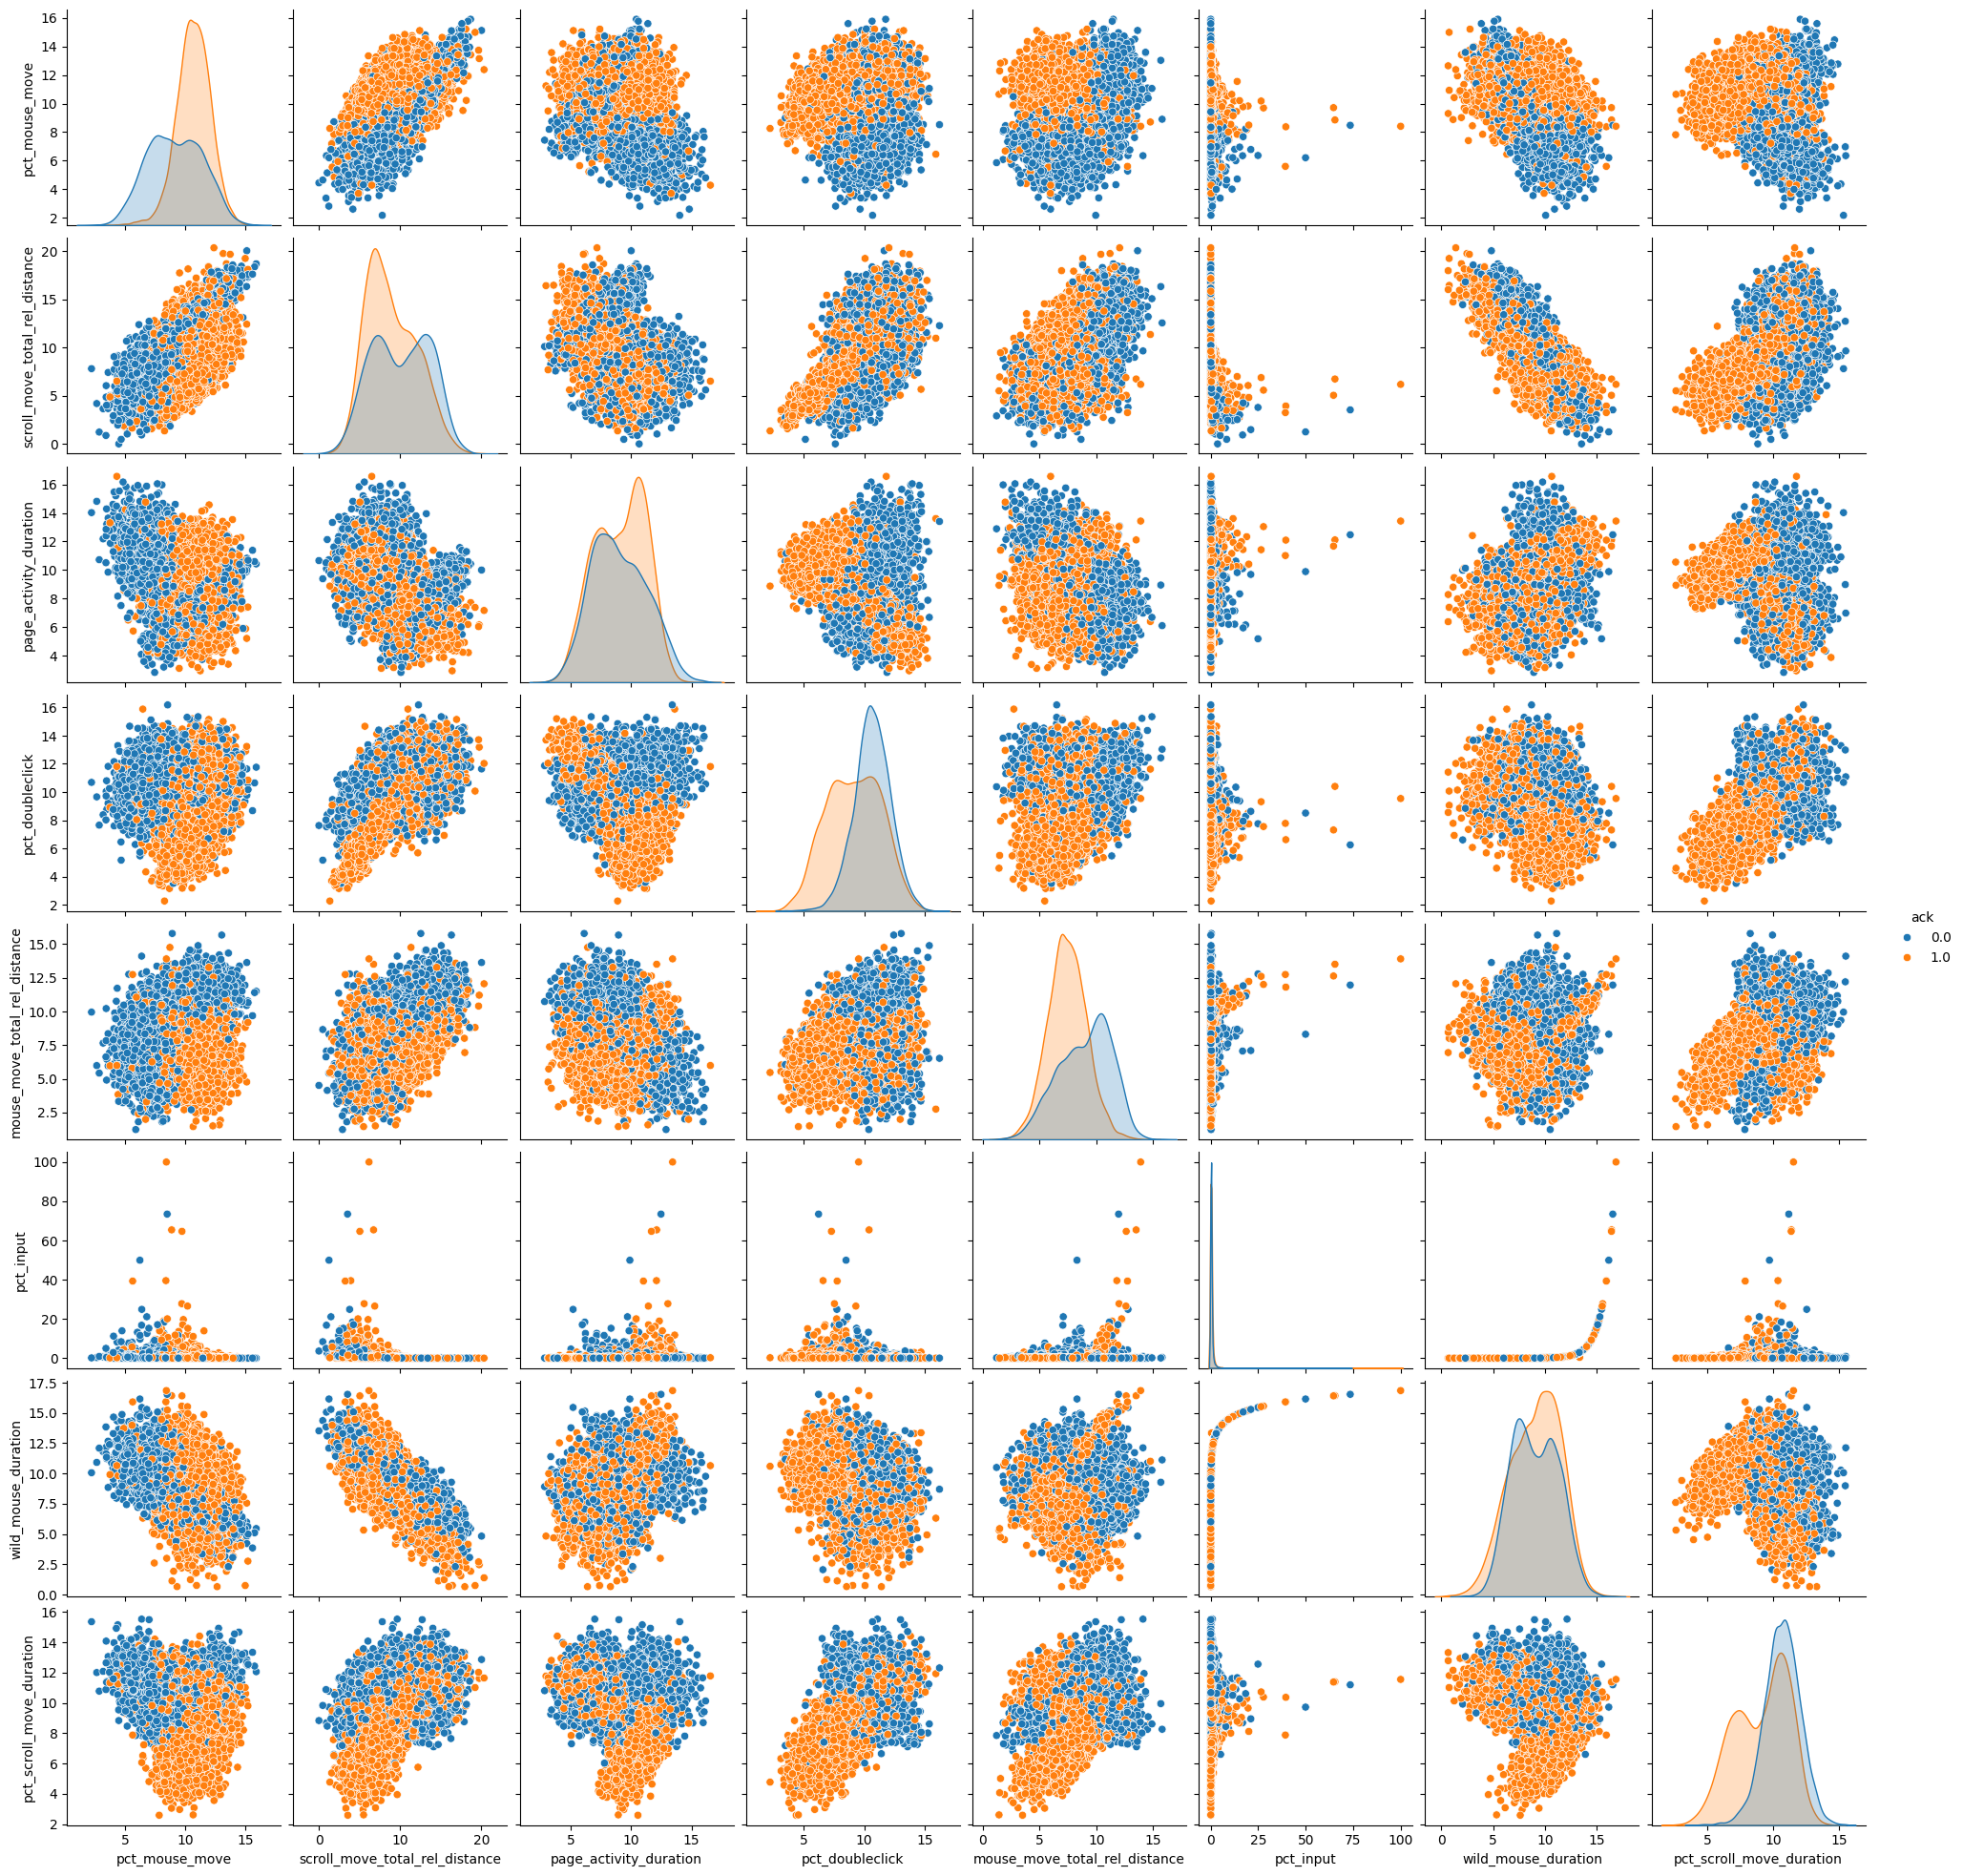

In [66]:
sns.pairplot(sessions, vars=['pct_mouse_move', 'scroll_move_total_rel_distance', 'page_activity_duration', 'pct_doubleclick', 'mouse_move_total_rel_distance', 'pct_input', 'wild_mouse_duration', 'pct_scroll_move_duration'], hue='ack', diag_kind='kde')

Nasledujúcim grafom vykresľujeme najväčšiu negatívnu koreláciu, ktorú sme spozoravali na heat mape:

Korelácia: -0.823


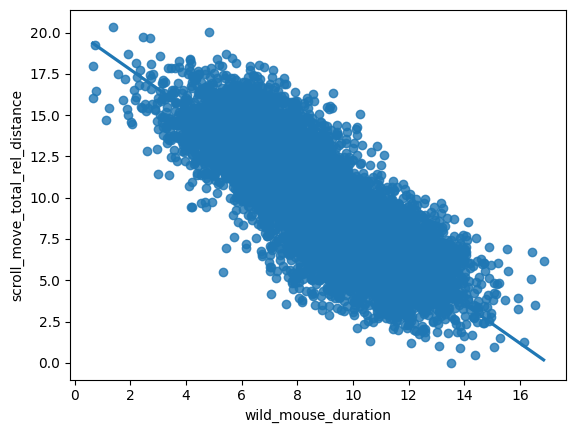

In [67]:
sns.regplot(sessions, x='wild_mouse_duration', y='scroll_move_total_rel_distance')
print("Korelácia: %.3f" % sessions.wild_mouse_duration.corr(sessions.scroll_move_total_rel_distance))

Nasledujúci graf naopak znázorňuje atribúty s najväčšiou kladnou mierou korelácie v heat mape: 

Korelácia: 0.638


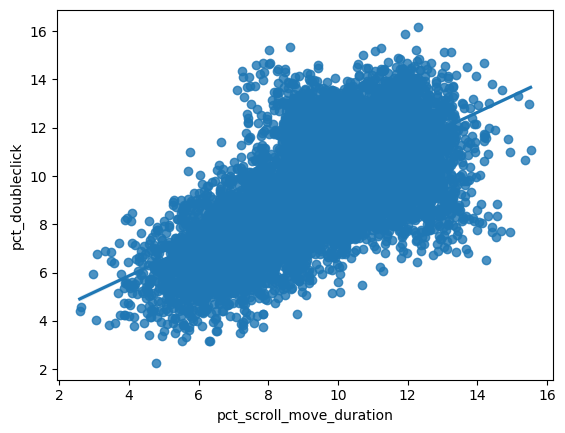

In [68]:
sns.regplot(sessions, x='pct_scroll_move_duration', y='pct_doubleclick')
print("Korelácia: %.3f" % sessions.pct_scroll_move_duration.corr(sessions.pct_doubleclick))

Ďalej ešte uvedieme najväčsiu kladnú a zápornú koreláciu s premennou ACK:

Korelácia: 0.383


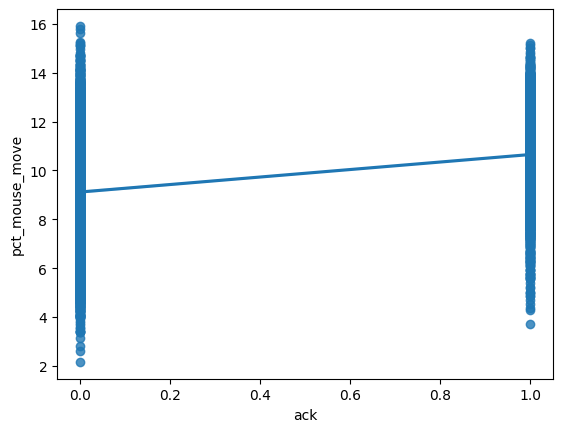

In [69]:
sns.regplot(sessions, x='ack', y='pct_mouse_move')
print("Korelácia: %.3f" % sessions.ack.corr(sessions.pct_mouse_move))

Korelácia: -0.400


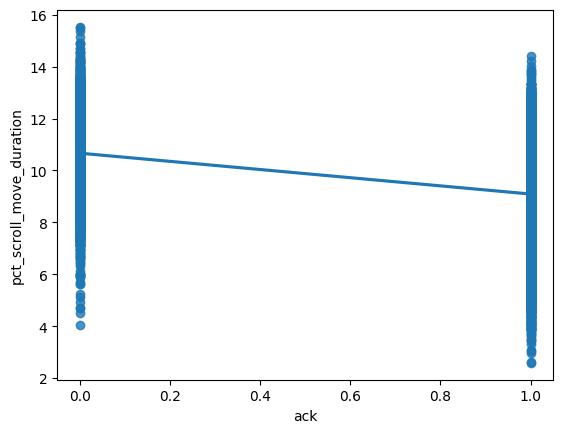

In [70]:
sns.regplot(sessions, x='ack', y='pct_scroll_move_duration')
print("Korelácia: %.3f" % sessions.ack.corr(sessions.pct_scroll_move_duration))

<h2>Formulácia a štatistické overenie hypotéz o dátach<h2>

<h4>Hypotéza 1</h4>
<b>H0: </b> Dĺžka sedenia (session duration) má v priemere vyššiu hodnotu pri ack=1 ako pri ack=0 <br>
<b>H1: </b> Dĺžka sedenia (session duration) má v priemere nižšiu honodtu pri ack=1 ako pri ack=0

In [71]:
ack_0 = sessions[sessions['ack'] == 0]['session_duration']
ack_1 = sessions[sessions['ack'] == 1]['session_duration']

Overíme, či sú vzorky z normalného rozdelenia pomocou shapiro testu.

In [72]:
stats.shapiro(ack_0)

ShapiroResult(statistic=0.9994584918022156, pvalue=0.1671016812324524)

In [73]:
stats.shapiro(ack_1)

c:\Users\jakub\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9996889233589172, pvalue=0.5102398991584778)

V obidvoch prípadoch p-value > 0.05, číže tieto dáta sú z normalného rozdelenia.

In [74]:
stats.ttest_ind(ack_1, ack_0, alternative='less')

TtestResult(statistic=2.2730806711221643, pvalue=0.9884796625641087, df=10910.0)

<AxesSubplot: xlabel='session_duration', ylabel='Count'>

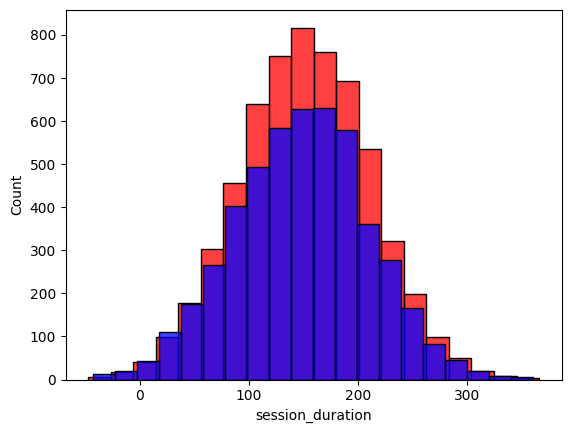

In [75]:
sns.histplot(ack_1, bins=20, color="red")
sns.histplot(ack_0, bins=20, color="blue")


p-value > 0.05, z toho nám vyplýva, že H0 nezamietame a teda dĺžka sedenia je v priemere dlhšia pri ack=1. Inak povedané, používatelia s väčšou pravdepodobnosťou nakupujú vtedy, keď v priemere stravia viac času na stránke. <br>
Tiež to vidíme z grafu, kde modré hodnoty (session duration pri ack_0) sú menšie než červené (session duration pri ack = 1).

<h4>Hypotéza 2</h4>
<b>H0:</b> total_load_time je v priemere rovnaký pri ack=1 aj pri ack=0<br>
<b>H1: </b>total_load_time je v priemere rozdielný pri ack=1 aj pri ack=0

In [76]:
lt_ack_0 = sessions[sessions['ack'] == 0]['total_load_time']
lt_ack_1 = sessions[sessions['ack'] == 1]['total_load_time']

Rovnakým spôsobom skontrolujeme si distribúcie.

In [77]:
stats.shapiro(lt_ack_0)

ShapiroResult(statistic=0.8956302404403687, pvalue=0.0)

In [78]:
stats.shapiro(lt_ack_1)

c:\Users\jakub\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8988420963287354, pvalue=0.0)

Ako vidíme, pri obidvoch testoch, tak dáta nemajú normálnu distribúciu, preto spravíme U-test. 

In [79]:
stats.mannwhitneyu(lt_ack_1, lt_ack_0)

MannwhitneyuResult(statistic=14897490.0, pvalue=0.3305050400707018)

<AxesSubplot: xlabel='total_load_time', ylabel='Count'>

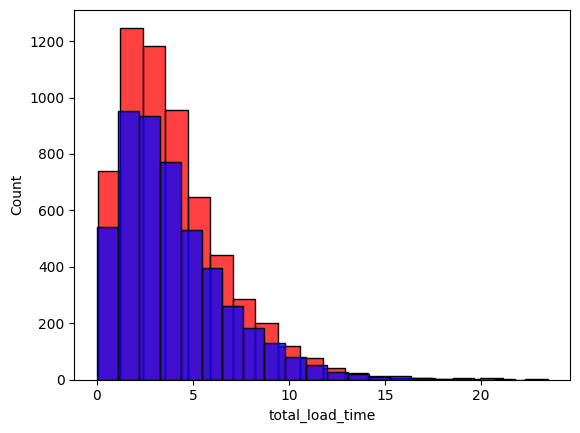

In [80]:
sns.histplot(lt_ack_1, bins=20, color="red")
sns.histplot(lt_ack_0, bins=20, color="blue")

p-value mann-whitney testu vyšlo približne 0.33, čo je väčšie ako 0.05, teda H0 nezamietame a platí, že priemerný total_load_time (čas načítania stránky) rovnaký pri ack=1 aj pri ack=0. 
Takže to, ako dlho sa načítavala stránka v týchto prípadoch neovplyvnilo to, či používatelia nakúpili alebo nie.

<h2>Záver</h2><br>
V dátach boli duplicitné hodnoty, ktoré sme odstraňovali, v niketorých atribútoch bolo nekonzinstentné formátovanie, napríklad v users dátum registrácie. Niektoré údaje v sessions, napr. screen width a height mali číselné hodnoty, medzi ktorými sa vyskytovali aj reťazce. V tabuľke users v rasách boli unspecified hodnoty alebo zle zapísané nan hodnoty, tak sme ich konvertovali na NaN.<br>


V tabuľke sessions sme našli chýbajúce hodnoty, ktoré sme nahradili priemermi v daných stĺpcoch. Chýbajúce hodnoty máme aj v tabuľke users ako napríklad race (približne 79% chýba), toto množstvo ešte stále akceptujeme.

In [81]:
print(users.isnull().sum(), '\n')
print(len(users), '\n')
print('Percento chýbajúcich hodnôt pre race: ', users.race.isnull().sum()/len(users)*100, '%')

sex                 1320
user_id               48
current_location     177
address              432
job                 1571
name                  48
race                2051
mail                  48
username              48
registration          48
birthdate           1213
age                 1213
dtype: int64 

2588 

Percento chýbajúcich hodnôt pre race:  79.25038639876352 %


V tabuľke users niektorý používatelia mali vek 0, 1, 2 atď. ktorý nerealistický. Zatiaľ sme tento problém riešili tak, že sme tieto údaje odstránili.

<h1>IAU fáza 2.</h1>
Maria Fedosenya (50%) a Jakub Grúber (50%)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pylab as pylab
import statsmodels.api as sm
from sklearn.preprocessing import FunctionTransformer
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import scipy.stats as stats
from matplotlib import pyplot
from collections import Counter
from datetime import datetime, date
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler ,MinMaxScaler, PowerTransformer,QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.svm import SVR
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
pd.options.mode.chained_assignment = None
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

pd.set_option('display.max_columns', 25) #nastavené kvôli sessions.csv, ktoré má 25 stĺpcov, aby sa dali všetky prezrieť

In [ ]:
sessions_path = "./data/phase_1/session.csv"
users_path = "./data/phase_1/user.csv"
products_path = "./data/phase_1/product.csv"

In [ ]:
products = pd.read_csv(products_path)
products.head()

code           location store_name    product_ean
0   RU      Europe/Moscow    Kashira  8840337777778
1   SK  Europe/Bratislava    Skalica  9613080891331
2   PH        Asia/Manila   Antipolo  8545276183603
3   PK       Asia/Karachi    Larkana  9999281937499
4   CN      Asia/Shanghai   Hushitai  1423598805373

In [ ]:
users = pd.read_csv(users_path)
users.head()

sex  user_id                                current_location  \
0    M   1270.0  (Decimal('43.6199585'), Decimal('-39.027502'))   
1    F    146.0  (Decimal('67.5016935'), Decimal('169.135745'))   
2  NaN   2178.0  (Decimal('-83.0843785'), Decimal('35.417096'))   
3  NaN   1211.0  (Decimal('85.896300'), Decimal('-141.411207'))   
4    F   1678.0   (Decimal('71.468916'), Decimal('-69.232181'))   

                                             address           job  \
0                Samova 235 750 67 Police nad Metuji        Lawyer   
1                     Doringstr. 1/8 09217 Stassfurt  Augenoptiker   
2  Stretto Surian, 1 Appartamento 5 09071, Abbasa...           NaN   
3  Gang Shan Xian Wo Sun Zi Shi Shang Guang Gu 4D...           NaN   
4                            USS Nelson FPO AE 34617           NaN   

                 name race                        mail        username  \
0  MUDr. Premysl Riha  NaN  stastnyrostislav@seznam.cz          ales00   
1        Verena Zirme  NaN       marinaschueler@aol.de  schweitzertoni   
2  Sabatino Salvemini  NaN       alberto76@virgilio.it        rviviani   
3       Qing Mu  Ren   NaN    nishimuraasuka@yahoo.com      fmatsumoto   
4         Vicki Lopez  NaN           ghowell@yahoo.com           nreed   

  registration   birthdate   age  
0   2023-08-23  1981-08-08  42.0  
1   2022-07-02  2010-09-15  13.0  
2   2017-10-26  1957-07-10  66.0  
3   2020-02-22  1961-03-02  62.0  
4   2022-02-14         NaN   NaN

In [ ]:
sessions = pd.read_csv(sessions_path)
sessions.head()

pct_scroll_move  screen_width  ack  pct_mouse_move  \
0         44.92257          1366  1.0         8.79303   
1         53.93169          1280  0.0        10.69797   
2         41.66225           800  1.0        11.45911   
3         37.59937           800  1.0         9.78386   
4         62.70254          1920  0.0         7.39008   

   scroll_move_total_rel_distance  page_activity_duration  pct_doubleclick  \
0                        11.16238                 5.45167          9.31170   
1                        13.20789                 8.03161         11.33962   
2                         9.16087                 7.73080          9.19028   
3                         6.38416                 9.70961          7.42759   
4                         6.09215                11.10614         10.94899   

   pct_click  total_load_time  mouse_move_total_rel_distance    product_ean  \
0   10.35168          2.81337                        7.79215  4142933212429   
1    7.58887          0.11913                       13.78957  6554259262213   
2    8.11378          2.60292                        5.95620  3525947927861   
3    6.54811          6.55699                        6.36864  9631384503705   
4    8.45322          0.85335                        7.94163  2238487280389   

   pct_click_product_info  screen_height  pct_wild_mouse  pct_mouse_click  \
0                41.07557           1080        53.33923         10.65208   
1                52.52006           1080        69.70571          8.32826   
2                38.74596            768        72.87642         10.18567   
3                62.74747            600        54.03365          7.75790   
4                41.10241            600        60.07533          7.59956   

   pct_input  session_duration  wild_mouse_duration        session_start  \
0    0.00646         116.78143              5.44105  2021-05-11 10:16:37   
1    0.07267         134.68835              9.51278  2023-07-07 17:38:03   
2    0.02227         126.47138              8.10733  2019-07-24 12:15:27   
3    0.05988         263.06076              9.31265  2022-06-10 17:52:37   
4    1.45341         146.88323             12.60862  2020-09-07 15:03:13   

   pct_scroll_move_duration  pct_scrandom  pct_rage_click  session_id  user_id  
0                  11.39851      60.96280        42.77314     1126926     2369  
1                   9.48454      56.71155        30.83474      103955     1186  
2                   9.51528      58.17433        39.30398      731099     1265  
3                   4.91020      68.47422        46.14026     1379903      467  
4                  10.63283      28.45915        42.41093      691237      594

<h1>Integrácia a čistenie dát</h1>

Predtým, ako začneme dáta čistiť si ich potrebujeme previesť na numerické hodnoty.

V datasete products máme veľa unique hodnôt, ktoré by nemalo zmysel prevádzať na číselné hodnoty.

Pokračujeme teda datasetom users:

Tu v stĺpci sex máme len dve hodnoty M alebo F (muž alebo žena). Tieto teda vieme reprezentovať ako 1 - muž a 0 - žena

In [ ]:
users_numeric = users.copy()

try:
    users_numeric['sex'] = users_numeric['sex'].str.replace('M', "1")
    users_numeric['sex'] = users_numeric['sex'].str.replace('F', "0")
    users_numeric = users_numeric.assign(sex = pd.to_numeric(users_numeric['sex']))
except:
    print("Data is already of type number")

Ďaľší atribút, ktorý vieme previesť na číselné hodnoty je atribút race

In [ ]:
users_numeric['race'].unique()

array([nan, 'white', 'indian', 'black', 'asian'], dtype=object)

Keďže máme 4 unikátne typy rás, vieme ich reprezentovať nasledovne:
<ul>
<li>White - 1
<li>indian - 2
<li>black - 3
<li>asian - 4
</ul>

In [ ]:
try:
    users_numeric['race'] = users_numeric['race'].str.replace("white", "1")
    users_numeric['race'] = users_numeric['race'].str.replace("indian", "2")
    users_numeric['race'] = users_numeric['race'].str.replace("black", "3")
    users_numeric['race'] = users_numeric['race'].str.replace("asian", "4") 
    users_numeric = users_numeric.assign(race = pd.to_numeric(users_numeric['race']))
except:
    print("Data is already of type number")

Atribúty registraction a birthdate vieme upraviť na číslo vhodné pre machine learning nasledovne:

In [ ]:
users_numeric = users_numeric.assign(registration = pd.to_datetime(users_numeric['registration']))
users_numeric['registration'] = (users_numeric['registration'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [ ]:
users_numeric = users_numeric.assign(birthdate = pd.to_datetime(users_numeric['birthdate']))
users_numeric['birthdate'] = (users_numeric['birthdate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

Ostatné atribúty, ktoré nevieme previesť na čísla z datasetu odstránime

In [ ]:
users_numeric = users_numeric.drop(['current_location', 'address', 'job', 'name', 'mail', 'username'], axis=1)

In [ ]:
users_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588 entries, 0 to 2587
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex           1268 non-null   float64
 1   user_id       2540 non-null   float64
 2   race          537 non-null    float64
 3   registration  2540 non-null   float64
 4   birthdate     1375 non-null   float64
 5   age           1375 non-null   float64
dtypes: float64(6)
memory usage: 121.4 KB


In [ ]:
users_numeric.head()

sex  user_id  race  registration     birthdate   age
0  1.0   1270.0   NaN  1.692749e+09  3.660768e+08  42.0
1  0.0    146.0   NaN  1.656720e+09  1.284509e+09  13.0
2  NaN   2178.0   NaN  1.508976e+09 -3.938112e+08  66.0
3  NaN   1211.0   NaN  1.582330e+09 -2.788128e+08  62.0
4  0.0   1678.0   NaN  1.644797e+09           NaN   NaN

Ako posledný ideme upravovať dataset sessions:

In [ ]:
sessions_numeric = sessions.copy()

sessions_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10912 entries, 0 to 10911
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move                 10912 non-null  float64
 1   screen_width                    10912 non-null  int64  
 2   ack                             10912 non-null  float64
 3   pct_mouse_move                  10912 non-null  float64
 4   scroll_move_total_rel_distance  10912 non-null  float64
 5   page_activity_duration          10912 non-null  float64
 6   pct_doubleclick                 10912 non-null  float64
 7   pct_click                       10912 non-null  float64
 8   total_load_time                 10912 non-null  float64
 9   mouse_move_total_rel_distance   10912 non-null  float64
 10  product_ean                     10912 non-null  int64  
 11  pct_click_product_info          10912 non-null  float64
 12  screen_height                   

Vyzerá, že jediným atribútom, ktorý nemá číselnú podobu je session_start. Upravíme ho podobne ako registration a birthdate z users:

In [ ]:
sessions_numeric = sessions_numeric.assign(session_start = pd.to_datetime(sessions_numeric['session_start']))
sessions_numeric['session_start'] = (sessions_numeric['session_start'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [ ]:
sessions_numeric.head()

pct_scroll_move  screen_width  ack  pct_mouse_move  \
0         44.92257          1366  1.0         8.79303   
1         53.93169          1280  0.0        10.69797   
2         41.66225           800  1.0        11.45911   
3         37.59937           800  1.0         9.78386   
4         62.70254          1920  0.0         7.39008   

   scroll_move_total_rel_distance  page_activity_duration  pct_doubleclick  \
0                        11.16238                 5.45167          9.31170   
1                        13.20789                 8.03161         11.33962   
2                         9.16087                 7.73080          9.19028   
3                         6.38416                 9.70961          7.42759   
4                         6.09215                11.10614         10.94899   

   pct_click  total_load_time  mouse_move_total_rel_distance    product_ean  \
0   10.35168          2.81337                        7.79215  4142933212429   
1    7.58887          0.11913                       13.78957  6554259262213   
2    8.11378          2.60292                        5.95620  3525947927861   
3    6.54811          6.55699                        6.36864  9631384503705   
4    8.45322          0.85335                        7.94163  2238487280389   

   pct_click_product_info  screen_height  pct_wild_mouse  pct_mouse_click  \
0                41.07557           1080        53.33923         10.65208   
1                52.52006           1080        69.70571          8.32826   
2                38.74596            768        72.87642         10.18567   
3                62.74747            600        54.03365          7.75790   
4                41.10241            600        60.07533          7.59956   

   pct_input  session_duration  wild_mouse_duration  session_start  \
0    0.00646         116.78143              5.44105     1620728197   
1    0.07267         134.68835              9.51278     1688751483   
2    0.02227         126.47138              8.10733     1563970527   
3    0.05988         263.06076              9.31265     1654883557   
4    1.45341         146.88323             12.60862     1599490993   

   pct_scroll_move_duration  pct_scrandom  pct_rage_click  session_id  user_id  
0                  11.39851      60.96280        42.77314     1126926     2369  
1                   9.48454      56.71155        30.83474      103955     1186  
2                   9.51528      58.17433        39.30398      731099     1265  
3                   4.91020      68.47422        46.14026     1379903      467  
4                  10.63283      28.45915        42.41093      691237      594

<h3>Chýbajúce hodnoty (missing values)</h3>
V predchádzajúcej fáze sme chýbajúce hodnoty v datasete sessions skúsili nahradiť priemerom. Teraz skúsime inú metódu a skúsime ich nahradiť pomocou lineárnej regresie (KNN). Na to si ale musíme načítať pôvodný dataset, nakoľko v tejto fáze už pracujeme s upravenými dátami oproti pôvodným:

In [ ]:
sess_filepath = "data/origin/session.csv"
sessions_test = pd.read_csv(sess_filepath, sep='\t') #dataframe for sessions to try other methods of missing values replacement
sessions_test.head()

pct_scroll_move screen_width  ack  pct_mouse_move  \
0         44.92257         1366  1.0         8.79303   
1         53.93169         1280  0.0        10.69797   
2         41.66225        lower  1.0        11.45911   
3         37.59937        lower  1.0         9.78386   
4         62.70254       higher  0.0         7.39008   

   scroll_move_total_rel_distance  page_activity_duration  pct_doubleclick  \
0                        11.16238                 5.45167          9.31170   
1                        13.20789                 8.03161         11.33962   
2                         9.16087                 7.73080          9.19028   
3                         6.38416                 9.70961          7.42759   
4                         6.09215                11.10614         10.94899   

   pct_click  total_load_time  mouse_move_total_rel_distance    product_ean  \
0   10.35168          2.81337                        7.79215  4142933212429   
1    7.58887          0.11913                       13.78957  6554259262213   
2    8.11378          2.60292                        5.95620  3525947927861   
3    6.54811          6.55699                        6.36864  9631384503705   
4    8.45322          0.85335                        7.94163  2238487280389   

   pct_click_product_info browser_name screen_height  pct_wild_mouse  \
0                41.07557       chrome          1080        53.33923   
1                52.52006       chrome          1080        69.70571   
2                38.74596         edge           768        72.87642   
3                62.74747       safari           600        54.03365   
4                41.10241         edge           600        60.07533   

   pct_mouse_click  pct_input  session_duration  wild_mouse_duration  \
0         10.65208    0.00646         116.78143              5.44105   
1          8.32826    0.07267         134.68835              9.51278   
2         10.18567    0.02227         126.47138              8.10733   
3          7.75790    0.05988         263.06076              9.31265   
4          7.59956    1.45341         146.88323             12.60862   

         session_start  pct_scroll_move_duration  pct_scrandom  \
0  2021-05-11 10:16:37                  11.39851      60.96280   
1  2023-07-07 17:38:03                   9.48454      56.71155   
2  2019-07-24 12:15:27                   9.51528      58.17433   
3  2022-06-10 17:52:37                   4.91020      68.47422   
4  2020-09-07 15:03:13                  10.63283      28.45915   

   pct_rage_click  session_id  user_id  
0        42.77314     1126926     2369  
1        30.83474      103955     1186  
2        39.30398      731099     1265  
3        46.14026     1379903      467  
4        42.41093      691237      594

In [ ]:
sessions_test = sessions_test.drop_duplicates()
sessions__test_duplicates = sessions_test[sessions_test.duplicated()]
len(sessions__test_duplicates)

0

In [ ]:
def set_screen_width(sw):
    if sw == "lower" :
        return 800
    elif sw == "higher":
        return 1920
    else:
        return sw
    
def set_screen_height(sh):
    if sh == "lower" :
        return 600
    elif sh == "higher":
        return 1080
    else:
        return sh
    
sessions_test['screen_width'] = sessions_test['screen_width'].apply(set_screen_width)
sessions_test['screen_height'] = sessions_test['screen_height'].apply(set_screen_height)

sessions_test = sessions_test.drop(["browser_name"], axis=1)

In [ ]:
sessions.head()

pct_scroll_move  screen_width  ack  pct_mouse_move  \
0         44.92257          1366  1.0         8.79303   
1         53.93169          1280  0.0        10.69797   
2         41.66225           800  1.0        11.45911   
3         37.59937           800  1.0         9.78386   
4         62.70254          1920  0.0         7.39008   

   scroll_move_total_rel_distance  page_activity_duration  pct_doubleclick  \
0                        11.16238                 5.45167          9.31170   
1                        13.20789                 8.03161         11.33962   
2                         9.16087                 7.73080          9.19028   
3                         6.38416                 9.70961          7.42759   
4                         6.09215                11.10614         10.94899   

   pct_click  total_load_time  mouse_move_total_rel_distance    product_ean  \
0   10.35168          2.81337                        7.79215  4142933212429   
1    7.58887          0.11913                       13.78957  6554259262213   
2    8.11378          2.60292                        5.95620  3525947927861   
3    6.54811          6.55699                        6.36864  9631384503705   
4    8.45322          0.85335                        7.94163  2238487280389   

   pct_click_product_info  screen_height  pct_wild_mouse  pct_mouse_click  \
0                41.07557           1080        53.33923         10.65208   
1                52.52006           1080        69.70571          8.32826   
2                38.74596            768        72.87642         10.18567   
3                62.74747            600        54.03365          7.75790   
4                41.10241            600        60.07533          7.59956   

   pct_input  session_duration  wild_mouse_duration        session_start  \
0    0.00646         116.78143              5.44105  2021-05-11 10:16:37   
1    0.07267         134.68835              9.51278  2023-07-07 17:38:03   
2    0.02227         126.47138              8.10733  2019-07-24 12:15:27   
3    0.05988         263.06076              9.31265  2022-06-10 17:52:37   
4    1.45341         146.88323             12.60862  2020-09-07 15:03:13   

   pct_scroll_move_duration  pct_scrandom  pct_rage_click  session_id  user_id  
0                  11.39851      60.96280        42.77314     1126926     2369  
1                   9.48454      56.71155        30.83474      103955     1186  
2                   9.51528      58.17433        39.30398      731099     1265  
3                   4.91020      68.47422        46.14026     1379903      467  
4                  10.63283      28.45915        42.41093      691237      594

In [ ]:
columns = ["pct_scroll_move", "pct_mouse_move", "scroll_move_total_rel_distance", "page_activity_duration", "pct_doubleclick", "pct_click", "total_load_time", "mouse_move_total_rel_distance", "pct_click_product_info", "pct_wild_mouse", "pct_mouse_click", "pct_input", "session_duration", "wild_mouse_duration", "pct_scroll_move_duration", "pct_scrandom", "pct_rage_click"]
 
for i, column in enumerate(columns):
 n_miss = sessions_test[column].isnull().sum()
 perc = n_miss / sessions_test.shape[0] * 100
 print('%s %d (%.1f%%)' % (column, n_miss, perc))

pct_scroll_move 11 (0.1%)
pct_mouse_move 11 (0.1%)
scroll_move_total_rel_distance 11 (0.1%)
page_activity_duration 11 (0.1%)
pct_doubleclick 11 (0.1%)
pct_click 11 (0.1%)
total_load_time 0 (0.0%)
mouse_move_total_rel_distance 11 (0.1%)
pct_click_product_info 11 (0.1%)
pct_wild_mouse 11 (0.1%)
pct_mouse_click 11 (0.1%)
pct_input 11 (0.1%)
session_duration 0 (0.0%)
wild_mouse_duration 11 (0.1%)
pct_scroll_move_duration 11 (0.1%)
pct_scrandom 11 (0.1%)
pct_rage_click 11 (0.1%)


In [ ]:
sessions_test = sessions_test.assign(session_start = pd.to_datetime(sessions_test['session_start']))
sessions_test['session_start'] = (sessions_test['session_start'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

sessions_test_knn = sessions_test.copy()
data = sessions_test_knn.values
ix = [i for i in range(data.shape[1]) if i != 23]
X, y = data[:, ix], data[:, 23]

print('Missing: %d' % sum(pd.isna(X).flatten()))
imputer = KNNImputer()
imputer.fit(X)
Xtrans = imputer.transform(X)

print('Missing: %d \n' % sum(pd.isna(Xtrans).flatten()))

sessions_test_knn.info()

Missing: 165
Missing: 0 

<class 'pandas.core.frame.DataFrame'>
Index: 10912 entries, 0 to 11042
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move                 10901 non-null  float64
 1   screen_width                    10912 non-null  object 
 2   ack                             10912 non-null  float64
 3   pct_mouse_move                  10901 non-null  float64
 4   scroll_move_total_rel_distance  10901 non-null  float64
 5   page_activity_duration          10901 non-null  float64
 6   pct_doubleclick                 10901 non-null  float64
 7   pct_click                       10901 non-null  float64
 8   total_load_time                 10912 non-null  float64
 9   mouse_move_total_rel_distance   10901 non-null  float64
 10  product_ean                     10912 non-null  int64  
 11  pct_click_product_info          10901 non-null  float64
 12  screen_heig

In [ ]:
sessions_test_knn.head(20)

pct_scroll_move screen_width  ack  pct_mouse_move  \
0          44.92257         1366  1.0         8.79303   
1          53.93169         1280  0.0        10.69797   
2          41.66225          800  1.0        11.45911   
3          37.59937          800  1.0         9.78386   
4          62.70254         1920  0.0         7.39008   
5          61.97286         1280  1.0        10.35223   
6          37.95096         1280  0.0         7.44280   
7          55.21370          800  1.0         9.43712   
8          28.24404         1024  1.0         8.50688   
9          65.33764         1024  0.0         9.62676   
10         69.77075          800  1.0         9.44090   
11         69.46039         1280  0.0         9.47890   
12         52.60656         1366  0.0         8.52041   
13         59.42585          800  0.0         9.72855   
14         51.71909          800  1.0        10.27258   
15         41.16725         1280  0.0         6.27665   
16         39.69343         1366  1.0         9.42788   
17         61.40241         1920  0.0         7.39526   
18         26.46258         1024  1.0         8.57712   
19         12.57195         1280  0.0         9.48665   

    scroll_move_total_rel_distance  page_activity_duration  pct_doubleclick  \
0                         11.16238                 5.45167          9.31170   
1                         13.20789                 8.03161         11.33962   
2                          9.16087                 7.73080          9.19028   
3                          6.38416                 9.70961          7.42759   
4                          6.09215                11.10614         10.94899   
5                          5.75549                11.34581          6.57972   
6                          8.10008                10.43996         10.59187   
7                         12.39561                 6.35263         13.35800   
8                         10.82101                 8.99179         11.15291   
9                         10.04908                 7.22268          9.88599   
10                        11.62148                 8.22863          7.73722   
11                         4.77860                 9.91372          5.99162   
12                         5.32655                10.55205          8.97511   
13                        11.31822                 4.95965          9.65694   
14                        12.70201                 8.48545         11.03626   
15                         9.33994                10.41986         12.95931   
16                        11.80847                 7.26160          9.98008   
17                         5.67752                10.45438         10.69697   
18                         5.51783                12.03402          7.95777   
19                         8.65914                10.39824         11.47420   

    pct_click  total_load_time  mouse_move_total_rel_distance    product_ean  \
0    10.35168          2.81337                        7.79215  4142933212429   
1     7.58887          0.11913                       13.78957  6554259262213   
2     8.11378          2.60292                        5.95620  3525947927861   
3     6.54811          6.55699                        6.36864  9631384503705   
4     8.45322          0.85335                        7.94163  2238487280389   
5     8.46953          4.14889                        8.12832  1925267512228   
6     8.61040          8.01728                        8.13228  2703564692855   
7     8.59864          2.18870                        8.09075  7291805451972   
8     8.95374          3.24996                        8.77909  3735846340948   
9     9.36052          4.25322                       10.13167  6642253975717   
10   10.34956          1.96313                       10.20485  9241033413844   
11   10.08855          4.51957                        7.62060  8732511753640   
12    8.51649          3.25395                        8.45108  8232669160142   
13   10.36675          0.1

In [ ]:
#Ked dam run all, tak sa tam vypisu tie missing values, ked to runnem znovu, uz tam nie su???
sessions_test_knn.isnull().sum()

pct_scroll_move                   11
screen_width                       0
ack                                0
pct_mouse_move                    11
scroll_move_total_rel_distance    11
page_activity_duration            11
pct_doubleclick                   11
pct_click                         11
total_load_time                    0
mouse_move_total_rel_distance     11
product_ean                        0
pct_click_product_info            11
screen_height                      0
pct_wild_mouse                    11
pct_mouse_click                   11
pct_input                         11
session_duration                   0
wild_mouse_duration               11
session_start                      0
pct_scroll_move_duration          11
pct_scrandom                      11
pct_rage_click                    11
session_id                         0
user_id                            0
dtype: int64

Pre dataset sessions ešte vyskúšame chýbajúce hodnoty nahradiť mediánom:

In [ ]:
for i, column in enumerate(columns):
 n_miss = sessions_test[column].isnull().sum()
 perc = n_miss / sessions_test.shape[0] * 100
 print('%s %d (%.1f%%)' % (column, n_miss, perc))

pct_scroll_move 11 (0.1%)
pct_mouse_move 11 (0.1%)
scroll_move_total_rel_distance 11 (0.1%)
page_activity_duration 11 (0.1%)
pct_doubleclick 11 (0.1%)
pct_click 11 (0.1%)
total_load_time 0 (0.0%)
mouse_move_total_rel_distance 11 (0.1%)
pct_click_product_info 11 (0.1%)
pct_wild_mouse 11 (0.1%)
pct_mouse_click 11 (0.1%)
pct_input 11 (0.1%)
session_duration 0 (0.0%)
wild_mouse_duration 11 (0.1%)
pct_scroll_move_duration 11 (0.1%)
pct_scrandom 11 (0.1%)
pct_rage_click 11 (0.1%)


In [ ]:
sessions_test_median = sessions_test.copy()

pct_scroll_move_mean = sessions_test_median.pct_scroll_move.median()
sessions_test_median.pct_scroll_move = sessions_test_median.pct_scroll_move.fillna(pct_scroll_move_mean)

pct_mouse_move_mean = sessions_test_median.pct_mouse_move.median()
sessions_test_median.pct_mouse_move = sessions_test_median.pct_mouse_move.fillna(pct_mouse_move_mean)

scroll_move_total_rel_distance_mean = sessions_test_median.scroll_move_total_rel_distance.median()
sessions_test_median.scroll_move_total_rel_distance = sessions_test_median.scroll_move_total_rel_distance.fillna(scroll_move_total_rel_distance_mean)

page_activity_duration_mean = sessions_test_median.page_activity_duration.median()
sessions_test_median.page_activity_duration = sessions_test_median.page_activity_duration.fillna(page_activity_duration_mean)

pct_doubleclick_mean = sessions_test_median.pct_doubleclick.median()
sessions_test_median.pct_doubleclick  = sessions_test_median.pct_doubleclick.fillna(pct_doubleclick_mean)

pct_click_mean = sessions_test_median.pct_click .median()
sessions_test_median.pct_click = sessions_test_median.pct_click.fillna(pct_click_mean)

mouse_move_total_rel_distance_mean = sessions_test_median.mouse_move_total_rel_distance .median()
sessions_test_median.mouse_move_total_rel_distance = sessions_test_median.mouse_move_total_rel_distance.fillna(mouse_move_total_rel_distance_mean)

pct_click_product_info_mean = sessions_test_median.pct_click_product_info .median()
sessions_test_median.pct_click_product_info = sessions_test_median.pct_click_product_info.fillna(pct_click_product_info_mean)

pct_wild_mouse_mean = sessions_test_median.pct_wild_mouse.median()
sessions_test_median.pct_wild_mouse = sessions_test_median.pct_wild_mouse.fillna(pct_wild_mouse_mean)

pct_mouse_click_mean = sessions_test_median.pct_mouse_click.median()
sessions_test_median.pct_mouse_click = sessions_test_median.pct_mouse_click.fillna(pct_mouse_click_mean)

pct_input_mean = sessions_test_median.pct_input.median()
sessions_test_median.pct_input = sessions_test_median.pct_input.fillna(pct_input_mean)

wild_mouse_duration_mean = sessions_test_median.wild_mouse_duration.median()
sessions_test_median.wild_mouse_duration= sessions_test_median.wild_mouse_duration.fillna(wild_mouse_duration_mean)

pct_scroll_move_duration_mean = sessions_test_median.pct_scroll_move_duration.median()
sessions_test_median.pct_scroll_move_duration = sessions_test_median.pct_scroll_move_duration.fillna(pct_scroll_move_duration_mean)

pct_scrandom_mean = sessions_test_median.pct_scrandom.median()
sessions_test_median.pct_scrandom = sessions_test_median.pct_scrandom.fillna(pct_scrandom_mean)

pct_rage_click_mean = sessions_test_median.pct_rage_click.median()
sessions_test_median.pct_rage_click = sessions_test_median.pct_rage_click.fillna(pct_rage_click_mean)

In [ ]:
sessions_test_median.isnull().sum()

pct_scroll_move                   0
screen_width                      0
ack                               0
pct_mouse_move                    0
scroll_move_total_rel_distance    0
page_activity_duration            0
pct_doubleclick                   0
pct_click                         0
total_load_time                   0
mouse_move_total_rel_distance     0
product_ean                       0
pct_click_product_info            0
screen_height                     0
pct_wild_mouse                    0
pct_mouse_click                   0
pct_input                         0
session_duration                  0
wild_mouse_duration               0
session_start                     0
pct_scroll_move_duration          0
pct_scrandom                      0
pct_rage_click                    0
session_id                        0
user_id                           0
dtype: int64

Ďaľším riešením problému chýbajúcich dát by moholo byť odstránenie chýbajúcich hodnôt:

Dataset users

In [ ]:
users_test = users.copy()
print(users_test.shape)

(2588, 12)


In [ ]:
users_test.dropna(inplace=True)
print(users_test.shape)

(45, 12)


Pri datasete users to spôsobí, že sú odstránené skoro všetky pozorovania, tak túto by nebolo vhodné použt na vyriešenie chýbajúcich hodnôt.

Dataset products:

In [ ]:
products_test = products.copy()
print(products_test.shape)

(14912, 4)


In [ ]:
products_test.dropna(inplace=True)
print(products_test.shape)

(14900, 4)


Pri datasete products tento spôsob môžeme zvážiť, nakoľko neprídeme až o toľko záznamov

Dataset sessions:

In [ ]:
print(sessions_test.shape)

(10912, 24)


In [ ]:
sessions_test.dropna(inplace=True)
print(sessions_test.shape)

(10748, 24)


Aj pri datasete sessions môžeme zvážiť vymazanie záznamov s NaN hodnotami

<h3>Vychýlené hodnoty (outliers detection)</h3>
Najviac podstatných číselných údajov sa nachádza v rámci datasetu sessions. Najprv si prejdeme jednotlive stĺpce a nahradíme vychýlené údaje hraničnými hodnotami rozdelenia - zvolili sme <b>1%</b> a pre dolné ohraničenie a <b>99%</b> pre horné, lebo pri 5% a 95% percentách dochádzalo k veľkej koncentráci hodnôt na hraniciach.
Pre vizualizáciu porovnáme histoploty pred a po čistení. 

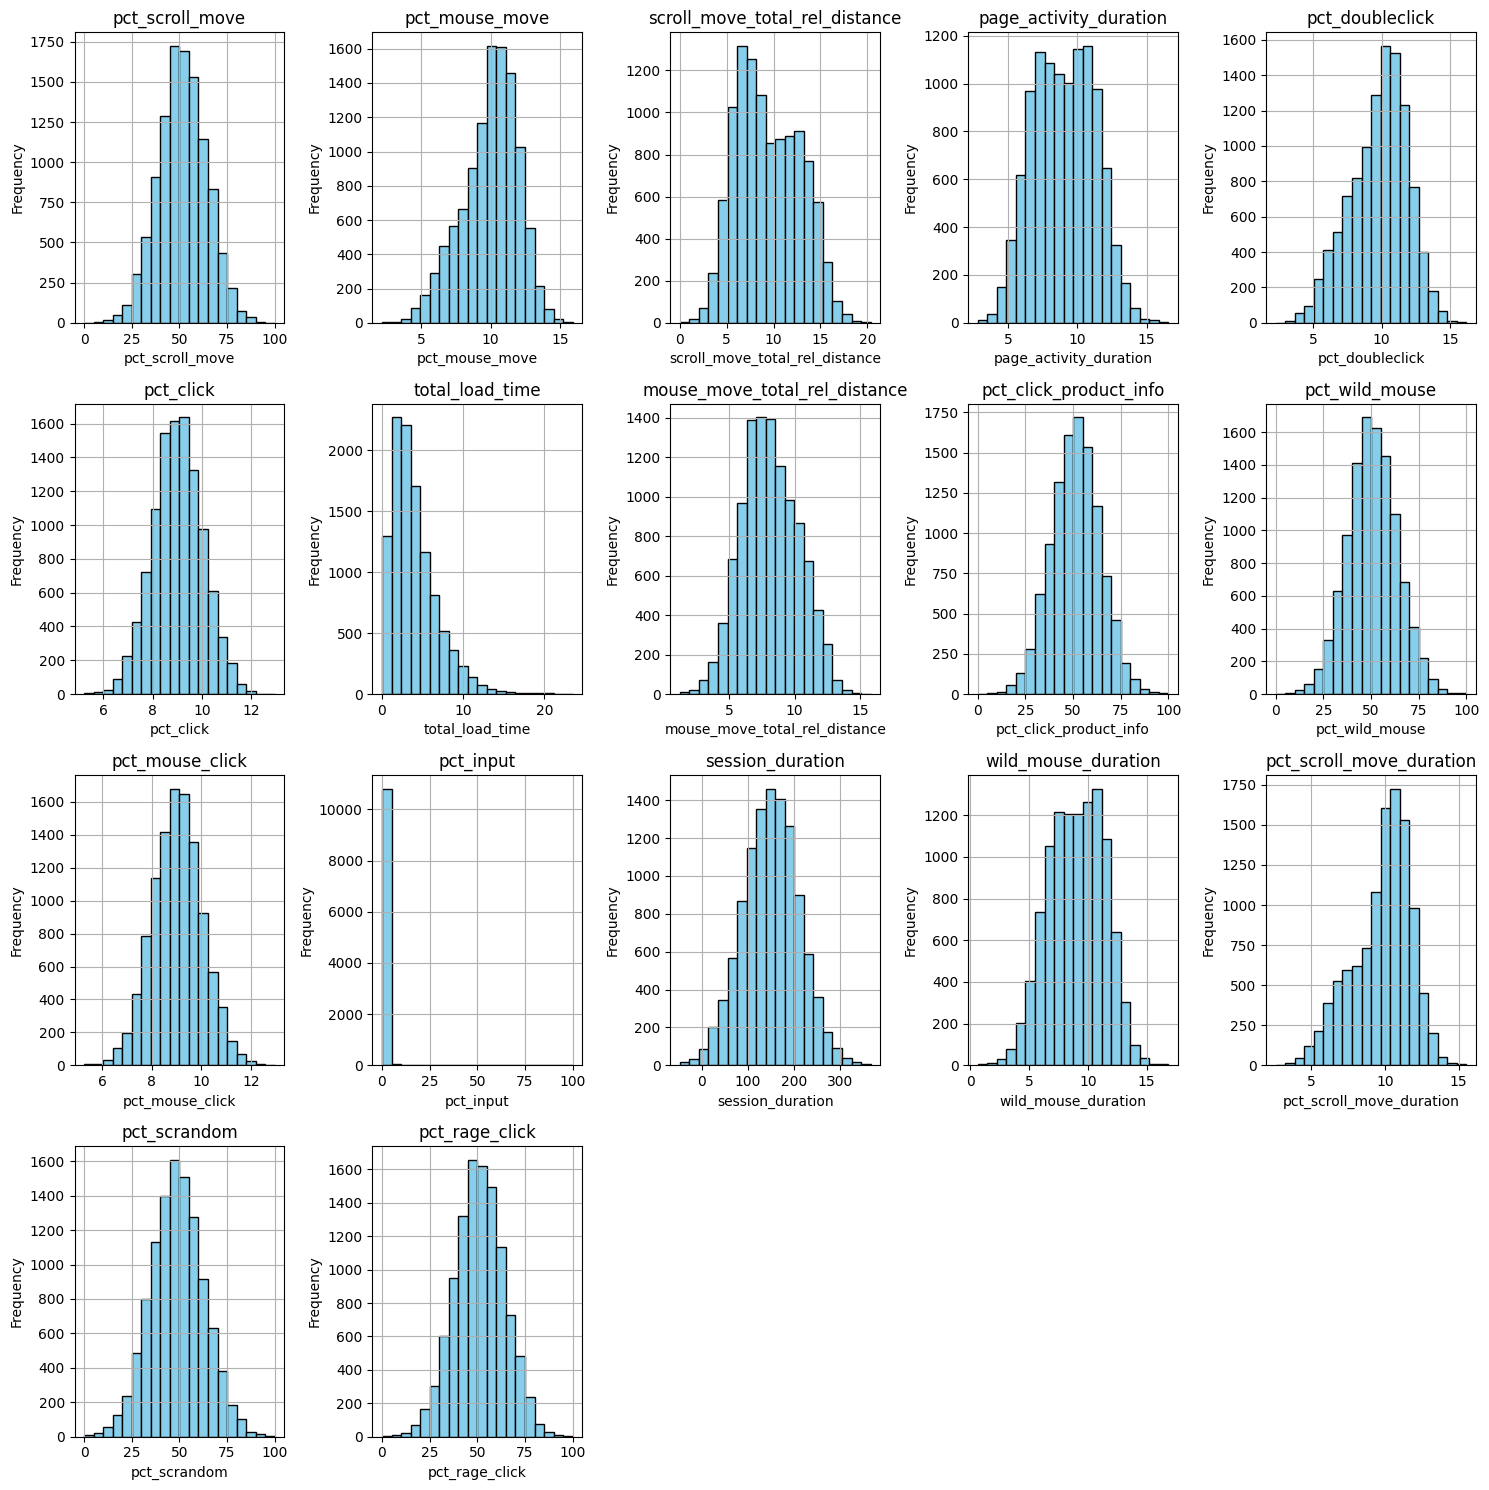

In [ ]:
num_columns = len(columns)
num_rows = int(np.ceil(num_columns / 5))
num_cols = min(5, num_columns) 

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axs = axs.flatten()

for i, column_name in enumerate(columns):
    axs[i].hist(sessions[column_name], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(column_name)
    axs[i].set_xlabel(column_name)
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

for i in range(num_columns, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


In [ ]:
sessions.describe()

pct_scroll_move  screen_width           ack  pct_mouse_move  \
count     10912.000000  10912.000000  10912.000000    10912.000000   
mean         51.597911   1298.397177      0.549487        9.958976   
std          12.582861    414.606975      0.497568        1.994431   
min           0.000000    800.000000      0.000000        2.165200   
25%          43.257508   1024.000000      0.000000        8.755600   
50%          51.501845   1280.000000      1.000000       10.227655   
75%          60.090293   1920.000000      1.000000       11.381730   
max         100.000000   1920.000000      1.000000       15.912470   

       scroll_move_total_rel_distance  page_activity_duration  \
count                    10912.000000            10912.000000   
mean                         9.436445                9.045979   
std                          3.366636                2.199447   
min                          0.000000                2.812950   
25%                          6.727070                7.306475   
50%                          9.023465                9.046640   
75%                         12.183375               10.748287   
max                         20.349730               16.572150   

       pct_doubleclick     pct_click  total_load_time  \
count     10912.000000  10912.000000     10912.000000   
mean          9.794251      9.009388         3.984017   
std           2.079046      1.001372         2.817457   
min           2.268070      5.214400         0.003570   
25%           8.404263      8.342427         1.913255   
50%          10.060755      9.012640         3.339890   
75%          11.279898      9.679443         5.354380   
max          16.180380     12.943650        23.487790   

       mouse_move_total_rel_distance   product_ean  pct_click_product_info  \
count                   10912.000000  1.091200e+04            10912.000000   
mean                        8.116084  4.976500e+12               51.341515   
std                         2.143902  2.896585e+12               12.703651   
min                         1.228680  1.234528e+09                0.000000   
25%                         6.595477  2.488811e+12               42.755845   
50%                         7.982980  4.968606e+12               51.322265   
75%                         9.645398  7.482085e+12               59.871335   
max                        15.791510  9.997623e+12              100.000000   

       screen_height  pct_wild_mouse  pct_mouse_click     pct_input  \
count   10912.000000    10912.000000     10912.000000  10912.000000   
mean      847.465543       50.732776         9.035542      0.385997   
std       187.388238       12.939001         1.001076      1.990747   
min       600.000000        0.000000         5.272990      0.000000   
25%       768.000000       42.062085         8.357748      0.014160   
50%       800.000000       50.542360         9.040600      0.051680   
75%      1080.000000       59.287085         9.705095      0.251232   
max      1080.000000      100.000000        12.965960    100.000000   

       session_duration  wild_mouse_duration  pct_scroll_move_duration  \
count      10912.000000         10912.000000              10912.000000   
mean         150.156130             9.026392                  9.801486   
std           60.380152             2.338910                  1.960188   
min          -47.247120             0.648860                  2.587140   
25%          109.037757             7.261398                  8.613705   
50%          151.104965             9.131100                 10.177305   
75%          190.967010            10.824608                 11.195362   
max          366.445590            16.845850                 15.529330   

       pct_scrandom  pct_rage_click    session_id       user_id  
count  10912.000000    10912.000000  1.091200e+04  10912.000000  
mean      48.814895       51.156387  7.477409e+05   1253.488087  
std       13.832647       13.008655  4.323119e+05    723.414795  
mi

In [ ]:
for column in columns:
    lower = sessions[column].quantile(0.01)
    higher = sessions[column].quantile(0.99)

    sessions[column] = sessions[column].apply(lambda x: lower if (x < lower) else higher if (x > higher) else x)

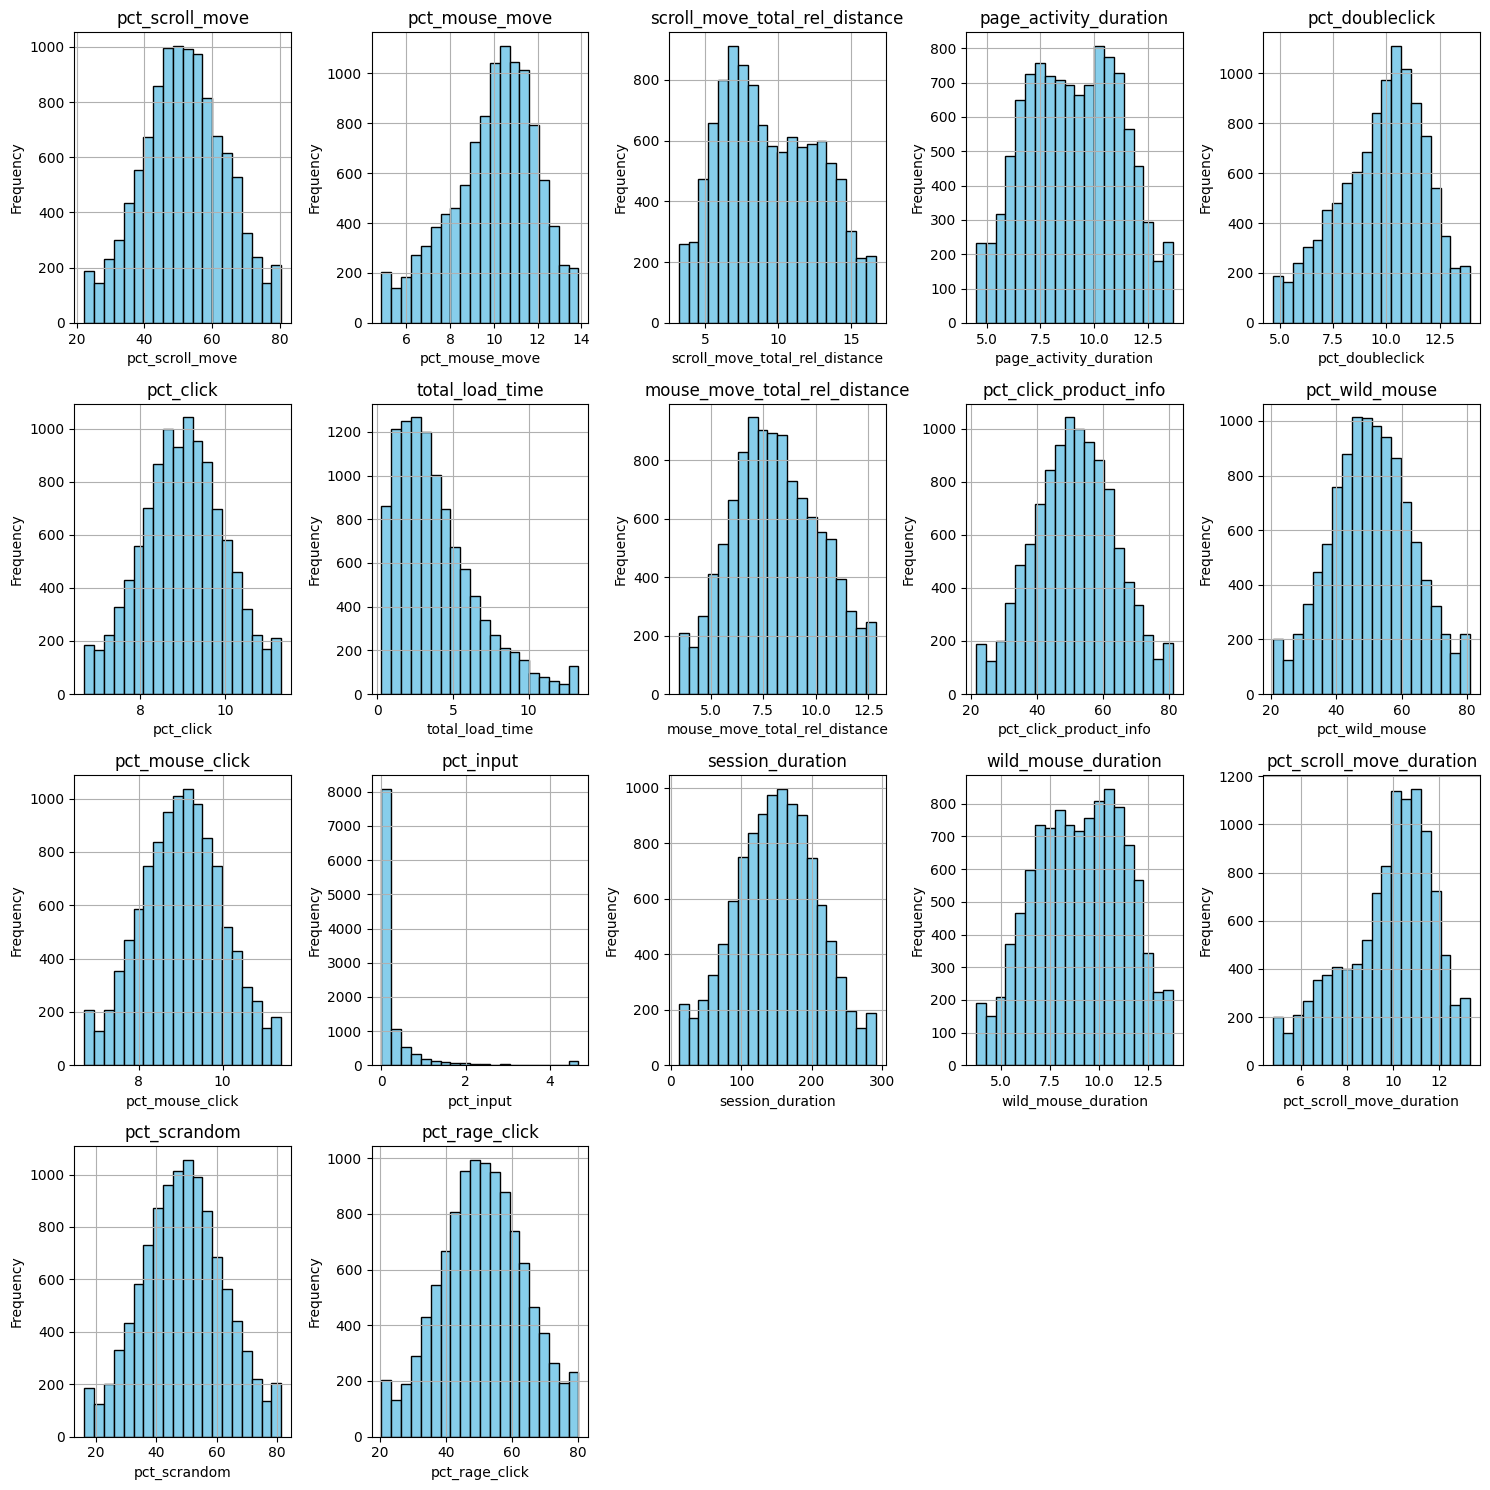

In [ ]:
num_columns = len(columns)
num_rows = int(np.ceil(num_columns / 5))
num_cols = min(5, num_columns) 

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axs = axs.flatten()

for i, column_name in enumerate(columns):
    axs[i].hist(sessions[column_name], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(column_name)
    axs[i].set_xlabel(column_name)
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

for i in range(num_columns, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

In [ ]:
sessions.describe()

pct_scroll_move  screen_width           ack  pct_mouse_move  \
count     10912.000000  10912.000000  10912.000000    10912.000000   
mean         51.594917   1298.397177      0.549487        9.959533   
std          12.332506    414.606975      0.497568        1.969259   
min          22.208387    800.000000      0.000000        4.864950   
25%          43.257508   1024.000000      0.000000        8.755600   
50%          51.501845   1280.000000      1.000000       10.227655   
75%          60.090293   1920.000000      1.000000       11.381730   
max          80.412053   1920.000000      1.000000       13.866308   

       scroll_move_total_rel_distance  page_activity_duration  \
count                    10912.000000            10912.000000   
mean                         9.435246                9.042378   
std                          3.333233                2.171710   
min                          3.164169                4.503068   
25%                          6.727070                7.306475   
50%                          9.023465                9.046640   
75%                         12.183375               10.748287   
max                         16.662361               13.660763   

       pct_doubleclick     pct_click  total_load_time  \
count     10912.000000  10912.000000     10912.000000   
mean          9.795359      9.010031         3.960801   
std           2.054206      0.985643         2.715800   
min           4.701713      6.678065         0.279456   
25%           8.404263      8.342427         1.913255   
50%          10.060755      9.012640         3.339890   
75%          11.279898      9.679443         5.354380   
max          13.929914     11.319384        13.288524   

       mouse_move_total_rel_distance   product_ean  pct_click_product_info  \
count                   10912.000000  1.091200e+04            10912.000000   
mean                        8.116079  4.976500e+12               51.340235   
std                         2.115439  2.896585e+12               12.479225   
min                         3.485567  1.234528e+09               21.497307   
25%                         6.595477  2.488811e+12               42.755845   
50%                         7.982980  4.968606e+12               51.322265   
75%                         9.645398  7.482085e+12               59.871335   
max                        12.849171  9.997623e+12               81.118102   

       screen_height  pct_wild_mouse  pct_mouse_click     pct_input  \
count   10912.000000    10912.000000     10912.000000  10912.000000   
mean      847.465543       50.731397         9.035455      0.306044   
std       187.388238       12.692580         0.983672      0.698842   
min       600.000000       20.632892         6.704577      0.004121   
25%       768.000000       42.062085         8.357748      0.014160   
50%       800.000000       50.542360         9.040600      0.051680   
75%      1080.000000       59.287085         9.705095      0.251232   
max      1080.000000       80.883925        11.397359      4.679090   

       session_duration  wild_mouse_duration  pct_scroll_move_duration  \
count      10912.000000         10912.000000              10912.000000   
mean         150.135585             9.027459                  9.801606   
std           59.366255             2.301635                  1.933533   
min           11.269987             3.732695                  4.812080   
25%          109.037757             7.261398                  8.613705   
50%          151.104965             9.131100                 10.177305   
75%          190.967010            10.824608                 11.195362   
max          291.033489            13.782217                 13.352144   

       pct_scrandom  pct_rage_click    session_id       user_id  
count  10912.000000    10912.000000  1.091200e+04  10912.000000  
mean      48.816609       51.153963  7.477409e+05   1253.488087  
std       13.617304       12.765770  4.323119e+05    723.414795  
mi

S sessions.describe() vidíme, že po tomto čistení sa nam v niektorých prípadoch zmenili min a max hodnoty pre niektoré sĺpce - teda došlo k odstráneniu/nahradeniu výchyliek. Trochu sa posunuli priemery, ale rozdelenia nam ostali rovnaké.

Teraz ešte môžeme skúsiť outlierov odstrániť a pozrieť sa, ako bude vyzerať výsledný dataset. Pri odstraňovaní použijeme hranice 5% a 95% percent a hodnoty za týmito hranicami odstránime:

In [ ]:
session_test_out_drop = sessions_test.copy()

session_test_out_drop.describe()

pct_scroll_move           ack  pct_mouse_move  \
count     10748.000000  10748.000000    10748.000000   
mean         51.621241      0.549777        9.961318   
std          12.604536      0.497539        1.994567   
min           0.000000      0.000000        2.165200   
25%          43.265098      0.000000        8.763448   
50%          51.513265      1.000000       10.234095   
75%          60.107530      1.000000       11.382248   
max         100.000000      1.000000       15.912470   

       scroll_move_total_rel_distance  page_activity_duration  \
count                    10748.000000            10748.000000   
mean                         9.443796                9.042292   
std                          3.366707                2.202649   
min                          0.000000                2.812950   
25%                          6.738333                7.299475   
50%                          9.034645                9.046140   
75%                         12.194995               10.748207   
max                         20.349730               16.572150   

       pct_doubleclick     pct_click  total_load_time  \
count     10748.000000  10748.000000     10748.000000   
mean          9.797642      9.007676         3.980967   
std           2.080856      1.001727         2.818126   
min           2.268070      5.214400         0.003570   
25%           8.404848      8.341732         1.909233   
50%          10.066095      9.013240         3.336395   
75%          11.286070      9.676678         5.352380   
max          16.180380     12.943650        23.487790   

       mouse_move_total_rel_distance   product_ean  pct_click_product_info  \
count                   10748.000000  1.074800e+04            10748.000000   
mean                        8.119535  4.984735e+12               51.347635   
std                         2.147411  2.897695e+12               12.716100   
min                         1.228680  1.234528e+09                0.000000   
25%                         6.597717  2.496424e+12               42.757655   
50%                         7.985295  4.979525e+12               51.317490   
75%                         9.653987  7.499176e+12               59.881825   
max                        15.791510  9.997623e+12              100.000000   

       pct_wild_mouse  pct_mouse_click     pct_input  session_duration  \
count    10748.000000     10748.000000  10748.000000      10748.000000   
mean        50.713369         9.034537      0.387973        150.111406   
std         12.925951         1.001203      2.004966         60.459558   
min          0.000000         5.272990      0.000000        -47.247120   
25%         42.019420         8.356220      0.014095        108.860533   
50%         50.515095         9.039850      0.051205        151.081595   
75%         59.278415         9.705030      0.249717        190.977958   
max        100.000000        12.965960    100.000000        366.445590   

       wild_mouse_duration  session_start  pct_scroll_move_duration  \
count         10748.000000   1.074800e+04              10748.000000   
mean              9.026120   1.616662e+09                  9.805509   
std               2.339266   4.539015e+07                  1.961024   
min               0.648860   1.537696e+09                  2.587140   
25%               7.256168   1.577450e+09                  8.614865   
50%               9.128955   1.617250e+09                 10.180760   
75%              10.826460   1.656032e+09                 11.197340   
max              16.845850   1.695450e+09                 15.529330   

       pct_scrandom  pct_rage_click    session_id       user_id  
count  10748.000000    10748.000000  1.074800e+04  10748.000000  
mean      48.826123       51.148224  7.472435e+05   1252.680127  
std       13.860989       13.005513  4.326662e+05    723.070051  
min        0.000000        0.000000  1.249000e+03      0.000000  
25%       39.465562       42.549657  3.685118e+05    624.00000

In [ ]:
for column in columns:
    lower = session_test_out_drop[column].quantile(0.05)
    higher = session_test_out_drop[column].quantile(0.95)

    session_test_out_drop = session_test_out_drop[(session_test_out_drop[column] >= lower) & (session_test_out_drop[column] <= higher)]

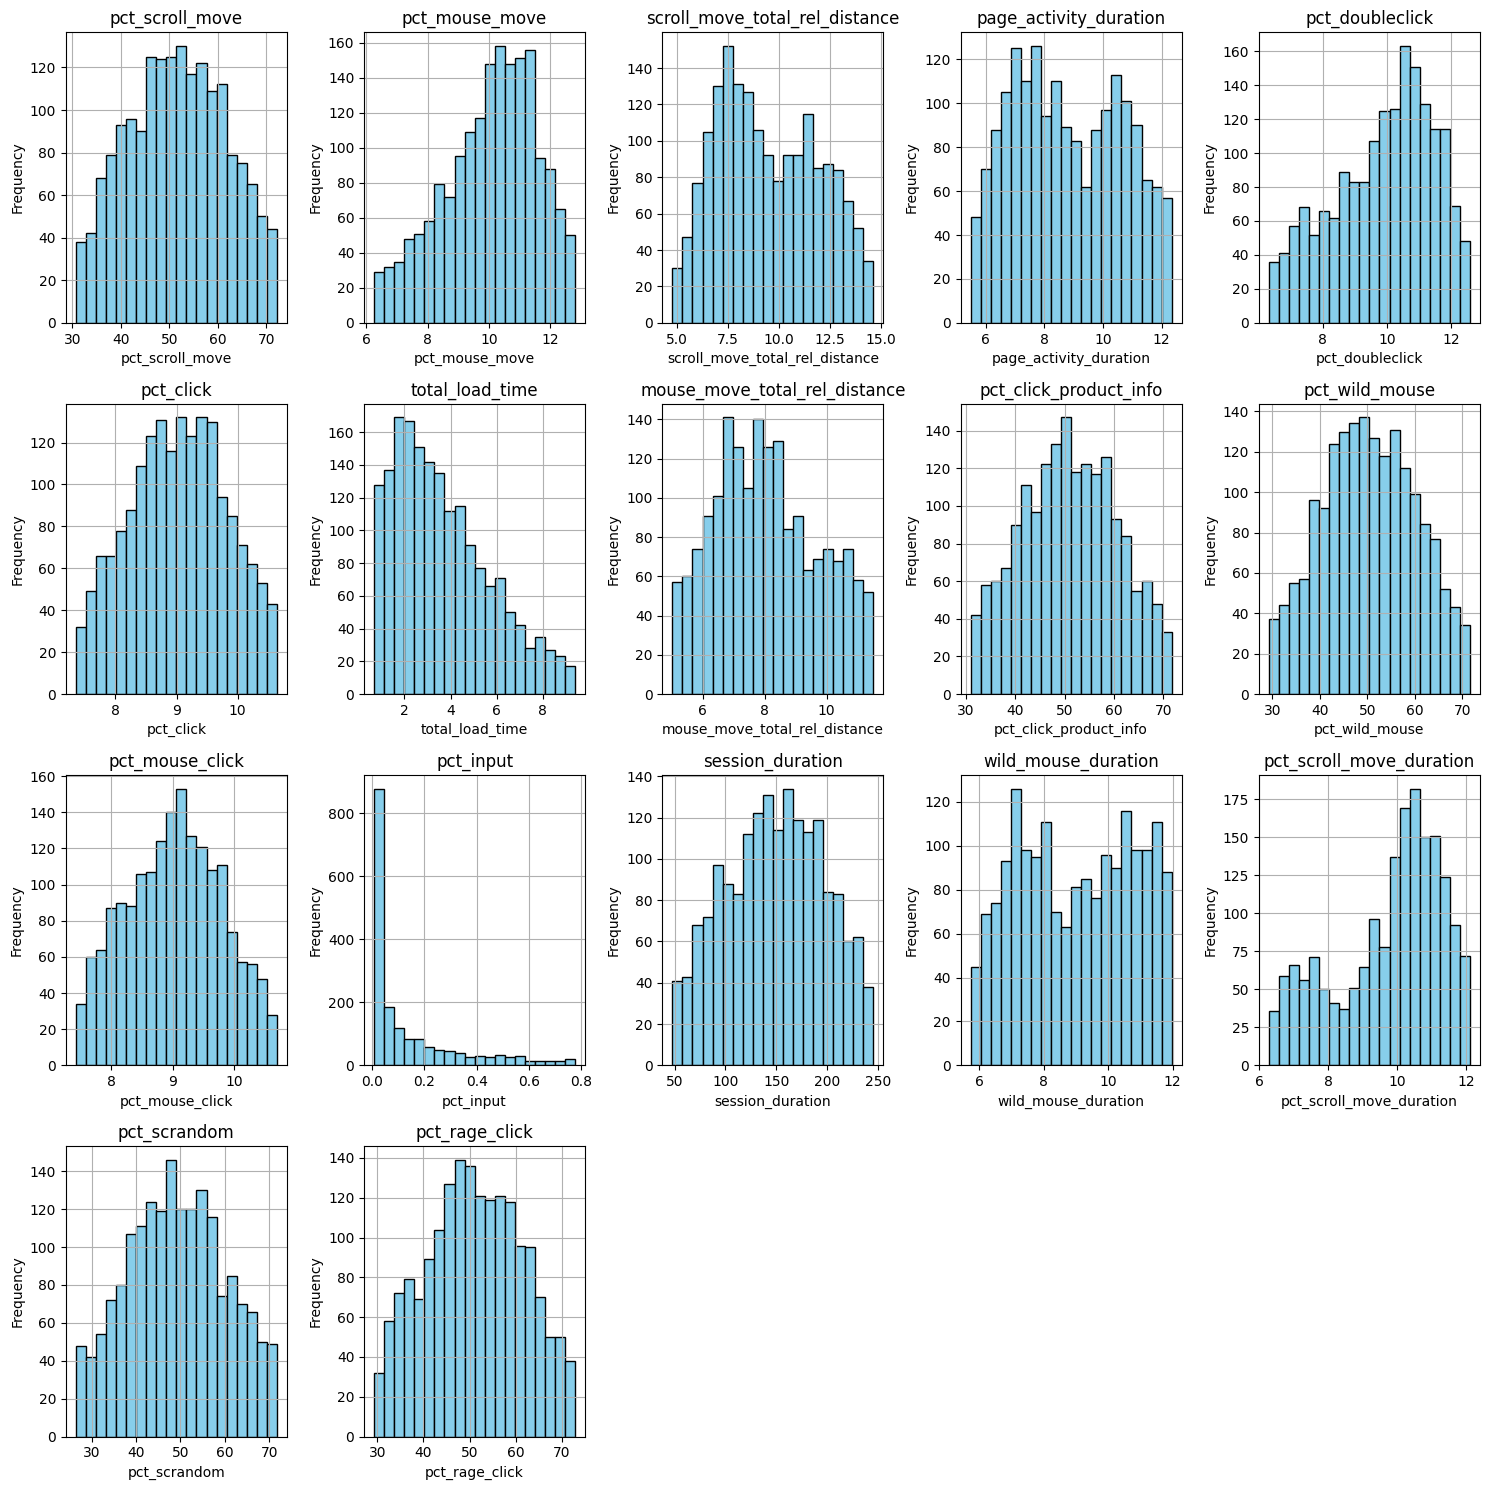

In [ ]:
num_columns = len(columns)
num_rows = int(np.ceil(num_columns / 5))
num_cols = min(5, num_columns) 

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axs = axs.flatten()

for i, column_name in enumerate(columns):
    axs[i].hist(session_test_out_drop[column_name], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(column_name)
    axs[i].set_xlabel(column_name)
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

for i in range(num_columns, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


In [ ]:
session_test_out_drop.describe()

pct_scroll_move          ack  pct_mouse_move  \
count      1783.000000  1783.000000     1783.000000   
mean         51.638767     0.568704       10.029683   
std          10.040497     0.495396        1.518595   
min          30.748790     0.000000        6.251020   
25%          44.073650     0.000000        9.041770   
50%          51.747050     1.000000       10.219160   
75%          59.414605     1.000000       11.184405   
max          72.174200     1.000000       12.815490   

       scroll_move_total_rel_distance  page_activity_duration  \
count                     1783.000000             1783.000000   
mean                         9.475623                8.801467   
std                          2.470251                1.845212   
min                          4.777960                5.480200   
25%                          7.416455                7.216790   
50%                          9.149810                8.609290   
75%                         11.505450               10.421785   
max                         14.633730               12.341130   

       pct_doubleclick    pct_click  total_load_time  \
count      1783.000000  1783.000000      1783.000000   
mean          9.883352     9.025856         3.683396   
std           1.559703     0.787934         2.060000   
min           6.328690     7.352140         0.685340   
25%           8.777610     8.433570         2.034835   
50%          10.136040     9.038170         3.284190   
75%          11.114040     9.611900         5.003755   
max          12.587980    10.641710         9.398860   

       mouse_move_total_rel_distance   product_ean  pct_click_product_info  \
count                    1783.000000  1.783000e+03             1783.000000   
mean                        8.079943  4.977342e+12               51.009982   
std                         1.655237  2.872551e+12                9.727543   
min                         5.021880  1.278655e+10               30.947410   
25%                         6.787965  2.470787e+12               43.585520   
50%                         7.929490  4.996253e+12               50.849710   
75%                         9.304420  7.441757e+12               58.296380   
max                        11.512930  9.993825e+12               71.725910   

       pct_wild_mouse  pct_mouse_click    pct_input  session_duration  \
count     1783.000000      1783.000000  1783.000000       1783.000000   
mean        50.394729         9.024293     0.140478        148.487563   
std          9.883949         0.773917     0.183755         48.204779   
min         29.254070         7.419560     0.007400         47.892550   
25%         43.134750         8.441715     0.015300        111.124025   
50%         50.175890         9.048470     0.049130        148.646170   
75%         57.891630         9.598800     0.194155        186.138890   
max         71.590980        10.693940     0.775720        245.482810   

       wild_mouse_duration  session_start  pct_scroll_move_duration  \
count          1783.000000   1.783000e+03               1783.000000   
mean              9.003606   1.618421e+09                  9.766662   
std               1.770230   4.553821e+07                  1.528083   
min               5.736470   1.537986e+09                  6.286790   
25%               7.404485   1.579127e+09                  8.754045   
50%               9.067010   1.619729e+09                 10.165760   
75%              10.569775   1.658502e+09                 10.937335   
max              11.972390   1.695315e+09                 12.119890   

       pct_scrandom  pct_rage_click    session_id      user_id  
count   1783.000000     1783.000000  1.783000e+03  1783.000000  
mean      49.147113       51.032157  7.676402e+05  1238.321929  
std       10.920713       10.412814  4.307272e+05   715.001758  
min       26.466410       29.309930  1.370000e+03     0.000000  
25%       41.087320       43.463590  4.079925e+05   620.500000  
50%       48.897760       50.

Ako opäť môžeme vidieť, dátam sa opäť zmenili napr. hodnoty min a max, čo naznačuje ich oklieštenie.

<h2>User_id duplicita</h2>
Kvôli nekonzistentnosti medzi user_id v sessions a users nemôžeme tieto tabuľky spojiť (ako sme zistili v fáze 1, v users sa niektoré ID opakujú - nevieme jednoznačne priradiť záznamy medzi tymito tabuľkami).
Pozrieme sa na to bližšie.

In [ ]:
duplicates_mask = users.duplicated(subset='user_id', keep=False)
duplicated_ids = users.loc[duplicates_mask, 'user_id'].unique()

print("Percento duplicitných ID: {:.2f}%" .format(len(duplicated_ids)/len(users)*100))


Percento duplicitných ID: 26.00%


Ak by sme chceli tabuľky sessions a users spojiť, jedným z riešení by bolo odstrániť záznamy s viacznačným ID z obidvoch tabuliek. Pozrieme sa, koľko riadkov by sme mudeli odstrániť zo sessions. Ak ten počet bude nízky, môžeme to zvážiť.

In [ ]:
rows_with_duplicated_ids = sessions[sessions['user_id'].isin(duplicated_ids)]
print("Pocet zaznamov v session s duplicitnymi ID: ", len(rows_with_duplicated_ids))
print("Percento zaznamov, ktore by sme mali vymazat: {:.2f}%" .format(len(rows_with_duplicated_ids)/len(sessions)*100))

Pocet zaznamov v session s duplicitnymi ID:  2783
Percento zaznamov, ktore by sme mali vymazat: 25.50%


Nemôžeme odstrániť 1/4 dát, čiže túto možnosť zamietame a spájať tabuľky nebudeme. Ďalej teda budeme pokračovať len s datasetom sessions, ktorý obsahuje predikovanú premennú <b>ack</b>. Tomuto datasetu boli chýbajúce hodnoty doplnené strednou hodnotou, jeho atribúty boli prevedené na číselné hodnoty a vychýlené hodnoty boli riešené tak, že sme ich nahradili hraničnými hodnotami s dolnou hranicou %1 a hornou hranicou 99%.

In [ ]:
sessions = sessions.assign(session_start = pd.to_datetime(sessions['session_start']))
sessions['session_start'] = (sessions['session_start'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [ ]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10912 entries, 0 to 10911
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pct_scroll_move                 10912 non-null  float64
 1   screen_width                    10912 non-null  int64  
 2   ack                             10912 non-null  float64
 3   pct_mouse_move                  10912 non-null  float64
 4   scroll_move_total_rel_distance  10912 non-null  float64
 5   page_activity_duration          10912 non-null  float64
 6   pct_doubleclick                 10912 non-null  float64
 7   pct_click                       10912 non-null  float64
 8   total_load_time                 10912 non-null  float64
 9   mouse_move_total_rel_distance   10912 non-null  float64
 10  product_ean                     10912 non-null  int64  
 11  pct_click_product_info          10912 non-null  float64
 12  screen_height                   

<h1>Realizácia predspracovania dát</h1>
Dataset sme sa rozhodli rozdeliť na trénovaciu a testovaciu množinu v pomere 1:3, teda 75% a 25%. Keďže prepojiť users a sessions sa nedá a products nemajú žiadné užitočné údaje pre nás, tak budeme trénovať model len na dátach z tabuľky sessions.

In [ ]:
train_set, test_set = train_test_split(sessions, test_size=0.25)
print("Trenovaci dataset ma", len(train_set), "zaznamov.\nTestovaci dataset ma", len(test_set), "zaznamov.")

Trenovaci dataset ma 8184 zaznamov.
Testovaci dataset ma 2728 zaznamov.


Zaujímať nás budú tieto stĺpce:

In [ ]:
train_cols = ["pct_scroll_move", "ack", "pct_mouse_move", "scroll_move_total_rel_distance", "page_activity_duration", "pct_doubleclick", "pct_click", "total_load_time", "mouse_move_total_rel_distance", "pct_click_product_info", "pct_wild_mouse", "pct_mouse_click", "pct_input", "session_duration", "wild_mouse_duration", "pct_scroll_move_duration", "pct_scrandom", "pct_rage_click"]

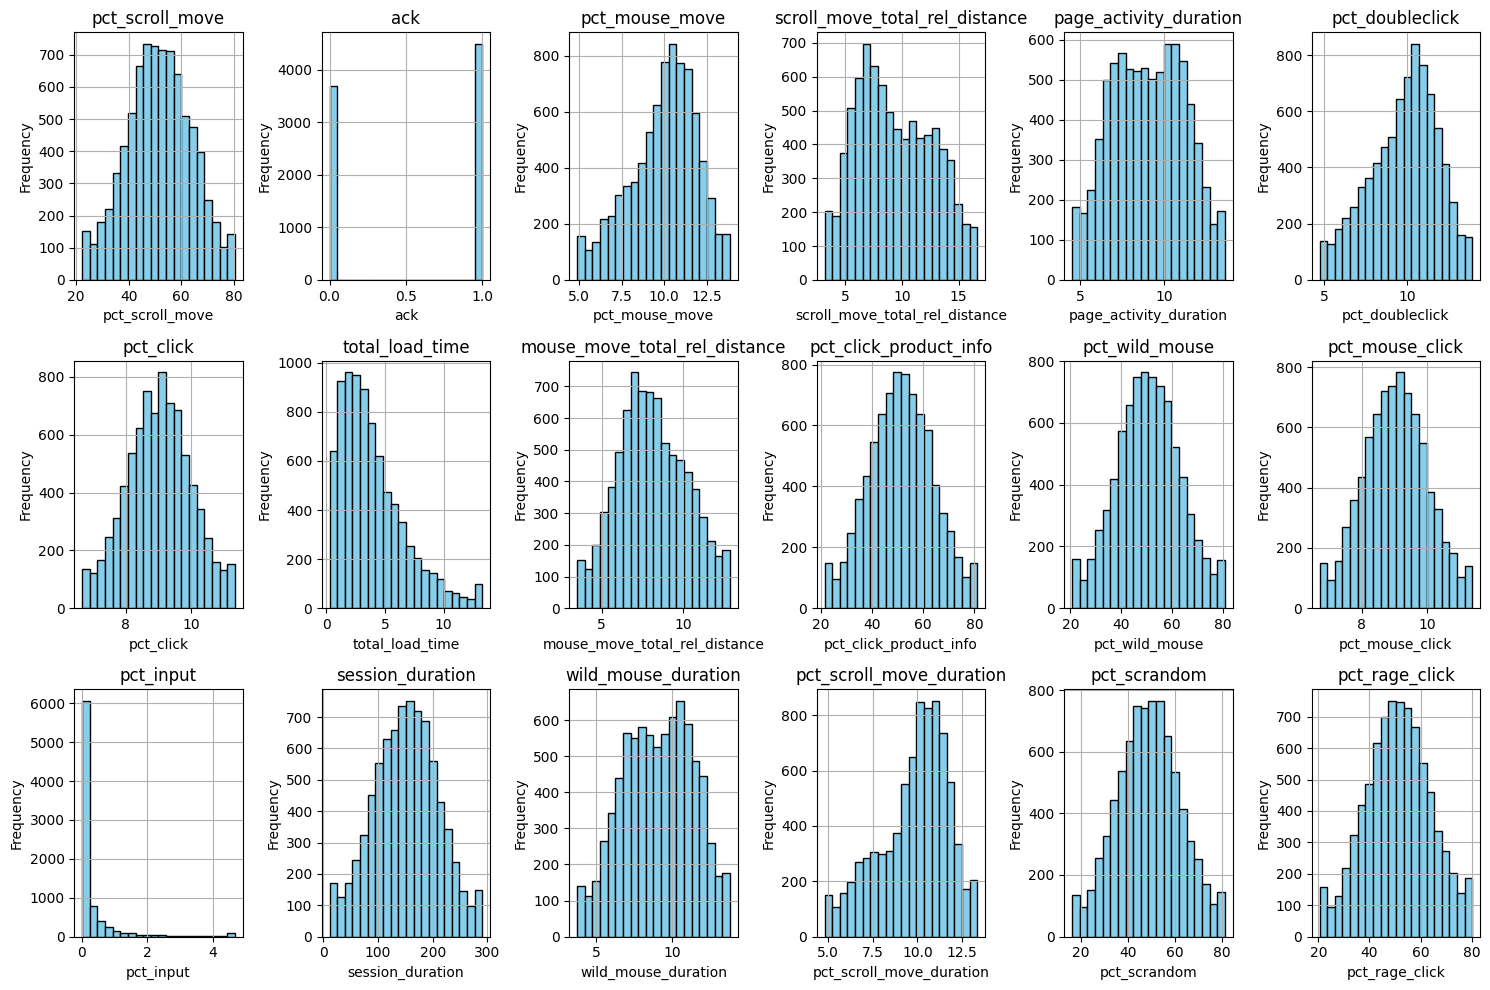

In [ ]:
num_rows = 3
num_cols = 6

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10)) 
axs = axs.flatten()

for i, column_name in enumerate(train_cols):
    axs[i].hist(train_set[column_name], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(column_name)
    axs[i].set_xlabel(column_name)
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

Pri Machine learningu dostávame lepšie výsledky, keď sa dáta približujú k normálnemu rozdeleniu. Preto sa teraz pozrieme, ktoré atribúty by mohli byť z normálneho rozdelenia

ShapiroResult(statistic=0.9955884218215942, pvalue=4.170846983487641e-15) 



c:\Users\jakub\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


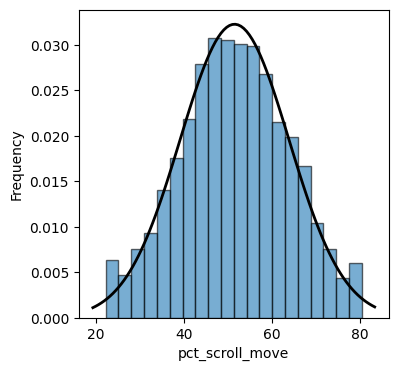

In [ ]:
print(stats.shapiro(train_set['pct_scroll_move']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_scroll_move'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_scroll_move'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_scroll_move')
ax.set_ylabel('Frequency')

plt.show()

Premenná <b>ack</b> je kategorická, lebo má len dve hodnoty, buď 1 alebo 0 a tým pádom ju nie je potrebné upravovať

<AxesSubplot: >

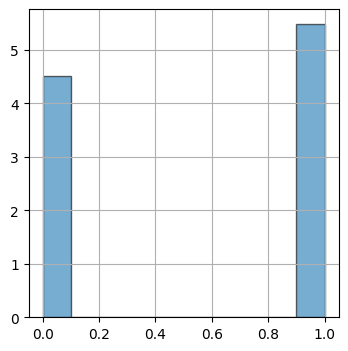

In [ ]:
fig = plt.figure(figsize = (4,4))
ax = fig.gca()
train_set['ack'].hist(ax = ax, density=True, alpha=0.6, edgecolor='black')

ShapiroResult(statistic=0.9764347672462463, pvalue=1.1685756941304848e-34) 



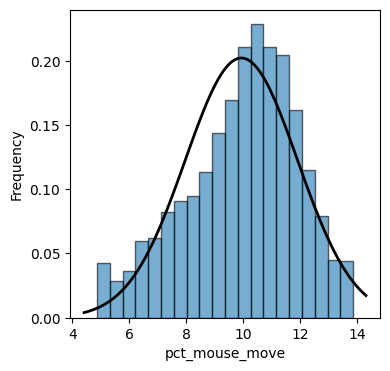

In [ ]:
print(stats.shapiro(train_set['pct_mouse_move']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_mouse_move'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_mouse_move'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_mouse_move')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9716247916221619, pvalue=2.357422118946229e-37) 



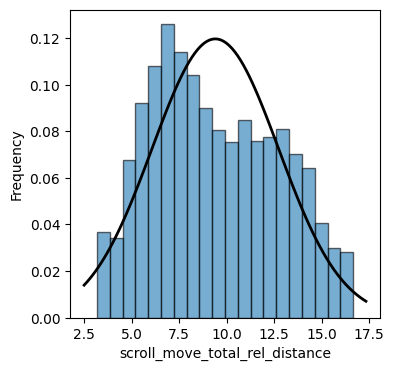

In [ ]:
print(stats.shapiro(train_set['scroll_move_total_rel_distance']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['scroll_move_total_rel_distance'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['scroll_move_total_rel_distance'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('scroll_move_total_rel_distance')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9837020635604858, pvalue=1.2751856004951856e-29) 



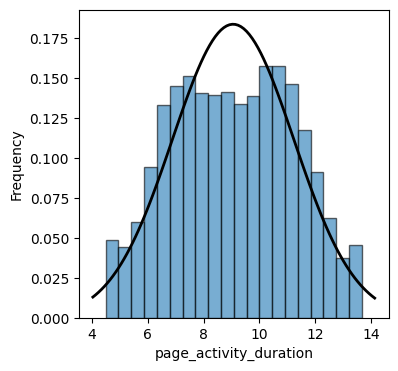

In [ ]:
print(stats.shapiro(train_set['page_activity_duration']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['page_activity_duration'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['page_activity_duration'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('page_activity_duration')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9809327721595764, pvalue=1.028623972400323e-31) 



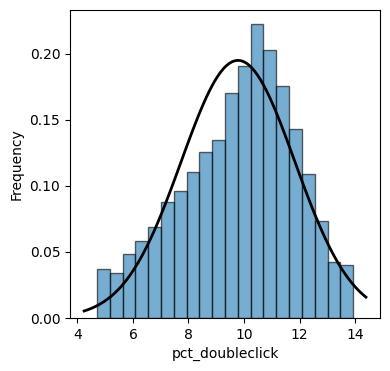

In [ ]:
print(stats.shapiro(train_set['pct_doubleclick']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_doubleclick'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_doubleclick'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_doubleclick')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9958102703094482, pvalue=1.2209705495995829e-14) 



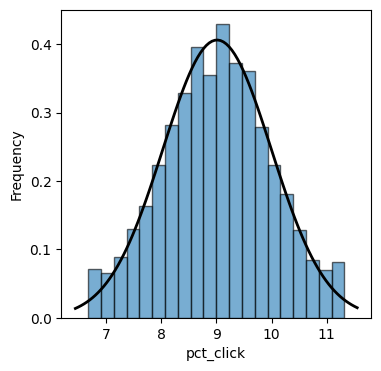

In [ ]:
print(stats.shapiro(train_set['pct_click']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_click'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_click'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_click')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9111022353172302, pvalue=0.0) 



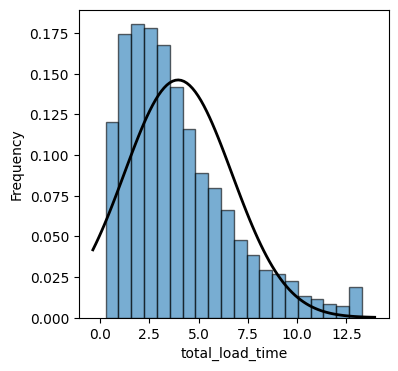

In [ ]:
print(stats.shapiro(train_set['total_load_time']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['total_load_time'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['total_load_time'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('total_load_time')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9897241592407227, pvalue=6.648995392328536e-24) 



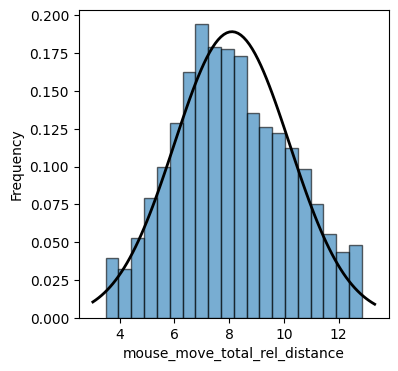

In [ ]:
print(stats.shapiro(train_set['mouse_move_total_rel_distance']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['mouse_move_total_rel_distance'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['mouse_move_total_rel_distance'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('mouse_move_total_rel_distance')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9960683584213257, pvalue=4.471054941752352e-14) 



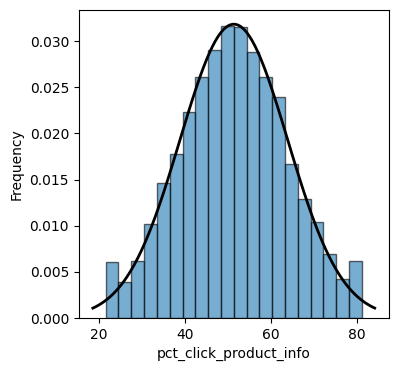

In [ ]:
print(stats.shapiro(train_set['pct_click_product_info']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_click_product_info'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_click_product_info'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_click_product_info')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.996042013168335, pvalue=3.9061635870307754e-14) 



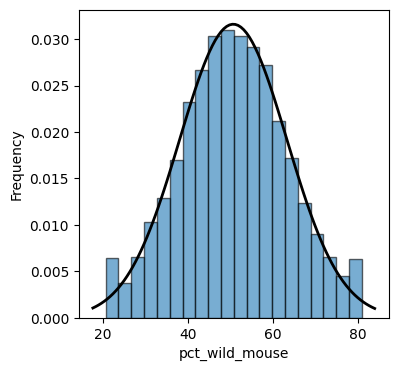

In [ ]:
print(stats.shapiro(train_set['pct_wild_mouse']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_wild_mouse'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_wild_mouse'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_wild_mouse')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9960546493530273, pvalue=4.167450211962562e-14) 



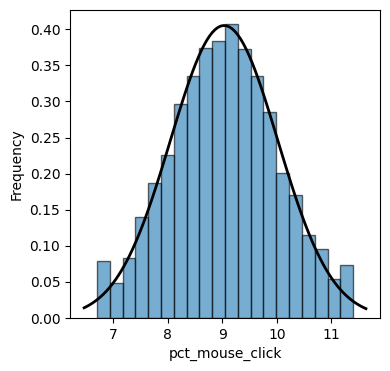

In [ ]:
print(stats.shapiro(train_set['pct_mouse_click']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_mouse_click'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_mouse_click'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_mouse_click')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.4555659890174866, pvalue=0.0) 



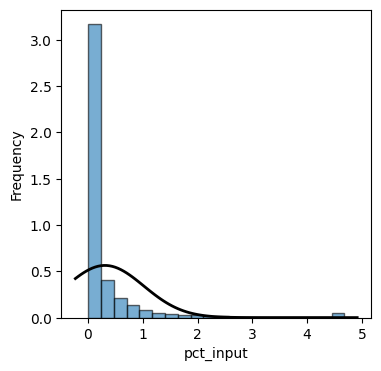

In [ ]:
print(stats.shapiro(train_set['pct_input']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_input'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_input'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_input')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9955308437347412, pvalue=3.1747264966376903e-15) 



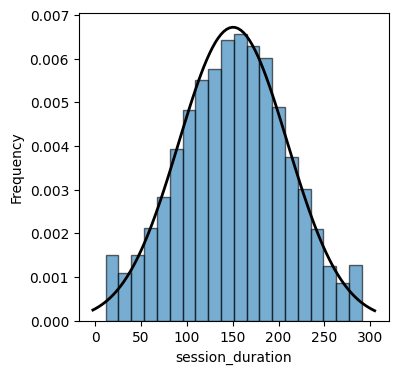

In [ ]:
print(stats.shapiro(train_set['session_duration']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['session_duration'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['session_duration'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('session_duration')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9869963526725769, pvalue=9.675781136708098e-27) 



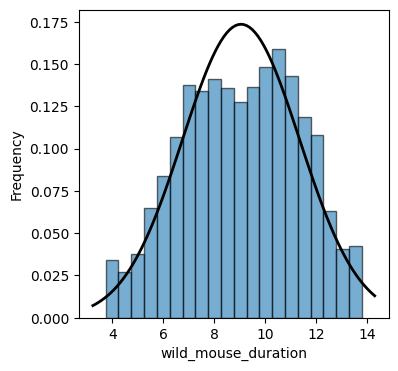

In [ ]:
print(stats.shapiro(train_set['wild_mouse_duration']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['wild_mouse_duration'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['wild_mouse_duration'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('wild_mouse_duration')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9610068202018738, pvalue=3.2734332126627727e-42) 



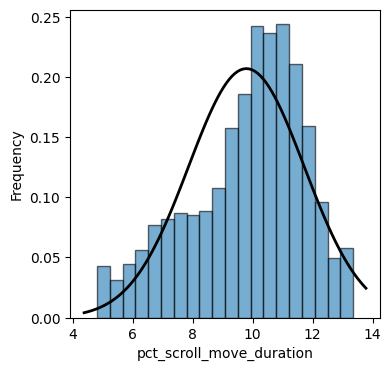

In [ ]:
print(stats.shapiro(train_set['pct_scroll_move_duration']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_scroll_move_duration'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_scroll_move_duration'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_scroll_move_duration')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9963259100914001, pvalue=1.728641508364978e-13) 



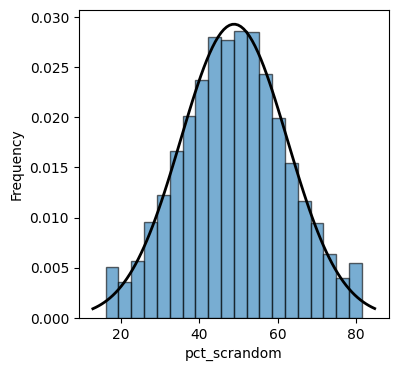

In [ ]:
print(stats.shapiro(train_set['pct_scrandom']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_scrandom'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_scrandom'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_scrandom')
ax.set_ylabel('Frequency')

plt.show()

ShapiroResult(statistic=0.9952912330627441, pvalue=1.0453075842178894e-15) 



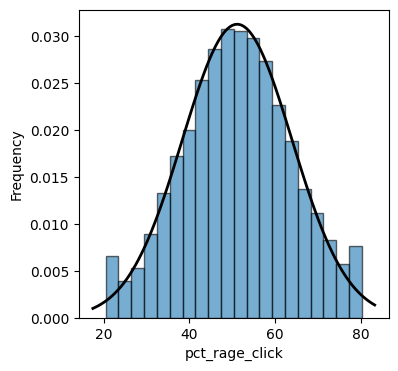

In [ ]:
print(stats.shapiro(train_set['pct_rage_click']), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_rage_click'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_rage_click'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_rage_click')
ax.set_ylabel('Frequency')

plt.show()

Z predchádzajúcich testov a grafov sme dospeli k nasledovnému rozdeleniu distribúcií jednotlivých atribútov:

In [ ]:
normal = ['pct_scroll_move', 'pct_mouse_move', 'scroll_move_total_rel_distance', 'page_activity_duration', 'pct_doubleclick', 'pct_click', 'mouse_move_total_rel_distance', 'pct_click_product_info', 'pct_wild_mouse', 'pct_mouse_click', 'session_duration', 'wild_mouse_duration', 'pct_scroll_move_duration', 'pct_scrandom', 'pct_rage_click']
skewed = ['total_load_time', 'pct_input']
categorical = ['ack']

Atribúty <b>total_load_time</b> a <b> pct_input</b> sú vychýlené, preto sa ich pokúsime quantilovou transformáciou priblížiť normálnemu rozdeleniu:

C:\Users\jakub\AppData\Local\Temp\ipykernel_12820\203632207.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_set[skewed].hist(ax = ax, bins=50, density=True, alpha=0.6, edgecolor='black')


array([[<AxesSubplot: title={'center': 'total_load_time'}>,
        <AxesSubplot: title={'center': 'pct_input'}>]], dtype=object)

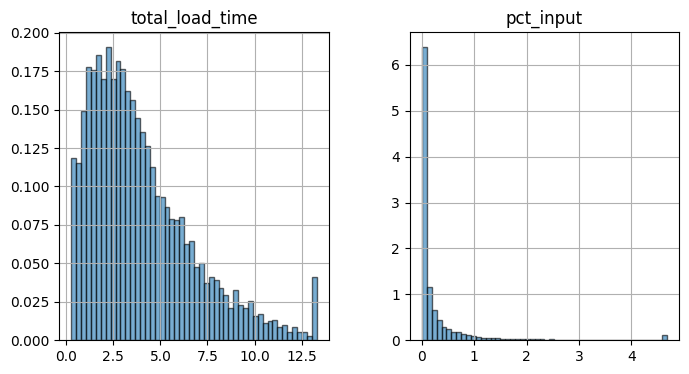

In [ ]:
fig = plt.figure(figsize = (8,4))
ax = fig.gca()
train_set[skewed].hist(ax = ax, bins=50, density=True, alpha=0.6, edgecolor='black')

C:\Users\jakub\AppData\Local\Temp\ipykernel_12820\2290829769.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_set[skewed].hist(ax = ax, bins=50, density=True, alpha=0.6, edgecolor='black')


array([[<AxesSubplot: title={'center': 'total_load_time'}>,
        <AxesSubplot: title={'center': 'pct_input'}>]], dtype=object)

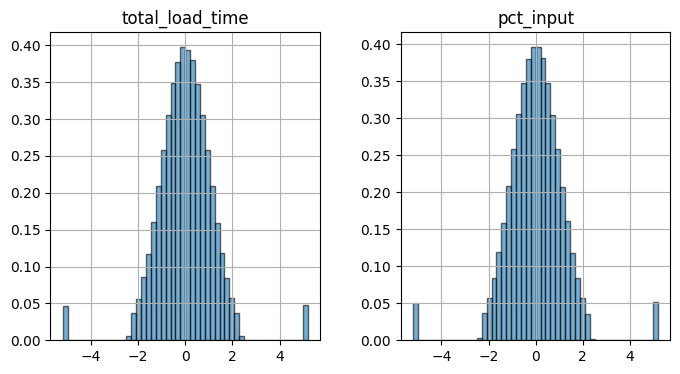

In [ ]:
qt = QuantileTransformer(output_distribution="normal")
train_set[skewed] = qt.fit_transform(train_set[skewed])
fig = plt.figure(figsize = (8,4))
ax = fig.gca()
train_set[skewed].hist(ax = ax, bins=50, density=True, alpha=0.6, edgecolor='black')

KstestResult(statistic=0.010874777810361946, pvalue=0.2857214454613689, statistic_location=5.19933758270342, statistic_sign=-1) 



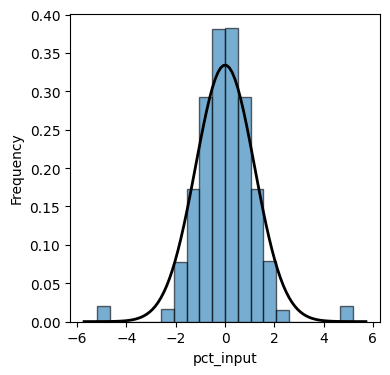

In [ ]:
print(stats.kstest(train_set['pct_input'], 'norm'), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_input'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_input'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_input')
ax.set_ylabel('Frequency')

plt.show()

KstestResult(statistic=0.010019450342131253, pvalue=0.38143858864040414, statistic_location=5.19933758270342, statistic_sign=-1) 



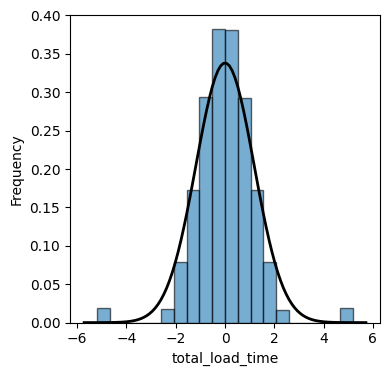

In [ ]:
print(stats.kstest(train_set['total_load_time'], 'norm'), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['total_load_time'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['total_load_time'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('total_load_time')
ax.set_ylabel('Frequency')

plt.show()

Teraz dáta, ktoré vyzerajú, že by mohli byť z normálneho rozdelenia ešte transformujeme pomocou PowerTransformer, aby sa k nemu ešte lepšie priblížili

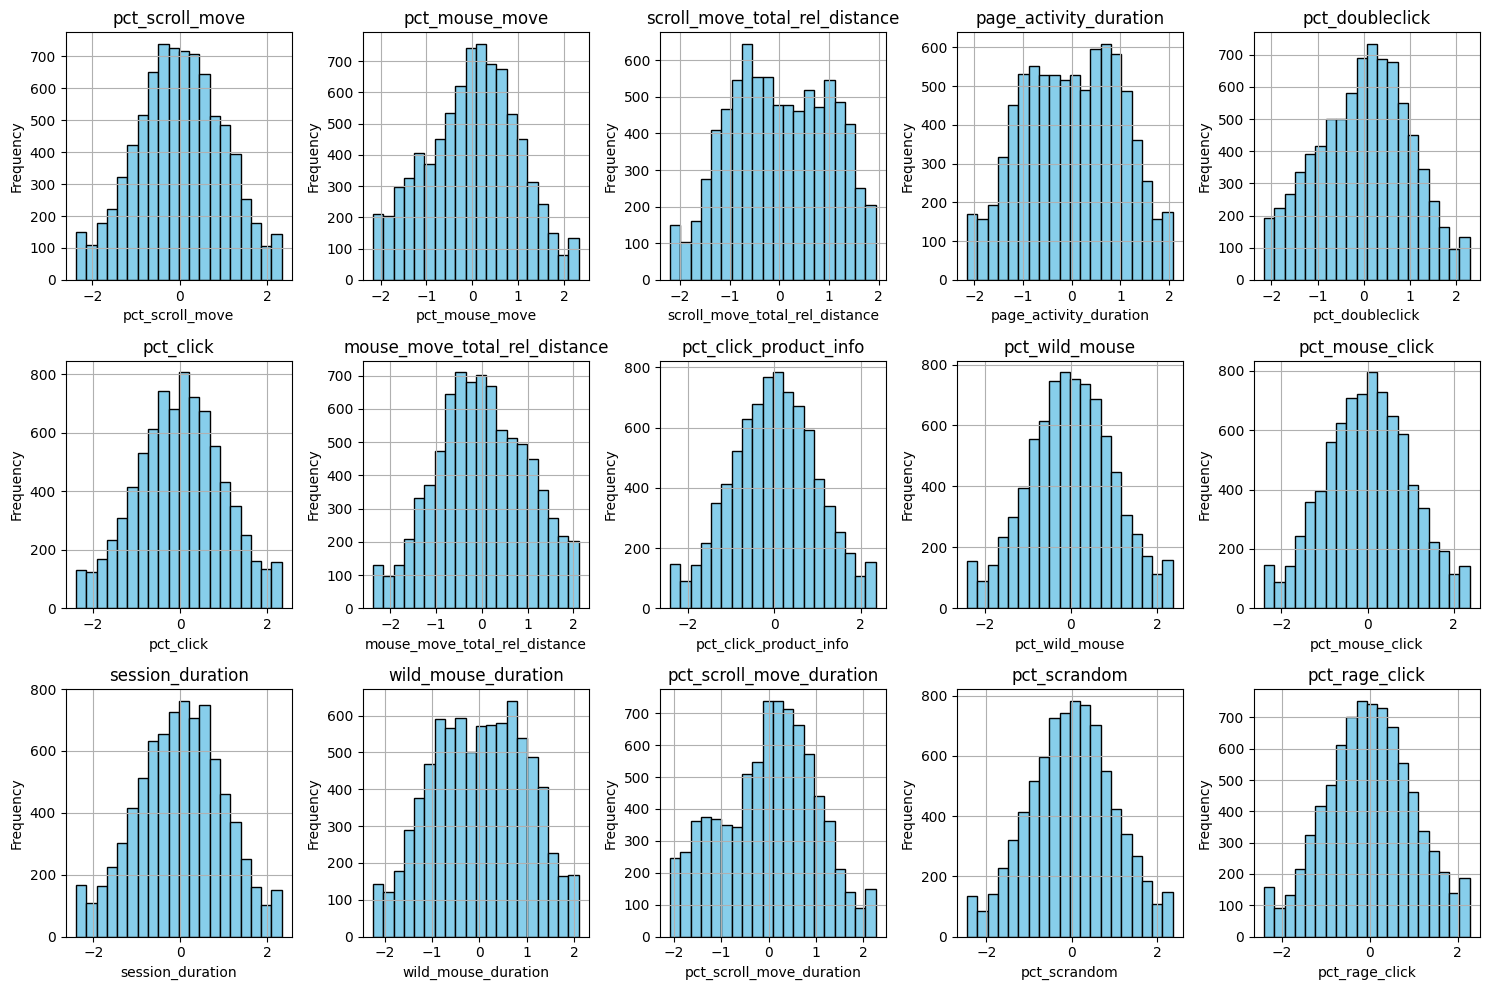

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
train_set[normal] = pt.fit_transform(train_set[normal])

num_rows = 3
num_cols = 5

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10)) 
axs = axs.flatten()

for i, column_name in enumerate(normal):
    axs[i].hist(train_set[column_name], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(column_name)
    axs[i].set_xlabel(column_name)
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

KstestResult(statistic=0.009768102176117899, pvalue=0.41304116891175247, statistic_location=2.3351381609473987, statistic_sign=1) 



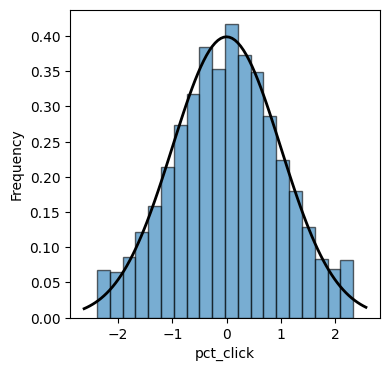

In [ ]:
print(stats.kstest(train_set['pct_click'], 'norm'), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_click'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_click'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_click')
ax.set_ylabel('Frequency')

plt.show()

KstestResult(statistic=0.0420282680535605, pvalue=5.344747100355209e-13, statistic_location=-1.1885569913979033, statistic_sign=1) 



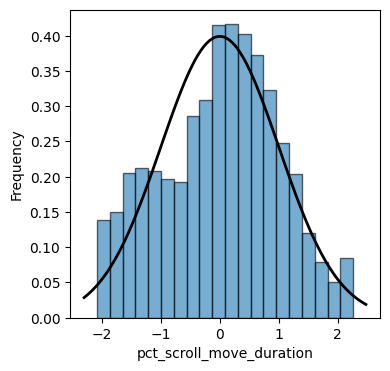

In [ ]:
print(stats.kstest(train_set['pct_scroll_move_duration'], 'norm'), '\n')

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_set['pct_scroll_move_duration'], bins=20, density=True, alpha=0.6, edgecolor='black')

mu, std = stats.norm.fit(train_set['pct_scroll_move_duration'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

ax.set_xlabel('pct_scroll_move_duration')
ax.set_ylabel('Frequency')

plt.show()

Na príkladoch vidíme, že dáta sa viac blížia k normálnemu rozdeleniu ako predtým, než na nich bol aplikovaný PowerTransformer. Následne dáta ešte budeme škálovať:

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train_set[normal+skewed] = scaler.fit_transform(train_set[normal+skewed])

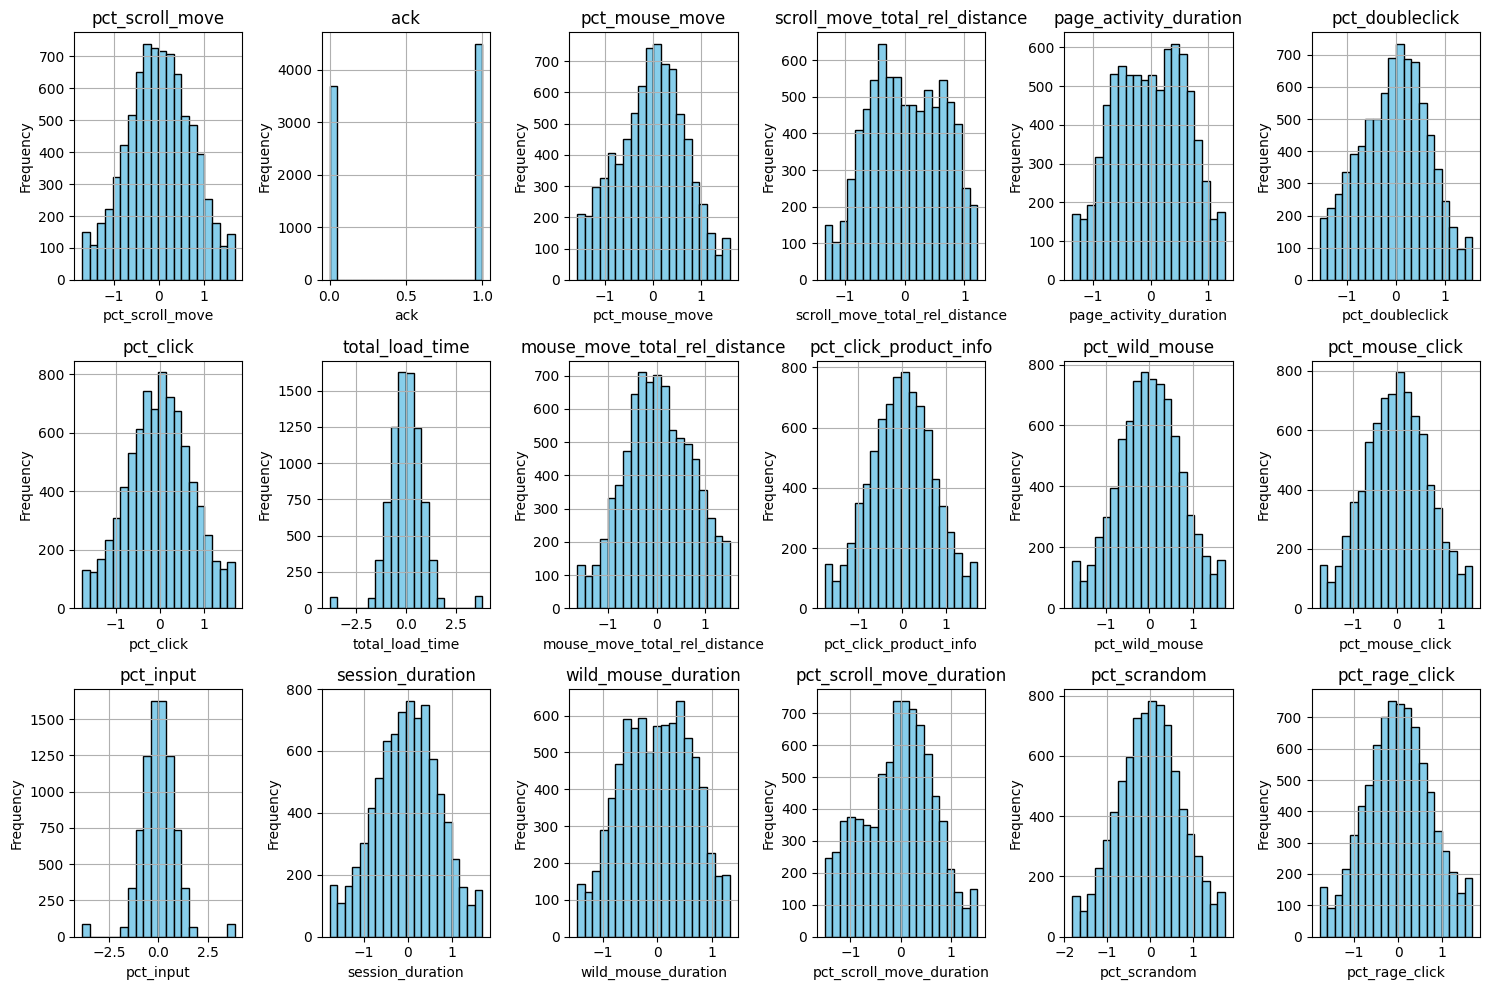

In [ ]:
num_rows = 3
num_cols = 6

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10)) 
axs = axs.flatten()

for i, column_name in enumerate(train_cols):
    axs[i].hist(train_set[column_name], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(column_name)
    axs[i].set_xlabel(column_name)
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
train_set[train_cols].describe()

pct_scroll_move          ack  pct_mouse_move  \
count      8184.000000  8184.000000    8.184000e+03   
mean          0.004160     0.548754   -4.023010e-02   
std           0.723324     0.497648    7.087606e-01   
min          -1.713135     0.000000   -1.575109e+00   
25%          -0.492260     0.000000   -5.367095e-01   
50%           0.000000     1.000000   -2.466560e-18   
75%           0.507740     1.000000    4.632905e-01   
max           1.692325     1.000000    1.606541e+00   

       scroll_move_total_rel_distance  page_activity_duration  \
count                    8.184000e+03            8.184000e+03   
mean                     2.232678e-02           -1.175483e-02   
std                      6.163794e-01            6.290326e-01   
min                     -1.335463e+00           -1.365119e+00   
25%                     -4.571275e-01           -5.118282e-01   
50%                     -2.141299e-18            1.084202e-18   
75%                      5.428725e-01            4.881718e-01   
max                      1.216822e+00            1.291792e+00   

       pct_doubleclick     pct_click  total_load_time  \
count     8.184000e+03  8.184000e+03     8.184000e+03   
mean     -4.252831e-02 -1.055592e-02     7.285836e-04   
std       6.956225e-01  7.365718e-01     8.750197e-01   
min      -1.546810e+00 -1.771470e+00    -3.854442e+00   
25%      -5.503760e-01 -5.122754e-01    -4.998980e-01   
50%       2.412350e-18 -6.369688e-19     2.032879e-20   
75%       4.496240e-01  4.877246e-01     5.001020e-01   
max       1.549793e+00  1.709336e+00     3.854885e+00   

       mouse_move_total_rel_distance  pct_click_product_info  pct_wild_mouse  \
count                   8.184000e+03             8184.000000    8.184000e+03   
mean                    2.531033e-02               -0.003646   -6.481053e-04   
std                     6.969100e-01                0.729255    7.365558e-01   
min                    -1.634093e+00               -1.769786   -1.781517e+00   
25%                    -4.545610e-01               -0.503452   -5.025360e-01   
50%                    -2.439455e-18                0.000000    5.421011e-20   
75%                     5.454390e-01                0.496548    4.974640e-01   
max                     1.502781e+00                1.711038    1.741825e+00   

       pct_mouse_click    pct_input  session_duration  wild_mouse_duration  \
count      8184.000000  8184.000000       8184.000000         8.184000e+03   
mean         -0.008773     0.000959         -0.020362        -2.042736e-02   
std           0.728211     0.884493          0.730093         6.451062e-01   
min          -1.759128    -3.853009         -1.771752        -1.473886e+00   
25%          -0.507970    -0.499432         -0.520158        -5.204555e-01   
50%           0.000000     0.000000          0.000000        -2.239555e-18   
75%           0.492030     0.500568          0.479842         4.795445e-01   
max           1.716721     3.852902          1.683639         1.334786e+00   

       pct_scroll_move_duration  pct_scrandom  pct_rage_click  
count               8184.000000   8184.000000    8.184000e+03  
mean                  -0.059067     -0.005793    1.143947e-03  
std                    0.698096      0.740392    7.421210e-01  
min                   -1.512214     -1.821683   -1.782197e+00  
25%                   -0.563615     -0.510769   -4.965595e-01  
50%                    0.000000      0.000000    7.453890e-20  
75%                    0.436385      0.489231    5.034405e-01  
max                    1.517413      1.744773    1.687942e+00

Na škálovanie dát sme použili RobustScaler, lebo nie je až tak citlivý na outlierov ako MinMaxScaler alebo StandardScaler a preškáloval hodnoty tak, že sa najviac podobajú normálnemu rozdeleniu, ktoré má mean = 0 a standard_deviation = 1.

<h3>Výber atribútov pre strojové učenie</h3>
Po transformácií a škálovaní dát sa chceme opäť pozrieť, ako jednotlivé atribúty korelujú s predikovanou premennou <b>ack</b>. Vykreslíme si preto heatmapu korelácií relevantných atribútov pred fázou predspracovania a po nej:

Pred spracovaním dát:

<AxesSubplot: >

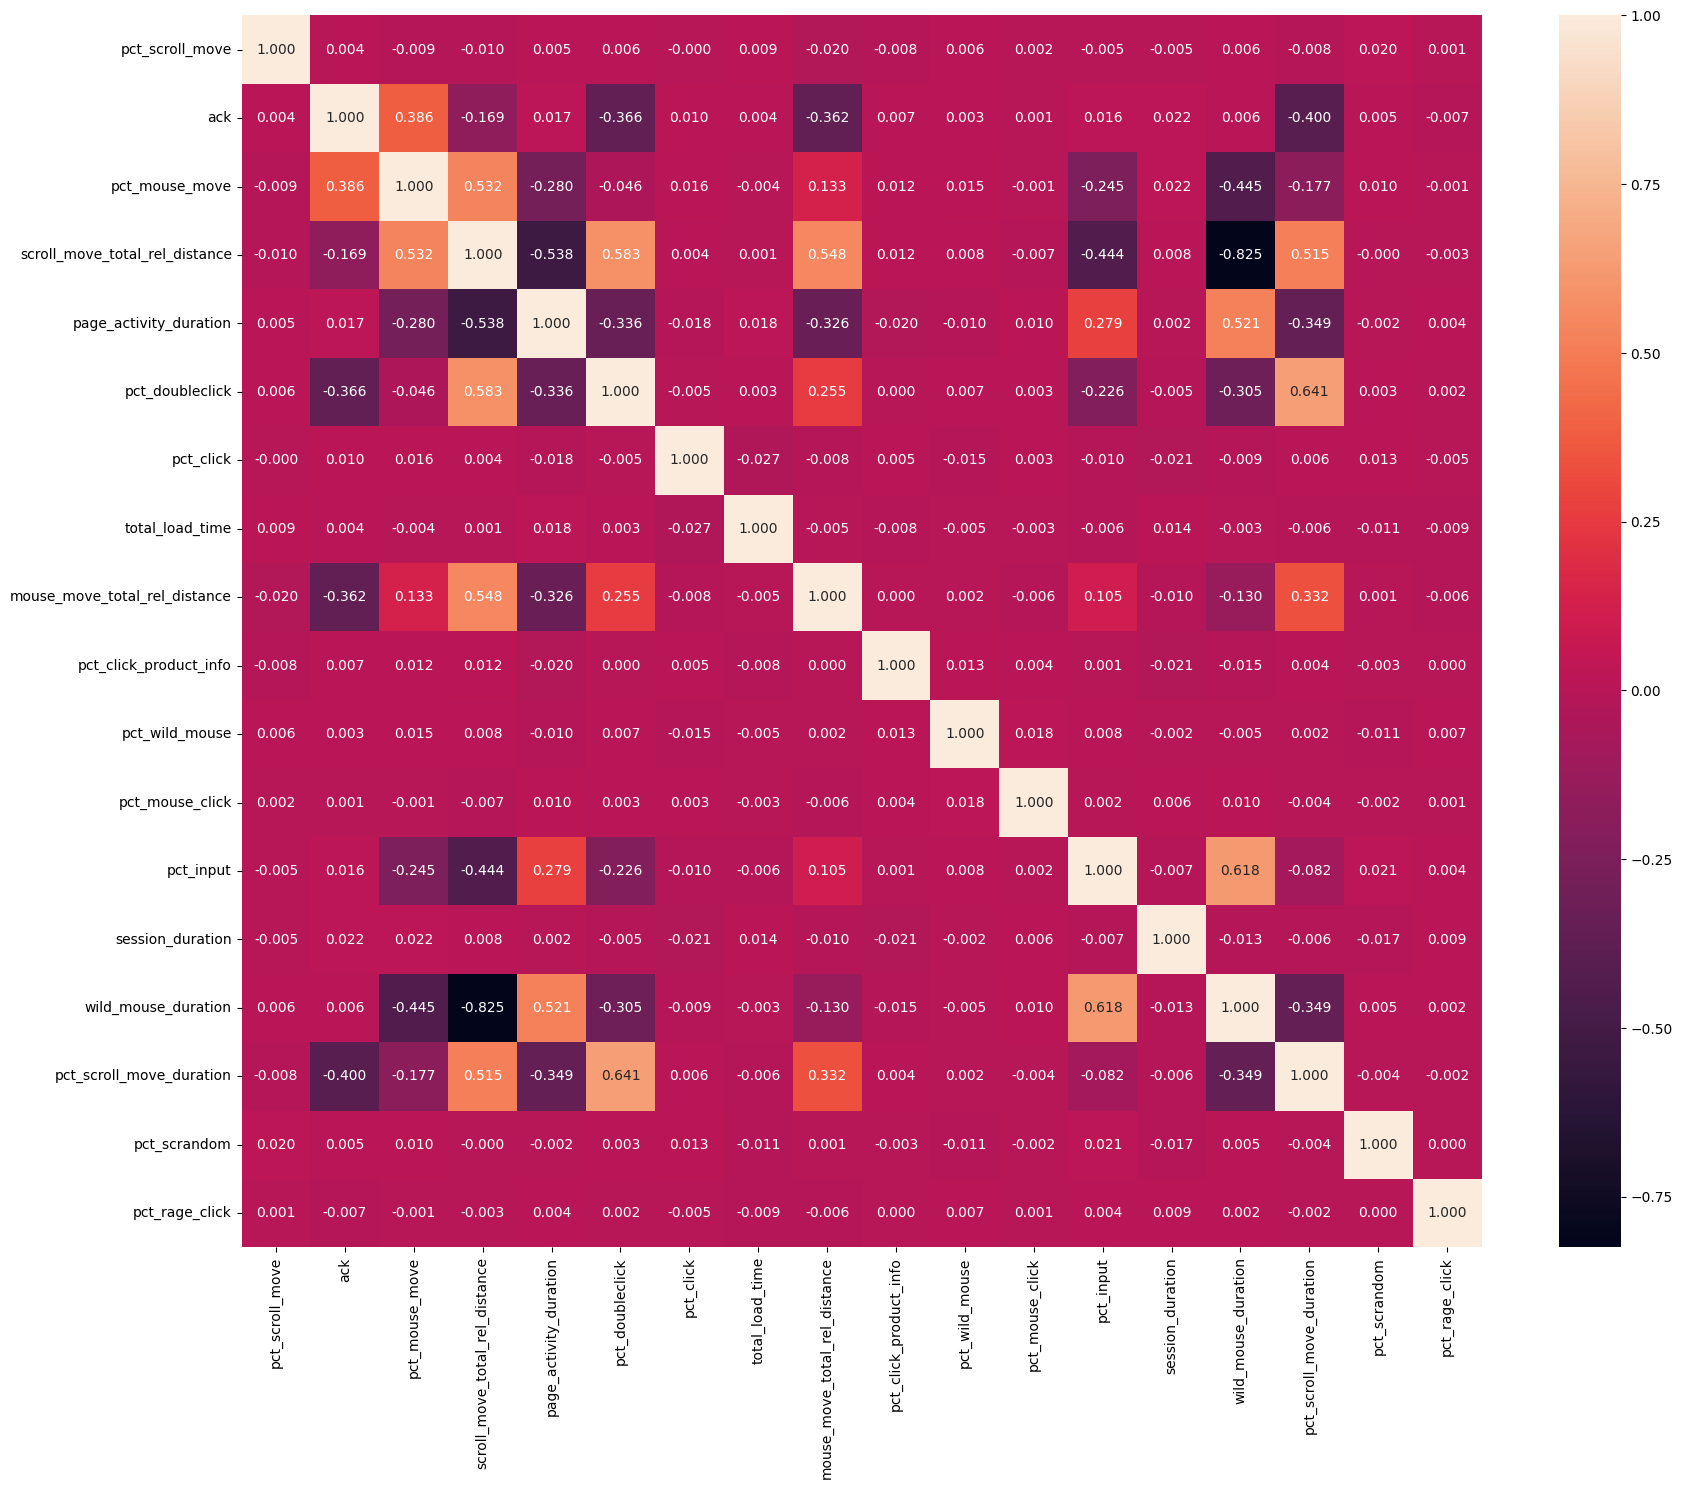

In [ ]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(sessions[train_cols].corr(),ax=ax, annot =True, fmt = ".3f")

Po spracovaní dát:

<AxesSubplot: >

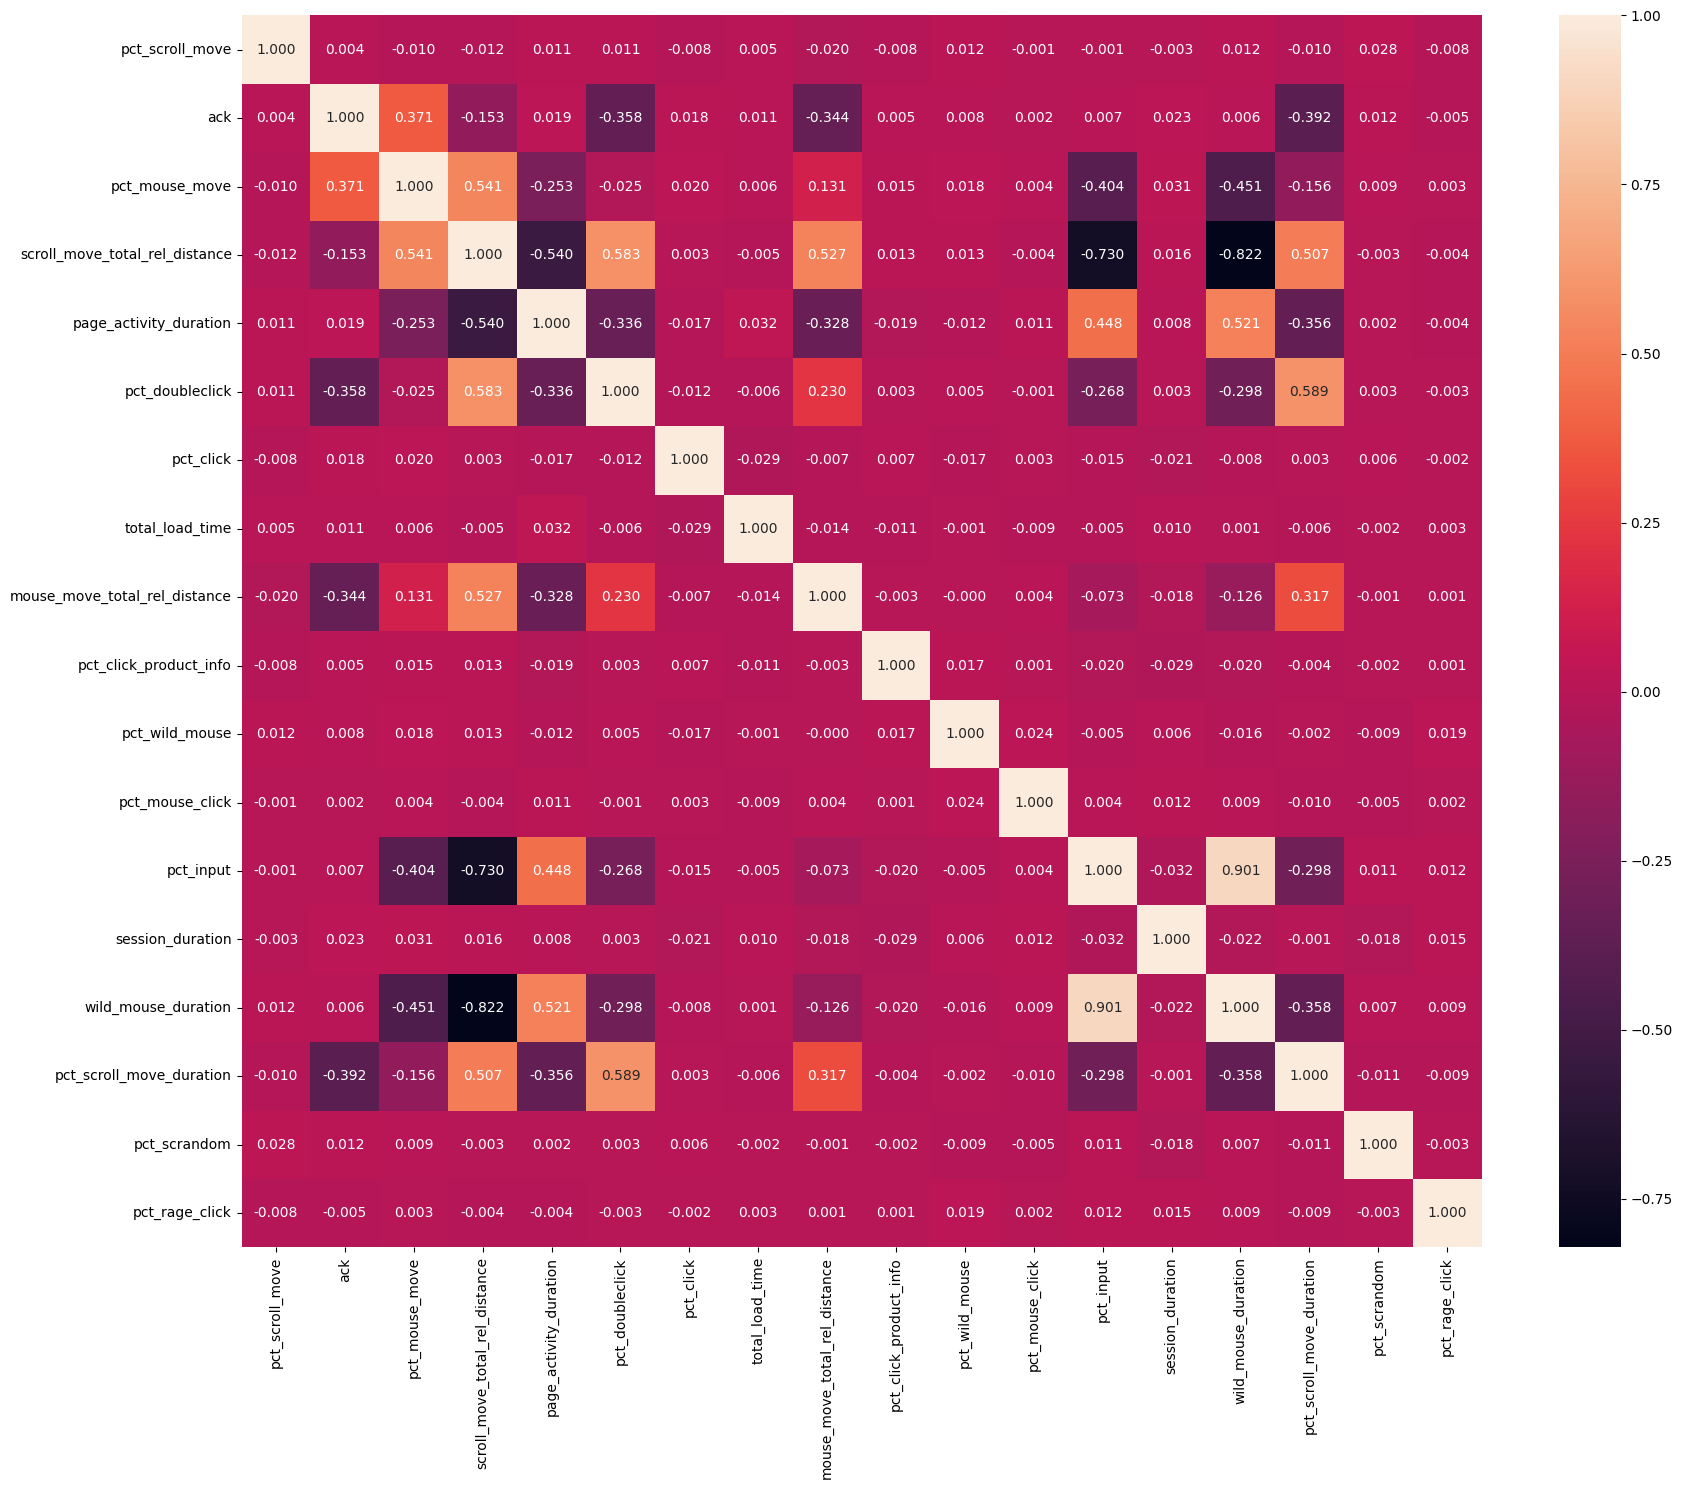

In [ ]:
figure, ax = plt.subplots(figsize=(20,16))
sns.heatmap(train_set[train_cols].corr(),ax=ax, annot =True, fmt = ".3f")

Z heatmapy vidíme, že najväčšie korelácie má premenná ACK s týmito atribútmi:
<ol>
<li> pct_mouse_move
<li> scroll_move_total_rel_distance
<li> pct_doubleclick
<li> mouse_move_total_rel_distance
<li> pct_scroll_move_duration
</ol>

Teraz vypíšeme korelácie s ACK a vybranými premennými, zoradíme ich.

In [ ]:
correlations = abs(train_set.corr()["ack"])
correlations = correlations.sort_values(ascending=False)
correlations = correlations[1:]

<AxesSubplot: >

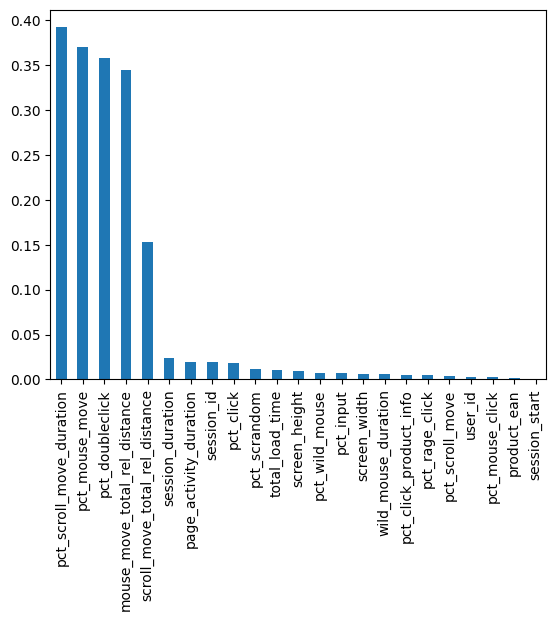

In [ ]:
correlations.plot(kind='bar')

Ako vidíme z grafu, najdôležitejšími atribútmi na základe korelácie s ACK sú:
<ol>
<li>pct_scroll_move_duration
<li>pct_doubleclick
<li>pct_mouse_move
<li>mouse_move_total_rel_distance
<li>scroll_move_total_rel_distance
<li>page_activity_duration
<li>wild_mouse_duration
</ol>


Ako druhú metódu použijeme <b>RandomForestRegressor</b>.

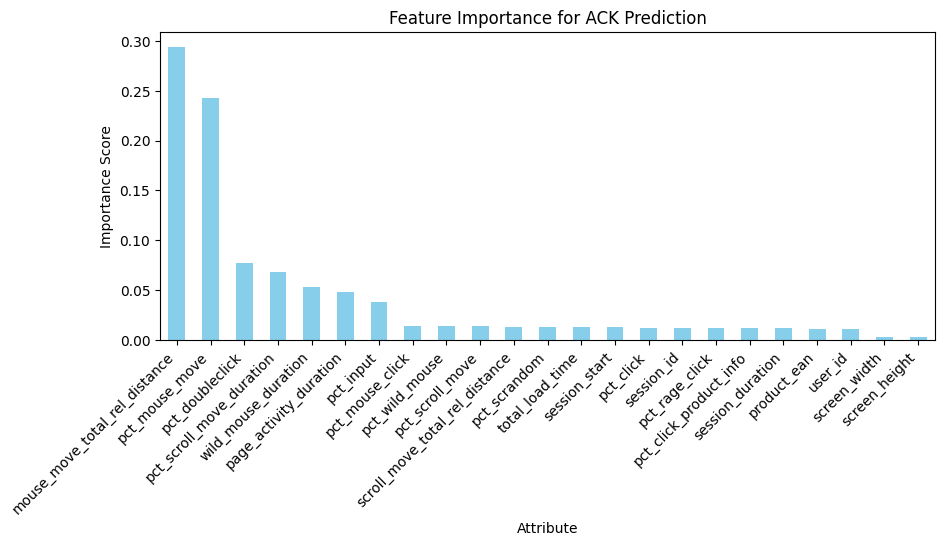

In [ ]:
X = train_set.drop('ack', axis=1)
y = train_set["ack"]

RFmodel = RandomForestRegressor()
RFmodel.fit(X, y)

attr_importances = pd.Series(RFmodel.feature_importances_, index=X.columns)
attr_importances = attr_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 4))
attr_importances.plot(kind='bar', color='skyblue')
plt.title('Feature Importance for ACK Prediction')
plt.xlabel('Attribute')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.show()

Z výsledneho grafu vieme vybrať niekoľko dôležitých atribútov, ku ktorým sme sa dostali pomocou tejto metódy:

<ol>
<li><b>mouse_move_total_rel_distance</b>
<li><b>pct_mouse_move</b>
<li><b>pct_doubleclick</b>
<li><b>pct_scroll_move_duration</b>
<li>wild_mouse_duration
<li>page_activity_duration
<li>pct_input
</ol>

Zvýraznené sú atribúty, ktoré sa nachádzajú v TOP 5 v obidboch výsledkoch. Zatiaľ nevieme s istototu určiť poradie dôležitosti, tak skúsime ešte jednu metódu, skúsime použiť <b>XGBoost</b>.

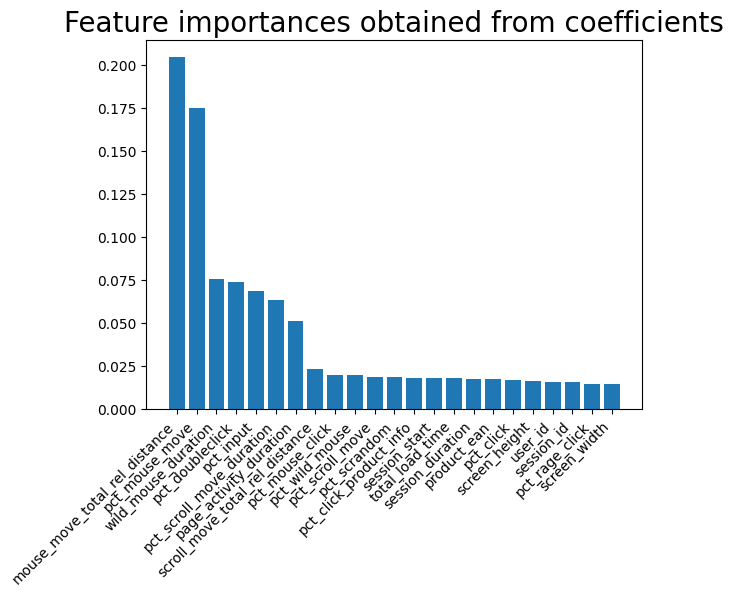

In [ ]:
X = train_set.drop('ack', axis=1)
y = train_set['ack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


model = XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation=45, ha='right')
plt.show()

Teraz vieme vybrať tieto atribúty:
<ol>
<li><b>mouse_move_total_rel_distance</b>
<li><b>pct_mouse_move</b>
<li><b>pct_input</b>
<li><b>pct_scroll_move_duration</b>
<li><b>pct_doubleclick</b>
<li>wild_mouse_duration
<li>page_activity_duration
</ol>

<h4>Dôležité atribúty</h4>
Na základe predchádzajúcich informácii, zoradíme atribúty podľa dôležitosti takto:

<ol>
<li><b>mouse_move_total_rel_distance
<li>pct_mouse_move
<li>pct_scroll_move_duration
<li>pct_doubleclick</b>
<li>pct_input
<li>wild_mouse_duration
<li>page_activity_duration
</ol>

Prvé štyri atribúty vyzerajú byť najviac dôležité, ale aj ostatné atribúty maju určitý vplyv na predikovanú premennú, tak zatiaľ uvádzame aj ich.

<h2>Replikovateľnosť predspracovania</h2>
V tejto časti budeme používať Pipeline, pomocou ktorej sa predošlé transformácie a úpravy dát vykonajú jednoduchším spôsobom.

In [ ]:
def get_indicies(columns_names, df):
    return [df.columns.get_loc(c) for c in columns_names if c in df]

In [ ]:
quantile_transformer = make_column_transformer((QuantileTransformer(output_distribution="normal"), get_indicies(skewed, train_set[train_cols])), remainder='passthrough')

In [ ]:
power_transformer = make_column_transformer((PowerTransformer(method='yeo-johnson'), get_indicies(normal, train_set[train_cols])),remainder='passthrough')

In [ ]:
robust_scaler = make_column_transformer((RobustScaler(),get_indicies(normal+skewed, train_set[train_cols])),remainder='passthrough')

In [ ]:
pl = Pipeline(steps=[('1',quantile_transformer),
                     ('2',power_transformer),
                     ('3',robust_scaler),
                     ("4",FunctionTransformer(lambda x: pd.DataFrame(x, columns = train_cols)))], verbose=True)


In [ ]:
transformed= pl.fit_transform(train_set[train_cols])
transformed

[Pipeline] ................. (step 1 of 4) Processing 1, total=   0.0s
[Pipeline] ................. (step 2 of 4) Processing 2, total=   0.1s
[Pipeline] ................. (step 3 of 4) Processing 3, total=   0.0s
[Pipeline] ................. (step 4 of 4) Processing 4, total=   0.0s


pct_scroll_move  ack  pct_mouse_move  scroll_move_total_rel_distance  \
0           -0.557334  0.0        0.746209                        0.818149   
1            0.766773  0.0        0.060347                       -0.032178   
2            0.912790 -1.0       -0.425463                        0.299681   
3            1.058416  0.0       -0.372759                        0.385607   
4           -0.516389 -1.0       -1.417280                       -0.047045   
...               ...  ...             ...                             ...   
8179         0.546848  0.0        0.532022                        0.701500   
8180         0.377860  0.0        0.013310                        0.123948   
8181        -0.684338  0.0        0.133223                       -0.547735   
8182        -0.173610 -1.0       -0.079087                        0.739901   
8183        -0.488429 -1.0        1.346698                        0.676521   

      page_activity_duration  pct_doubleclick  pct_click  total_load_time  \
0                  -0.512692        -0.500321   0.001636        -0.351433   
1                  -0.204837         1.469782   0.093256         0.767727   
2                  -1.135864         0.161756   0.030845        -0.971601   
3                  -0.742089         0.248577  -0.238347         0.937183   
4                   0.558731         0.324188  -0.580397         1.730880   
...                      ...              ...        ...              ...   
8179               -0.120399         0.281343  -1.749581        -0.480550   
8180               -0.776262         0.175922  -0.171926         1.557401   
8181                0.385715        -0.859463  -0.710334         0.055852   
8182               -0.648930        -0.191186  -0.669182         0.529974   
8183                0.073641        -0.302933   0.622319         0.881714   

      mouse_move_total_rel_distance  pct_click_product_info  pct_wild_mouse  \
0                         -1.383527               -1.034357       -0.999036   
1                          0.162344               -0.112904        0.870538   
2                         -0.417616                0.043711       -0.011326   
3                          0.206564               -0.408082       -0.391313   
4                          0.576303                0.379710        0.583676   
...                             ...                     ...             ...   
8179                      -0.562806               -0.691963       -1.071828   
8180                      -0.111831                0.385997       -0.339275   
8181                      -0.596144               -0.110462        0.939430   
8182                       0.550743               -0.020556       -0.566303   
8183                       0.379870               -0.544472        0.129329   

      pct_mouse_click  pct_input  session_duration  wild_mouse_duration  \
0           -0.437399  -1.368121          0.173756            -0.714627   
1           -0.506870  -0.085617          0.037077            -1.092989   
2           -0.744659   0.035801          0.465382             0.049251   
3           -0.118747  -0.397512          0.089522            -0.510016   
4           -1.058160   0.361522         -0.033252             0.499045   
...               ...        ...               ...                  ...   
8179         0.289353  -1.305730          0.080534             0.490767   
8180         0.480247   0.384425          1.333932            -0.330646   
8181        -0.077945  -0.096740         -1.093740            -0.914090   
8182         0.393850  -0.005741          1.277988             0.188746   
8183         0.123897  -0.591191         -0.911581             0.295294   

      pct_scroll_move_duration  pct_scrandom  pct_rage_click  
0                     0.074360      0.333899       -0.145892  
1                    -0.701664      0.275080        0.280086  
2                     0.974422     -0.031580        0.827542  
3                     0.615073      0.0798

<h3>Záver</h3>
V tejto časti sme sa venovali predspracovaniu dát a výberu najviac informatívnych atribútov k našej predikovanej premennej <b>ack</b>. Vyskúšali sme aj viacero metód osdtraňovania chýbajúcich hodnôt, vychýlených hodnôt a viacero transformácií. Vo výsledku sme dostali dataset pre strojové učenie:

In [ ]:
train_set[train_cols].head()

pct_scroll_move  ack  pct_mouse_move  scroll_move_total_rel_distance  \
464         -0.096791  1.0        0.725190                        0.809735   
2314         0.210924  1.0        0.060048                       -0.032238   
7021         0.603759  0.0       -0.431576                        0.298610   
947          0.324181  1.0       -0.377406                        0.383752   
3989         0.229577  0.0       -1.479813                       -0.047144   

      page_activity_duration  pct_doubleclick  pct_click  total_load_time  \
464                -0.519823         0.173756  -0.501161        -0.556806   
2314               -0.206005         0.037077   1.463518         0.767807   
7021               -1.167339         0.465382   0.161643         0.914154   
947                -0.756455         0.089522   0.248326         1.060221   
3989                0.550095        -0.033252   0.323777        -0.515939   

      mouse_move_total_rel_distance  pct_click_product_info  pct_wild_mouse  \
464                        0.074361                0.001636       -0.352330   
2314                      -0.703638                0.093170        0.763840   
7021                       0.971574                0.030834       -0.977584   
947                        0.613904               -0.238850        0.931609   
3989                       1.046368               -0.583163        1.714541   

      pct_mouse_click  pct_input  session_duration  wild_mouse_duration  \
464         -0.714627  -1.368569         -1.431385            -1.064267   
2314        -1.092989  -0.085634          0.161328            -0.113237   
7021         0.049251   0.035777         -0.422602             0.043596   
947         -0.510016  -0.397509          0.204994            -0.413130   
3989         0.499045   0.361493          0.566214             0.374684   

      pct_scroll_move_duration  pct_scrandom  pct_rage_click  
464                   0.325204     -1.007435       -0.439023  
2314                  0.268778      0.863818       -0.509009  
7021                 -0.031444     -0.011326       -0.749009  
947                   0.078973     -0.392752       -0.118882  
3989                  1.517413      0.580413       -1.066370

In [ ]:
test_set[train_cols].head()

pct_scroll_move  ack  pct_mouse_move  scroll_move_total_rel_distance  \
1501         56.19179  1.0        10.54602                        12.46525   
2626         48.01634  0.0        12.38643                        14.44718   
6954         67.94846  1.0        13.18445                         8.02990   
183          35.98665  0.0         8.94157                        13.48460   
2399         67.21278  1.0        11.53678                         9.60694   

      page_activity_duration  pct_doubleclick  pct_click  total_load_time  \
1501                 6.96227         11.99261    8.96052          3.82255   
2626                 7.91066         11.02740    9.82781          1.15590   
6954                 9.66881          7.24359    9.75880          1.93872   
183                  5.41347         13.32533    8.97487          2.82381   
2399                 6.59436         11.22351   10.39331          2.31673   

      mouse_move_total_rel_distance  pct_click_product_info  pct_wild_mouse  \
1501                        6.86287               61.143460        44.20147   
2626                       10.64166               60.268780        46.40055   
6954                        6.28120               43.955930        45.17778   
183                        11.86061               50.510800        36.53077   
2399                        6.10689               21.497307        55.55391   

      pct_mouse_click  pct_input  session_duration  wild_mouse_duration  \
1501          9.01984    0.01006         138.91213              6.14547   
2626         10.01746    0.00673         149.23925              6.90375   
6954          9.22910    0.06496         146.50004              9.37698   
183          10.85990    0.01803         108.39634              7.63752   
2399         10.08902    0.04199         150.22547              8.86210   

      pct_scroll_move_duration  pct_scrandom  pct_rage_click  
1501                  11.65502     66.049530        46.44519  
2626                  11.12902     57.685570        33.44758  
6954                   6.65922     16.073845        21.44311  
183                    9.66036     36.314750        63.63268  
2399                  10.30602     37.643100        63.26238